# Machine Learning Regressoin Model for Housing Prices tuned Using Optuna and CatBoostRegressor

## The following cell has the code for installing the libraries that are not commonly found in python installations. If they are already installed just delete the cell or comment it out.

In [1]:
!pip install catboost --user
!pip install optuna --user

## The folllowing is the model for the dataset on Housing Prices and the prediction by using CatBoostRegressor. The train.csv dataset contains 1459 entries and the test.csv dataset contains 1459 entries to which the prediction is outputed into the sample_submission.csv. You can follow through to see the operations performed on the data and the model built for the prediction.
## The first cell contains all the neccesary libraries that will be used in the model and all the preprocessing activities.

In [2]:
import catboost
import optuna
from scipy import stats
import datetime as dt
import time
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
from catboost import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.model_selection import  train_test_split, GridSearchCV
from sklearn.metrics import *
from catboost import CatBoostRegressor
import math
from sklearn import tree, model_selection
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## The cell below is used to read the .csv files into pandas dataframes that we shall be working on throughout the entire notebook.

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

## The Cell below contains code to allow 100 outputs to be seen to allow me to see the features to discard and the the features to keep.  

In [4]:
pd.set_option("display.max_rows", 100)

## The Cell below contains code to look for the null values in the train dataset and show them as percentages.

In [5]:
train.isnull().mean()*100

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
BsmtCond          2.534247
BsmtExposure      2.602740
BsmtFinType1      2.534247
BsmtFinSF1        0.000000
BsmtFinType2      2.602740
BsmtFinSF2        0.000000
B

## The Cell below contains code to drop the unusable columns in the train.csv dataset that have too many null values to be useful features.

In [6]:
X = train.drop(["LotFrontage","Alley","FireplaceQu","PoolQC","Fence","MiscFeature","Id"], axis=1)

## The Cell below contains code to view all the unique values in each column. If a column has alot of unique values, they have to be continous data values or it cannot be useful as a feature and also if it has very few unique values then it has to be categorical data values or else it cannot be a useful feature.

In [7]:
X.nunique().sort_values()

Street              2
CentralAir          2
Utilities           2
BsmtHalfBath        3
HalfBath            3
GarageFinish        3
LandSlope           3
PavedDrive          3
Fireplaces          4
KitchenQual         4
KitchenAbvGr        4
ExterQual           4
BsmtQual            4
BsmtCond            4
LandContour         4
LotShape            4
FullBath            4
BsmtExposure        4
BsmtFullBath        4
MasVnrType          4
ExterCond           5
GarageQual          5
Electrical          5
HeatingQC           5
BldgType            5
YrSold              5
LotConfig           5
MSZoning            5
GarageCond          5
GarageCars          5
SaleCondition       6
GarageType          6
Heating             6
BsmtFinType1        6
Foundation          6
RoofStyle           6
BsmtFinType2        6
Functional          7
RoofMatl            8
PoolArea            8
HouseStyle          8
Condition2          8
BedroomAbvGr        8
OverallCond         9
Condition1          9
SaleType  

## The Cell below contains code to sort the columns according to their different data types so that I can get all the categorical data columns into the next cell.

In [8]:
X.dtypes.sort_values()

MSSubClass         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
BsmtFinSF2         int64
BsmtFinSF1         int64
SalePrice          int64
OverallQual        int64
LotArea            int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
GarageYrBlt      float64
GarageFinish      object
Condition2        object
Condition1        object
GarageQual        object


## The Cell below contains code to change all the categorrical columns into integers so that I can work on them to find the P-value and also to use for separation from the rest of the dataset to be left with the continous data for correlation analysis using RegPlot.

In [9]:
X = X.astype({'GarageFinish' : 'category' ,'Condition2' : 'category' ,'Condition1' : 'category',
'GarageQual' : 'category','GarageCond' : 'category','BsmtExposure' : 'category','Neighborhood' : 'category',
'LandSlope' : 'category','LotConfig' : 'category','Utilities' : 'category','LandContour' : 'category',
'LotShape' : 'category','Street' : 'category','MSZoning' : 'category','SaleType' : 'category',
'PavedDrive' : 'category','GarageType' : 'category','HouseStyle' : 'category','Functional' : 'category',
'BsmtFinType1' : 'category','BsmtQual' : 'category','BsmtFinType2' : 'category','Foundation' : 'category',
'ExterCond' : 'category','ExterQual' : 'category','SaleCondition' : 'category','HeatingQC' : 'category',
'CentralAir' : 'category','Electrical' : 'category','MasVnrType' : 'category','Exterior2nd' : 'category',
'Exterior1st' : 'category','RoofMatl' : 'category','RoofStyle' : 'category','KitchenQual' : 'category',
'BsmtCond' : 'category','BldgType' : 'category','Heating' : 'category'})
cat_columns = X.select_dtypes(['category']).columns
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
X.dtypes.sort_values()

Heating             int8
ExterQual           int8
Foundation          int8
BsmtQual            int8
BsmtCond            int8
BsmtExposure        int8
BsmtFinType1        int8
BsmtFinType2        int8
SaleCondition       int8
HeatingQC           int8
CentralAir          int8
Electrical          int8
PavedDrive          int8
GarageCond          int8
GarageQual          int8
GarageFinish        int8
GarageType          int8
Functional          int8
MasVnrType          int8
Exterior2nd         int8
ExterCond           int8
RoofMatl            int8
MSZoning            int8
SaleType            int8
Street              int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1          int8
Exterior1st         int8
KitchenQual         int8
Condition2          int8
RoofStyle           int8
BldgType            int8
HouseStyle          int8
OpenPorchSF        int64
Fireplaces         int64


## The Cell below contains code to perform the correlation analysis on the continous data columns and only use those that pass a certain threshhold seen in the if-else statement in the cell. Only the columns that pass this test will be used in the RegPlot section of the cell and plotted out.

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
The correlation between  TotalBsmtSF  and SalesPrice is =  0.6135805515591954
The correlation between  1stFlrSF  and SalesPrice is =  0.6058521846919148
The correlation between  GrLivArea  and SalesPrice is =  0.7086244776126521
The correlation between  GarageArea  and SalesPrice is =  0.6234314389183621
['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']


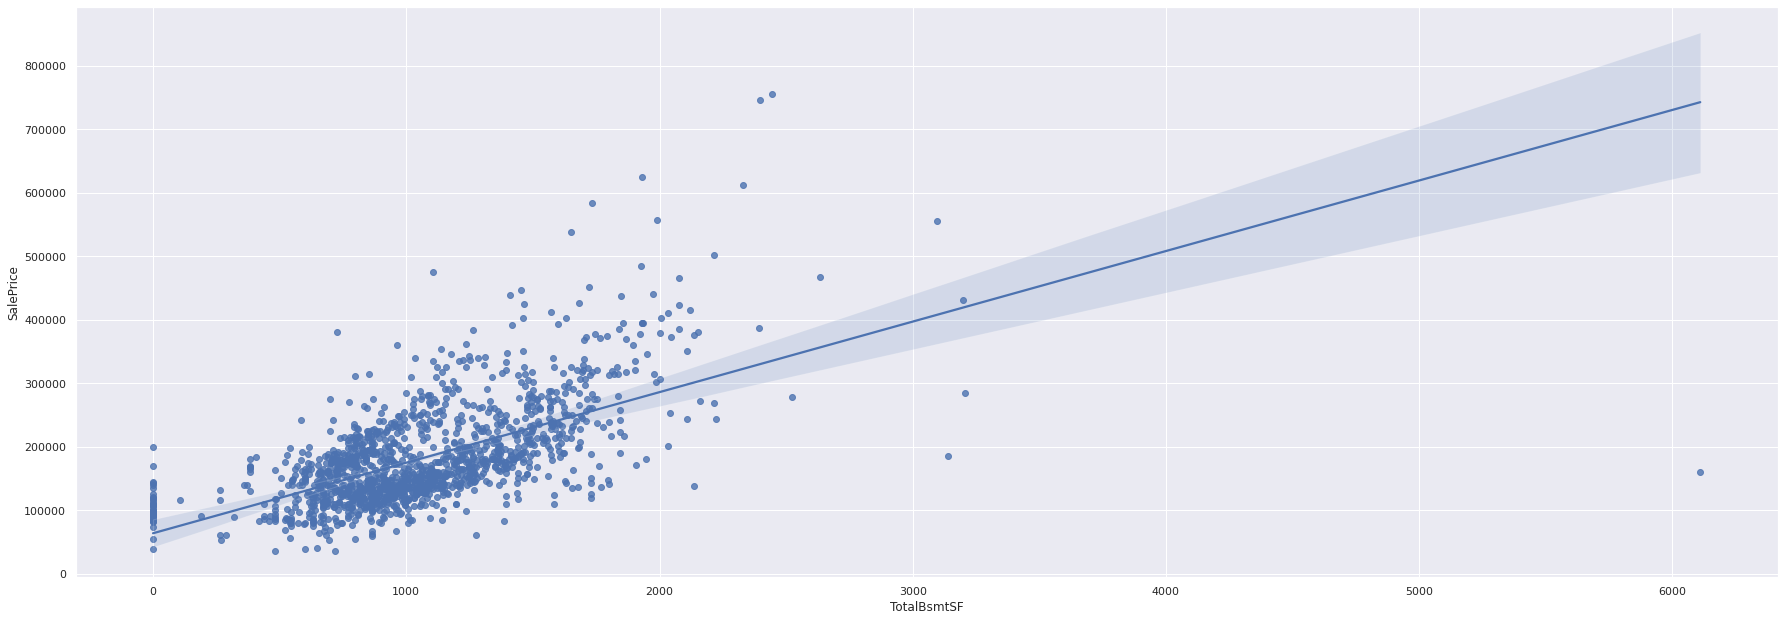

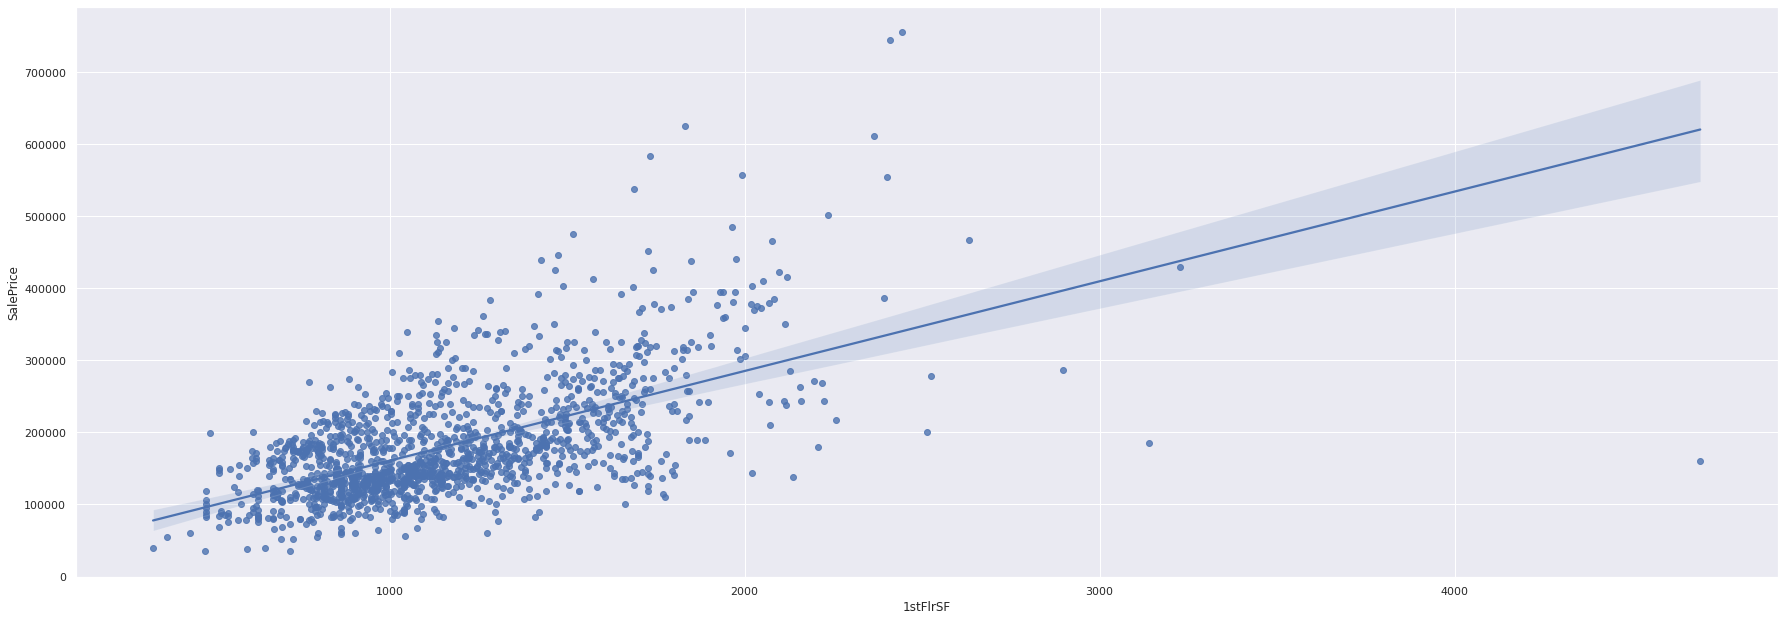

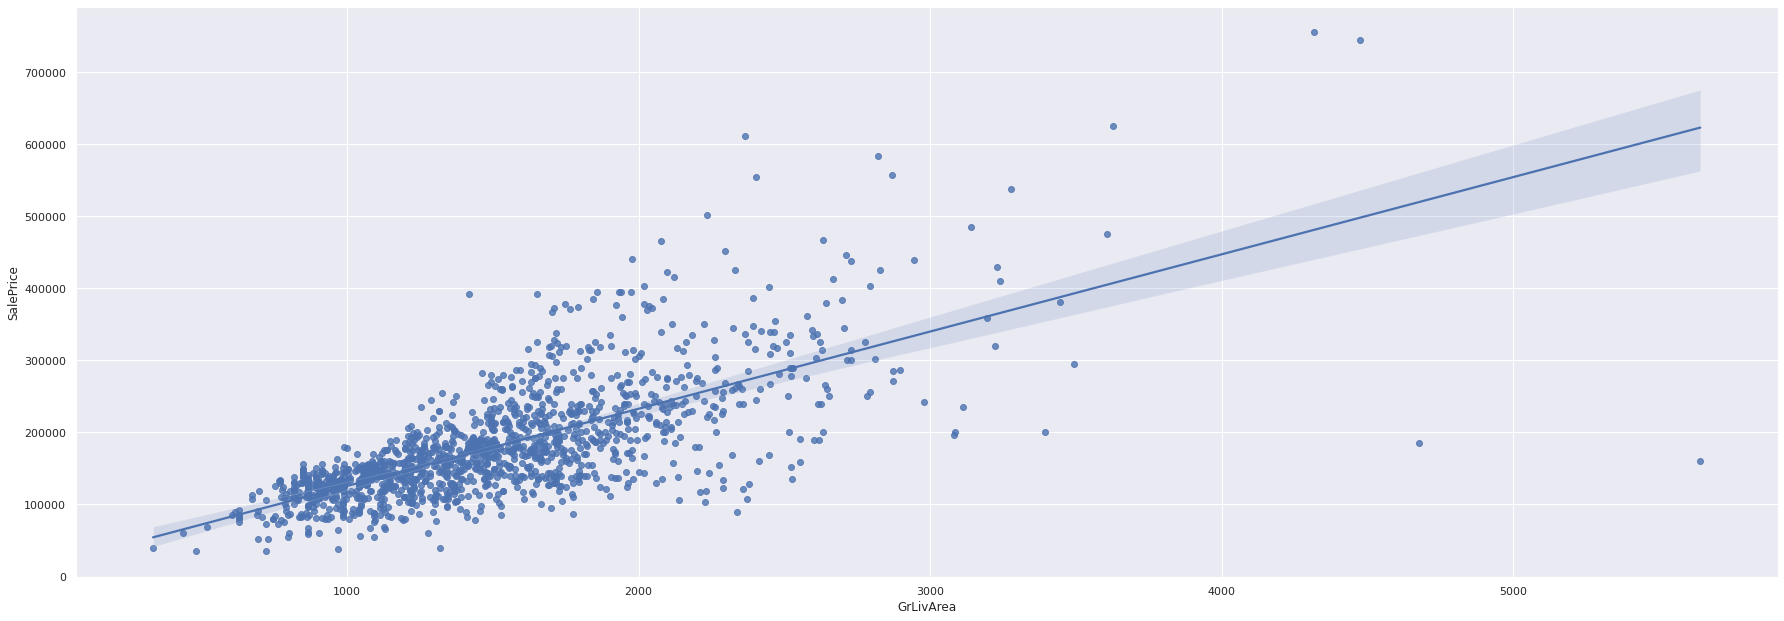

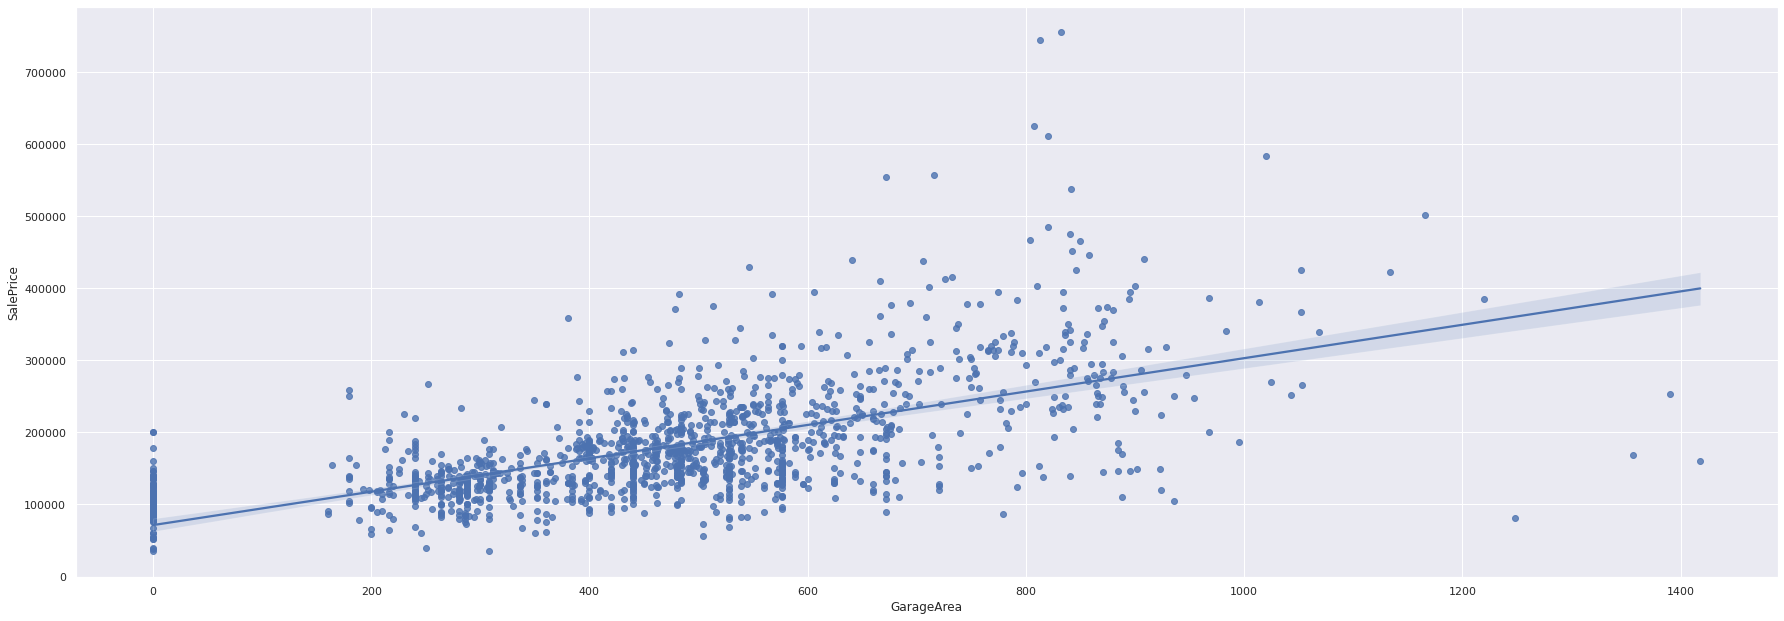

In [10]:
c_n_housing1 = X.columns.values.tolist()
unwanted_num=["SalePrice","GarageFinish","Condition2","Condition1","GarageQual","GarageCond","BsmtExposure",
              "Neighborhood","LandSlope","LotConfig","Utilities","LandContour","LotShape","Street","MSZoning",
              "SaleType","PavedDrive","GarageType","HouseStyle","Functional","BsmtFinType1","BsmtQual",
              "BsmtFinType2","Foundation","ExterCond","ExterQual","SaleCondition","HeatingQC","CentralAir",
              "Electrical","MasVnrType","Exterior2nd","Exterior1st","RoofMatl","RoofStyle","KitchenQual",
              "BsmtCond","BldgType","Heating","MSSubClass","OverallQual","OverallCond","BsmtFullBath",
              "BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","Fireplaces","GarageCars",
              "MoSold","YrSold","TotRmsAbvGrd","YearRemodAdd","YearBuilt","GarageYrBlt"]
c_n_housing1 = [ele for ele in c_n_housing1 if ele not in unwanted_num]
print(c_n_housing1)
corrp = []

for i in c_n_housing1: 
    putt = X[i].corr(X['SalePrice'])
    
    if putt >= 0.5 or putt <-0.5:
        corrp = corrp + [i]
    else:
        continue
    print("The correlation between ", i ," and SalesPrice is = ", putt)
print(corrp)

for i in corrp:  # Loop over all columns except 'Location'
    sns.set()
    fig, ax = plt.subplots()
    fig.set_size_inches(30.5, 10.5)
    sns.regplot(x=i, y='SalePrice', data=X)  # column is chosen here
   

## The Cells below contain code to store the names of the categorical data to use for finding the P-value of the categorical columns. One column, GarageYrBlt, has missing data and needs to be filled first to be used, after which I calculate the P-value and and choose those that have a P-value of less than 0.001.

In [11]:

pearson_housing = ["GarageFinish","Condition2","Condition1","GarageQual","GarageCond","BsmtExposure",
        "Neighborhood","LandSlope","LotConfig","Utilities","LandContour","LotShape","Street","MSZoning",
        "SaleType","PavedDrive","GarageType","HouseStyle","Functional","BsmtFinType1","BsmtQual",
        "BsmtFinType2","Foundation","ExterCond","ExterQual","SaleCondition","HeatingQC","CentralAir",
        "Electrical","MasVnrType","Exterior2nd","Exterior1st","RoofMatl","RoofStyle","KitchenQual",
        "BsmtCond","BldgType","Heating","MSSubClass","OverallQual","OverallCond","BsmtFullBath",
        "BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","Fireplaces","GarageCars",
        "MoSold","YrSold","TotRmsAbvGrd","YearRemodAdd","YearBuilt","GarageYrBlt"]
X2 = X[["SalePrice","GarageFinish","Condition2","Condition1","GarageQual","GarageCond","BsmtExposure",
        "Neighborhood","LandSlope","LotConfig","Utilities","LandContour","LotShape","Street","MSZoning",
        "SaleType","PavedDrive","GarageType","HouseStyle","Functional","BsmtFinType1","BsmtQual",
        "BsmtFinType2","Foundation","ExterCond","ExterQual","SaleCondition","HeatingQC","CentralAir",
        "Electrical","MasVnrType","Exterior2nd","Exterior1st","RoofMatl","RoofStyle","KitchenQual",
        "BsmtCond","BldgType","Heating","MSSubClass","OverallQual","OverallCond","BsmtFullBath",
        "BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","Fireplaces","GarageCars",
        "MoSold","YrSold","TotRmsAbvGrd","YearRemodAdd","YearBuilt","GarageYrBlt"]]
np.isnan(X2).any()

SalePrice        False
GarageFinish     False
Condition2       False
Condition1       False
GarageQual       False
GarageCond       False
BsmtExposure     False
Neighborhood     False
LandSlope        False
LotConfig        False
Utilities        False
LandContour      False
LotShape         False
Street           False
MSZoning         False
SaleType         False
PavedDrive       False
GarageType       False
HouseStyle       False
Functional       False
BsmtFinType1     False
BsmtQual         False
BsmtFinType2     False
Foundation       False
ExterCond        False
ExterQual        False
SaleCondition    False
HeatingQC        False
CentralAir       False
Electrical       False
MasVnrType       False
Exterior2nd      False
Exterior1st      False
RoofMatl         False
RoofStyle        False
KitchenQual      False
BsmtCond         False
BldgType         False
Heating          False
MSSubClass       False
OverallQual      False
OverallCond      False
BsmtFullBath     False
BsmtHalfBat

In [12]:
X2['GarageYrBlt'].fillna(int((X2['GarageYrBlt'].mean())), inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [13]:
np.isnan(X2).any()

SalePrice        False
GarageFinish     False
Condition2       False
Condition1       False
GarageQual       False
GarageCond       False
BsmtExposure     False
Neighborhood     False
LandSlope        False
LotConfig        False
Utilities        False
LandContour      False
LotShape         False
Street           False
MSZoning         False
SaleType         False
PavedDrive       False
GarageType       False
HouseStyle       False
Functional       False
BsmtFinType1     False
BsmtQual         False
BsmtFinType2     False
Foundation       False
ExterCond        False
ExterQual        False
SaleCondition    False
HeatingQC        False
CentralAir       False
Electrical       False
MasVnrType       False
Exterior2nd      False
Exterior1st      False
RoofMatl         False
RoofStyle        False
KitchenQual      False
BsmtCond         False
BldgType         False
Heating          False
MSSubClass       False
OverallQual      False
OverallCond      False
BsmtFullBath     False
BsmtHalfBat

In [14]:
pcarl = []
for i in pearson_housing: 
   pearson_coef, p_value = stats.pearsonr(X2[i],X2['SalePrice'])
   if p_value <= 0.001:
        pcarl = pcarl + [i]
   else:
        continue
   print("The P-value of " ,i ," is P =", p_value) 

print(pcarl)

The P-value of  GarageFinish  is P = 3.448137521356474e-30
The P-value of  Condition1  is P = 0.0004879176783954465
The P-value of  GarageQual  is P = 3.1645107015068274e-24
The P-value of  GarageCond  is P = 6.788286194007077e-27
The P-value of  BsmtExposure  is P = 9.967788255316718e-14
The P-value of  Neighborhood  is P = 3.906732804258554e-16
The P-value of  LotShape  is P = 3.320711818202238e-23
The P-value of  MSZoning  is P = 1.4013002757716125e-10
The P-value of  PavedDrive  is P = 3.41833974822374e-19
The P-value of  GarageType  is P = 4.9380729885063305e-18
The P-value of  HouseStyle  is P = 4.06428284944684e-12
The P-value of  Functional  is P = 9.978134702390179e-06
The P-value of  BsmtQual  is P = 8.662182640654226e-70
The P-value of  BsmtFinType2  is P = 5.28440976280076e-07
The P-value of  Foundation  is P = 4.579865873936533e-52
The P-value of  ExterCond  is P = 6.995963215338824e-06
The P-value of  ExterQual  is P = 6.4244677574169624e-167
The P-value of  SaleCondition

## The Cell below contains code to add polynomial features to try and augment the data to mitigate the variance and decrease the Mean Absolute Percentage Error (M.A.P.E). I will be trying to remove the polynomial data and leave the rest of the data to reduce variance.
## Update: I have removed the columns of power raised values to reduce the variance and just augment the data while adding new relationships that can be translated directly to the test data.  

In [15]:
pr = pf(degree = 4, interaction_only=True, include_bias=False)
train_poly = pr.fit_transform(train[['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']])
pr.get_feature_names_out(['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea'])

array(['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
       'TotalBsmtSF 1stFlrSF', 'TotalBsmtSF GrLivArea',
       'TotalBsmtSF GarageArea', '1stFlrSF GrLivArea',
       '1stFlrSF GarageArea', 'GrLivArea GarageArea',
       'TotalBsmtSF 1stFlrSF GrLivArea',
       'TotalBsmtSF 1stFlrSF GarageArea',
       'TotalBsmtSF GrLivArea GarageArea',
       '1stFlrSF GrLivArea GarageArea',
       'TotalBsmtSF 1stFlrSF GrLivArea GarageArea'], dtype=object)

In [16]:
pd.DataFrame(train_poly,columns=['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
                                 'TotalBsmtSF 1stFlrSF', 'TotalBsmtSF GrLivArea',
                                 'TotalBsmtSF GarageArea', '1stFlrSF GrLivArea',
                                 '1stFlrSF GarageArea', 'GrLivArea GarageArea',
                                 'TotalBsmtSF 1stFlrSF GrLivArea',
                                 'TotalBsmtSF 1stFlrSF GarageArea',
                                 'TotalBsmtSF GrLivArea GarageArea',
                                 '1stFlrSF GrLivArea GarageArea',
                                 'TotalBsmtSF 1stFlrSF GrLivArea GarageArea'])

,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,TotalBsmtSF 1stFlrSF,TotalBsmtSF GrLivArea,TotalBsmtSF GarageArea,1stFlrSF GrLivArea,1stFlrSF GarageArea,GrLivArea GarageArea,TotalBsmtSF 1stFlrSF GrLivArea,TotalBsmtSF 1stFlrSF GarageArea,TotalBsmtSF GrLivArea GarageArea,1stFlrSF GrLivArea GarageArea,TotalBsmtSF 1stFlrSF GrLivArea GarageArea
0,1214.0,1260.0,2291.0,506.0,1529640.0,2781274.0,614284.0,2886660.0,637560.0,1159246.0,3.504405e+09,773997840.0,1.407325e+09,1.460650e+09,1.773229e+12
1,756.0,756.0,1469.0,216.0,571536.0,1110564.0,163296.0,1110564.0,163296.0,317304.0,8.395864e+08,123451776.0,2.398818e+08,2.398818e+08,1.813507e+11
2,907.0,1307.0,2358.0,360.0,1185449.0,2138706.0,326520.0,3081906.0,470520.0,848880.0,2.795289e+09,426761640.0,7.699342e+08,1.109486e+09,1.006304e+12
3,1020.0,908.0,1928.0,440.0,926160.0,1966560.0,448800.0,1750624.0,399520.0,848320.0,1.785636e+09,407510400.0,8.652864e+08,7.702746e+08,7.856801e+11
4,264.0,768.0,1432.0,360.0,202752.0,378048.0,95040.0,1099776.0,276480.0,515520.0,2.903409e+08,72990720.0,1.360973e+08,3.959194e+08,1.045227e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,684.0,938.0,2358.0,0.0,641592.0,1612872.0,0.0,2211804.0,0.0,0.0,1.512874e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1456,833.0,833.0,833.0,0.0,693889.0,693889.0,0.0,693889.0,0.0,0.0,5.780095e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1457,630.0,630.0,630.0,0.0,396900.0,396900.0,0.0,396900.0,0.0,0.0,2.500470e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1458,896.0,896.0,1792.0,0.0,802816.0,1605632.0,0.0,1605632.0,0.0,0.0,1.438646e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00


## The Cell below contains code to incorporate the newly made columns into the existing train dataset. It also begins by combining the features gotten from the preprocessing actvities before.

In [17]:
train_clean = train[pcarl + corrp]
train_clean[['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
             'TotalBsmtSF 1stFlrSF', 'TotalBsmtSF GrLivArea',
             'TotalBsmtSF GarageArea', '1stFlrSF GrLivArea',
             '1stFlrSF GarageArea', 'GrLivArea GarageArea',
             'TotalBsmtSF 1stFlrSF GrLivArea',
             'TotalBsmtSF 1stFlrSF GarageArea',
             'TotalBsmtSF GrLivArea GarageArea',
             '1stFlrSF GrLivArea GarageArea',
             'TotalBsmtSF 1stFlrSF GrLivArea GarageArea']] = train_poly
train_clean.columns.sort_values()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Index(['1stFlrSF', '1stFlrSF GarageArea', '1stFlrSF GrLivArea',
       '1stFlrSF GrLivArea GarageArea', 'BedroomAbvGr', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual',
       'CentralAir', 'Condition1', 'Electrical', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fireplaces', 'Foundation', 'FullBath',
       'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish',
       'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'GrLivArea GarageArea', 'HalfBath', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LotShape', 'MSZoning',
       'Neighborhood', 'OverallQual', 'PavedDrive', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'TotRmsAbvGrd', 'TotalBsmtSF', 'TotalBsmtSF 1stFlrSF',
       'TotalBsmtSF 1stFlrSF GarageArea', 'TotalBsmtSF 1stFlrSF GrLivArea',
       'TotalBsmtSF 1stFlrSF GrLivArea GarageArea', 'TotalBsmtSF GarageArea',
       'TotalBsmtSF GrLivArea', 'TotalBsmtSF GrLivArea

## The Cell below contains code to check the data types. 

In [18]:
train_clean.dtypes

GarageFinish                                  object
Condition1                                    object
GarageQual                                    object
GarageCond                                    object
BsmtExposure                                  object
Neighborhood                                  object
LotShape                                      object
MSZoning                                      object
PavedDrive                                    object
GarageType                                    object
HouseStyle                                    object
Functional                                    object
BsmtQual                                      object
BsmtFinType2                                  object
Foundation                                    object
ExterCond                                     object
ExterQual                                     object
SaleCondition                                 object
HeatingQC                                     

## The Cell below contains code to add polynomial features to match the test set with the training set. But first I use the first three code cells to take care of Nan values in the test dataset. 

In [19]:
test[['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']].isnull().mean()*100

TotalBsmtSF    0.06854
1stFlrSF       0.00000
GrLivArea      0.00000
GarageArea     0.06854
dtype: float64

In [20]:
test['TotalBsmtSF'].fillna(int((test['TotalBsmtSF'].mean())), inplace=True)
test['GarageArea'].fillna(int((test['GarageArea'].mean())), inplace=True)

In [21]:
test[['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']].isnull().mean()*100

TotalBsmtSF    0.0
1stFlrSF       0.0
GrLivArea      0.0
GarageArea     0.0
dtype: float64

In [22]:
pr = pf(degree = 4 , interaction_only=True, include_bias=False)
test_poly = pr.fit_transform(test[['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']])
pr.get_feature_names_out(['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea'])
pd.DataFrame(test_poly,columns=['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
                                'TotalBsmtSF 1stFlrSF', 'TotalBsmtSF GrLivArea',
                                'TotalBsmtSF GarageArea', '1stFlrSF GrLivArea',
                                '1stFlrSF GarageArea', 'GrLivArea GarageArea',
                                'TotalBsmtSF 1stFlrSF GrLivArea',
                                'TotalBsmtSF 1stFlrSF GarageArea',
                                'TotalBsmtSF GrLivArea GarageArea',
                                '1stFlrSF GrLivArea GarageArea',
                                'TotalBsmtSF 1stFlrSF GrLivArea GarageArea'])

,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,TotalBsmtSF 1stFlrSF,TotalBsmtSF GrLivArea,TotalBsmtSF GarageArea,1stFlrSF GrLivArea,1stFlrSF GarageArea,GrLivArea GarageArea,TotalBsmtSF 1stFlrSF GrLivArea,TotalBsmtSF 1stFlrSF GarageArea,TotalBsmtSF GrLivArea GarageArea,1stFlrSF GrLivArea GarageArea,TotalBsmtSF 1stFlrSF GrLivArea GarageArea
0,882.0,896.0,896.0,730.0,790272.0,790272.0,643860.0,802816.0,654080.0,654080.0,7.080837e+08,576898560.0,5.768986e+08,5.860557e+08,5.169011e+11
1,1329.0,1329.0,1329.0,312.0,1766241.0,1766241.0,414648.0,1766241.0,414648.0,414648.0,2.347334e+09,551067192.0,5.510672e+08,5.510672e+08,7.323683e+11
2,928.0,928.0,1629.0,482.0,861184.0,1511712.0,447296.0,1511712.0,447296.0,785178.0,1.402869e+09,415090688.0,7.286452e+08,7.286452e+08,6.761827e+11
3,926.0,926.0,1604.0,470.0,857476.0,1485304.0,435220.0,1485304.0,435220.0,753880.0,1.375392e+09,403013720.0,6.980929e+08,6.980929e+08,6.464340e+11
4,1280.0,1280.0,1280.0,506.0,1638400.0,1638400.0,647680.0,1638400.0,647680.0,647680.0,2.097152e+09,829030400.0,8.290304e+08,8.290304e+08,1.061159e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,546.0,546.0,1092.0,0.0,298116.0,596232.0,0.0,596232.0,0.0,0.0,3.255427e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1455,546.0,546.0,1092.0,286.0,298116.0,596232.0,156156.0,596232.0,156156.0,312312.0,3.255427e+08,85261176.0,1.705224e+08,1.705224e+08,9.310520e+10
1456,1224.0,1224.0,1224.0,576.0,1498176.0,1498176.0,705024.0,1498176.0,705024.0,705024.0,1.833767e+09,862949376.0,8.629494e+08,8.629494e+08,1.056250e+12
1457,912.0,970.0,970.0,0.0,884640.0,884640.0,0.0,940900.0,0.0,0.0,8.581008e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00


## The Cell below contains code to incorporate the newly made columns into the existing test dataset. It also begins by combining the features gotten from the preprocessing actvities before to match with the train dataset.

In [23]:
test_clean = test[pcarl + corrp]
test_clean[['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
            'TotalBsmtSF 1stFlrSF', 'TotalBsmtSF GrLivArea',
            'TotalBsmtSF GarageArea', '1stFlrSF GrLivArea',
            '1stFlrSF GarageArea', 'GrLivArea GarageArea',
            'TotalBsmtSF 1stFlrSF GrLivArea',
            'TotalBsmtSF 1stFlrSF GarageArea',
            'TotalBsmtSF GrLivArea GarageArea',
            '1stFlrSF GrLivArea GarageArea',
            'TotalBsmtSF 1stFlrSF GrLivArea GarageArea']] = test_poly
test_clean.columns.sort_values()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Index(['1stFlrSF', '1stFlrSF GarageArea', '1stFlrSF GrLivArea',
       '1stFlrSF GrLivArea GarageArea', 'BedroomAbvGr', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual',
       'CentralAir', 'Condition1', 'Electrical', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fireplaces', 'Foundation', 'FullBath',
       'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish',
       'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'GrLivArea GarageArea', 'HalfBath', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LotShape', 'MSZoning',
       'Neighborhood', 'OverallQual', 'PavedDrive', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'TotRmsAbvGrd', 'TotalBsmtSF', 'TotalBsmtSF 1stFlrSF',
       'TotalBsmtSF 1stFlrSF GarageArea', 'TotalBsmtSF 1stFlrSF GrLivArea',
       'TotalBsmtSF 1stFlrSF GrLivArea GarageArea', 'TotalBsmtSF GarageArea',
       'TotalBsmtSF GrLivArea', 'TotalBsmtSF GrLivArea

## The Cell below contains code to Divide the train dataset into x and y. Y contains the expected output and x contains the features used to get it.

In [24]:
XX = train_clean
YY = train.SalePrice

In [33]:
XX.dtypes

GarageFinish                                  object
Condition1                                    object
GarageQual                                    object
GarageCond                                    object
BsmtExposure                                  object
Neighborhood                                  object
LotShape                                      object
MSZoning                                      object
PavedDrive                                    object
GarageType                                    object
HouseStyle                                    object
Functional                                    object
BsmtQual                                      object
BsmtFinType2                                  object
Foundation                                    object
ExterCond                                     object
ExterQual                                     object
SaleCondition                                 object
HeatingQC                                     

## The Cell below contains code to fill all the missisng features in the column GarageYrBlt.

In [25]:
XX.fillna(1, inplace=True)
XX["GarageYrBlt"] = XX["GarageYrBlt"].astype('int64')
XX["GarageYrBlt"]

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0       1900
1       1906
2       1908
3       1910
4       1910
        ... 
1455       1
1456       1
1457       1
1458       1
1459       1
Name: GarageYrBlt, Length: 1460, dtype: int64

## The Cell below contains code to define the categorical features.

In [26]:
cat_features1 = pcarl

## The Cell below contains code to split the data into train and test data, define the sample space for the Optuna algorithm to tune the hyperparameters and define the output to be used to tune the hyperparameters. I use MAPE of the test data and the variance between the training set and the test set.

In [31]:
params_list = []
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(XX,YY,test_size=0.25,random_state=42)


Train_set=Pool(X_train, Y_train,cat_features=cat_features1)

Eval_set=Pool(X_test, Y_test,cat_features=cat_features1)
def objective(trial):
    global params_list
    param = {
        #'task_type':"GPU",
        'iterations':2000,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.000001, 0.01),
        'use_best_model':True,
        #'od_type' : "Iter",
        #'od_wait' : 500,
        #'random_seed': 240,
        #"scale_pos_weight":trial.suggest_int("scale_pos_weight", 1, 10),
        "depth": trial.suggest_int("max_depth", 1, 16),
        "l2_leaf_reg": trial.suggest_loguniform("lambda",10,20),
          'eval_metric':trial.suggest_categorical("loss_function",['RMSE']),
         'one_hot_max_size':256
        }

    # Add a callback for pruning.
    model=CatBoostRegressor(**param)
    print(param)
    model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
    pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
    pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
    mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
    mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
    variance = mape2-mape1
    print("The MAPE for train is", mape1)
    print("The MAPE for test is", mape2)
    print("The VARIANCE is ",variance)
   
    return mape2,variance

## The Cell below contains code to activate the Optuna Hyperparameter tuning algorithm. It also sets the number of trials that Optuna will run on the provided hyperparameter sample space above. And it also has code for the best trials to be outputted below the trials code.

In [32]:
if __name__ == "__main__":
    study = optuna.create_study(directions=["minimize", "minimize"])
    study.optimize(objective, n_trials=1000)
    trial_with_lowest_error = max(study.best_trials, key=lambda t: t.values[1])
    print(f"Trial_with_Lowest_error: ")
    print(f"\tnumber: {trial_with_lowest_error.number}")
    print(f"\tparams: {trial_with_lowest_error.params}")
    print(f"\tvalues: {trial_with_lowest_error.values}")
    trial_with_lowest_variance = max(study.best_trials, key=lambda t: t.values[0])
    print(f"Trial_with_Lowest_variance: ")
    print(f"\tnumber: {trial_with_lowest_variance.number}")
    print(f"\tparams: {trial_with_lowest_variance.params}")
    print(f"\tvalues: {trial_with_lowest_variance.values}")
    

[I 2022-08-12 16:11:03,581] A new study created in memory with name: no-name-f9d33fd6-085a-4995-a03d-5a4b7b8f8d0f


{'iterations': 2000, 'learning_rate': 0.00019588695760158688, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.831082511996001, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:11:31,950] Trial 0 finished with values: [25.71135196264836, 0.8961994952781964] and parameters: {'learning_rate': 0.00019588695760158688, 'max_depth': 10, 'lambda': 14.831082511996001, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.815152467370165
The MAPE for test is 25.71135196264836
The VARIANCE is  0.8961994952781964
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.929095030053315, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:12:00,292] Trial 1 finished with values: [10.41709285755712, 2.540025665709636] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 10, 'lambda': 14.929095030053315, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.877067191847485
The MAPE for test is 10.41709285755712
The VARIANCE is  2.540025665709636
{'iterations': 2000, 'learning_rate': 0.00013968616932146912, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 10.80737905134646, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:12:53,219] Trial 2 finished with values: [27.260585033610457, 0.965683261046486] and parameters: {'learning_rate': 0.00013968616932146912, 'max_depth': 11, 'lambda': 10.80737905134646, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.29490177256397
The MAPE for test is 27.260585033610457
The VARIANCE is  0.965683261046486
{'iterations': 2000, 'learning_rate': 1.9634216282376634e-05, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 18.92365082081775, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:13:43,698] Trial 3 finished with values: [31.68758173642275, 0.9485607750977039] and parameters: {'learning_rate': 1.9634216282376634e-05, 'max_depth': 11, 'lambda': 18.92365082081775, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.739020961325046
The MAPE for test is 31.68758173642275
The VARIANCE is  0.9485607750977039
{'iterations': 2000, 'learning_rate': 1.7280154336344476e-06, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 16.112248648160982, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:15:19,200] Trial 4 finished with values: [32.37223905695857, 0.9396752128883819] and parameters: {'learning_rate': 1.7280154336344476e-06, 'max_depth': 12, 'lambda': 16.112248648160982, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.432563844070188
The MAPE for test is 32.37223905695857
The VARIANCE is  0.9396752128883819
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 18.103652249278362, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:15:35,251] Trial 5 finished with values: [11.229883622236942, 1.810285912535102] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 9, 'lambda': 18.103652249278362, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.41959770970184
The MAPE for test is 11.229883622236942
The VARIANCE is  1.810285912535102
{'iterations': 2000, 'learning_rate': 0.0021381272658007465, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:15:44,425] Trial 6 finished with values: [11.678369653440928, 1.5572098006314654] and parameters: {'learning_rate': 0.0021381272658007465, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.121159852809463
The MAPE for test is 11.678369653440928
The VARIANCE is  1.5572098006314654
{'iterations': 2000, 'learning_rate': 0.0012499374931650542, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:00,350] Trial 7 finished with values: [13.51582801812539, 1.3287563124483928] and parameters: {'learning_rate': 0.0012499374931650542, 'max_depth': 9, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.187071705676997
The MAPE for test is 13.51582801812539
The VARIANCE is  1.3287563124483928
{'iterations': 2000, 'learning_rate': 0.0051810484559093595, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 19.786570368500794, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:10,303] Trial 8 finished with values: [10.642842224232574, 1.9374068320716837] and parameters: {'learning_rate': 0.0051810484559093595, 'max_depth': 8, 'lambda': 19.786570368500794, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.70543539216089
The MAPE for test is 10.642842224232574
The VARIANCE is  1.9374068320716837
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:12,522] Trial 9 finished with values: [10.82254226060737, 1.4098194937373467] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.412722766870024
The MAPE for test is 10.82254226060737
The VARIANCE is  1.4098194937373467
{'iterations': 2000, 'learning_rate': 1.0924796218714236e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 15.431598141284718, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:13,777] Trial 10 finished with values: [31.93222710459099, 0.9049374328032265] and parameters: {'learning_rate': 1.0924796218714236e-05, 'max_depth': 2, 'lambda': 15.431598141284718, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.027289671787763
The MAPE for test is 31.93222710459099
The VARIANCE is  0.9049374328032265
{'iterations': 2000, 'learning_rate': 2.287384854450056e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 12.845447802541313, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:16,714] Trial 11 finished with values: [32.32631748213317, 0.9356278492334091] and parameters: {'learning_rate': 2.287384854450056e-06, 'max_depth': 5, 'lambda': 12.845447802541313, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.39068963289976
The MAPE for test is 32.32631748213317
The VARIANCE is  0.9356278492334091
{'iterations': 2000, 'learning_rate': 2.620689504317416e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.441656412849538, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:18,967] Trial 12 finished with values: [31.154746237912885, 0.8922111222099645] and parameters: {'learning_rate': 2.620689504317416e-05, 'max_depth': 4, 'lambda': 11.441656412849538, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.26253511570292
The MAPE for test is 31.154746237912885
The VARIANCE is  0.8922111222099645
{'iterations': 2000, 'learning_rate': 0.0003075613837184208, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:23,039] Trial 13 finished with values: [21.931725413249907, 0.6797319168019982] and parameters: {'learning_rate': 0.0003075613837184208, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.25199349644791
The MAPE for test is 21.931725413249907
The VARIANCE is  0.6797319168019982
{'iterations': 2000, 'learning_rate': 0.0001354012279701769, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 15.540493335022504, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:27,075] Trial 14 finished with values: [26.980770595866566, 0.7843972242647261] and parameters: {'learning_rate': 0.0001354012279701769, 'max_depth': 6, 'lambda': 15.540493335022504, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.19637337160184
The MAPE for test is 26.980770595866566
The VARIANCE is  0.7843972242647261
{'iterations': 2000, 'learning_rate': 4.413127394112111e-06, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 12.267563959436314, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:43,237] Trial 15 finished with values: [32.24206209173502, 0.9401354749074251] and parameters: {'learning_rate': 4.413127394112111e-06, 'max_depth': 9, 'lambda': 12.267563959436314, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.301926616827597
The MAPE for test is 32.24206209173502
The VARIANCE is  0.9401354749074251
{'iterations': 2000, 'learning_rate': 0.0035107571530264285, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.341388104552207, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:16:59,171] Trial 16 finished with values: [10.990216515687074, 2.0399030487205287] and parameters: {'learning_rate': 0.0035107571530264285, 'max_depth': 9, 'lambda': 14.341388104552207, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.950313466966545
The MAPE for test is 10.990216515687074
The VARIANCE is  2.0399030487205287
{'iterations': 2000, 'learning_rate': 1.5309832051254185e-06, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 17.527502392575855, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:23:38,272] Trial 17 finished with values: [32.38404440471545, 0.9399082466915942] and parameters: {'learning_rate': 1.5309832051254185e-06, 'max_depth': 14, 'lambda': 17.527502392575855, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.44413615802386
The MAPE for test is 32.38404440471545
The VARIANCE is  0.9399082466915942
{'iterations': 2000, 'learning_rate': 0.0004083283714132634, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:23:41,406] Trial 18 finished with values: [20.08538768723192, 0.6208675259776051] and parameters: {'learning_rate': 0.0004083283714132634, 'max_depth': 5, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.464520161254313
The MAPE for test is 20.08538768723192
The VARIANCE is  0.6208675259776051
{'iterations': 2000, 'learning_rate': 0.0006999707750428694, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 11.380745655940236, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:23:51,029] Trial 19 finished with values: [16.14897203280548, 0.9901620503068642] and parameters: {'learning_rate': 0.0006999707750428694, 'max_depth': 8, 'lambda': 11.380745655940236, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.158809982498617
The MAPE for test is 16.14897203280548
The VARIANCE is  0.9901620503068642
{'iterations': 2000, 'learning_rate': 0.0008254553160386167, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 15.971110017591958, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:30:48,509] Trial 20 finished with values: [16.977069924674666, 1.3290272264332312] and parameters: {'learning_rate': 0.0008254553160386167, 'max_depth': 14, 'lambda': 15.971110017591958, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.648042698241435
The MAPE for test is 16.977069924674666
The VARIANCE is  1.3290272264332312
{'iterations': 2000, 'learning_rate': 0.00026944068565871743, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 18.40232159373253, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:31:41,307] Trial 21 finished with values: [24.28276978267478, 0.8886340037090399] and parameters: {'learning_rate': 0.00026944068565871743, 'max_depth': 11, 'lambda': 18.40232159373253, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.39413577896574
The MAPE for test is 24.28276978267478
The VARIANCE is  0.8886340037090399
{'iterations': 2000, 'learning_rate': 1.264789087911394e-05, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 13.492484454458983, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 16:34:44,874] Trial 22 finished with values: [31.945691815396838, 0.953349405165028] and parameters: {'learning_rate': 1.264789087911394e-05, 'max_depth': 13, 'lambda': 13.492484454458983, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.99234241023181
The MAPE for test is 31.945691815396838
The VARIANCE is  0.953349405165028
{'iterations': 2000, 'learning_rate': 3.1811231192282945e-06, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 18.028113554110423, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:00:41,629] Trial 23 finished with values: [32.33023477376401, 0.9424827316003359] and parameters: {'learning_rate': 3.1811231192282945e-06, 'max_depth': 16, 'lambda': 18.028113554110423, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.387752042163676
The MAPE for test is 32.33023477376401
The VARIANCE is  0.9424827316003359
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.770604423774904, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:00:43,443] Trial 24 finished with values: [12.445105056181587, 1.2017653158164592] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 12.770604423774904, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.243339740365128
The MAPE for test is 12.445105056181587
The VARIANCE is  1.2017653158164592
{'iterations': 2000, 'learning_rate': 0.00022383798246027736, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.989238548527359, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:00:47,950] Trial 25 finished with values: [24.01205730799285, 0.713886728382942] and parameters: {'learning_rate': 0.00022383798246027736, 'max_depth': 6, 'lambda': 10.989238548527359, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.29817057960991
The MAPE for test is 24.01205730799285
The VARIANCE is  0.713886728382942
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:00:52,302] Trial 26 finished with values: [10.735295246505736, 1.6592906261717584] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 6, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.076004620333977
The MAPE for test is 10.735295246505736
The VARIANCE is  1.6592906261717584
{'iterations': 2000, 'learning_rate': 1.0250167219363483e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 15.41239923987297, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:00:56,568] Trial 27 finished with values: [31.95782080549906, 0.9318575579468487] and parameters: {'learning_rate': 1.0250167219363483e-05, 'max_depth': 6, 'lambda': 15.41239923987297, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.025963247552212
The MAPE for test is 31.95782080549906
The VARIANCE is  0.9318575579468487
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:01:01,137] Trial 28 finished with values: [13.628633945660917, 1.0194325355460947] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.609201410114823
The MAPE for test is 13.628633945660917
The VARIANCE is  1.0194325355460947
{'iterations': 2000, 'learning_rate': 0.0012356766762750937, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 13.408654625089689, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:01:08,404] Trial 29 finished with values: [12.987366715761192, 1.206600415608941] and parameters: {'learning_rate': 0.0012356766762750937, 'max_depth': 7, 'lambda': 13.408654625089689, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.780766300152251
The MAPE for test is 12.987366715761192
The VARIANCE is  1.206600415608941
{'iterations': 2000, 'learning_rate': 1.7444739590515573e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.221921865102315, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:01:10,944] Trial 30 finished with values: [32.35285816558452, 0.9353328532332625] and parameters: {'learning_rate': 1.7444739590515573e-06, 'max_depth': 4, 'lambda': 13.221921865102315, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.41752531235126
The MAPE for test is 32.35285816558452
The VARIANCE is  0.9353328532332625
{'iterations': 2000, 'learning_rate': 0.007353663292822908, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.813367041071306, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:01:15,139] Trial 31 finished with values: [10.239697961677056, 1.9709856071846392] and parameters: {'learning_rate': 0.007353663292822908, 'max_depth': 6, 'lambda': 10.813367041071306, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.268712354492417
The MAPE for test is 10.239697961677056
The VARIANCE is  1.9709856071846392
{'iterations': 2000, 'learning_rate': 0.0015821357185655566, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 12.015470395775024, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:03:01,381] Trial 32 finished with values: [12.592240885386616, 1.8478640931758648] and parameters: {'learning_rate': 0.0015821357185655566, 'max_depth': 12, 'lambda': 12.015470395775024, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.744376792210751
The MAPE for test is 12.592240885386616
The VARIANCE is  1.8478640931758648
{'iterations': 2000, 'learning_rate': 1.2929718712466813e-06, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.92251464151718, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:03:03,895] Trial 33 finished with values: [32.37691808106668, 0.9350886191910952] and parameters: {'learning_rate': 1.2929718712466813e-06, 'max_depth': 3, 'lambda': 16.92251464151718, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.44182946187558
The MAPE for test is 32.37691808106668
The VARIANCE is  0.9350886191910952
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:03:06,915] Trial 34 finished with values: [19.10866264403304, 0.6193263806305893] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.48933626340245
The MAPE for test is 19.10866264403304
The VARIANCE is  0.6193263806305893
{'iterations': 2000, 'learning_rate': 1.8383001354796288e-06, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 18.016071977416843, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:03:16,964] Trial 35 finished with values: [32.359981159155566, 0.9380953824649723] and parameters: {'learning_rate': 1.8383001354796288e-06, 'max_depth': 8, 'lambda': 18.016071977416843, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.421885776690594
The MAPE for test is 32.359981159155566
The VARIANCE is  0.9380953824649723
{'iterations': 2000, 'learning_rate': 0.0031272883074812824, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 11.164710100663184, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:03:26,577] Trial 36 finished with values: [10.895903084764276, 1.9195235958728638] and parameters: {'learning_rate': 0.0031272883074812824, 'max_depth': 8, 'lambda': 11.164710100663184, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.976379488891412
The MAPE for test is 10.895903084764276
The VARIANCE is  1.9195235958728638
{'iterations': 2000, 'learning_rate': 0.0003046057791352166, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 11.209964653047097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:10:24,192] Trial 37 finished with values: [23.456282811526297, 1.050690049553932] and parameters: {'learning_rate': 0.0003046057791352166, 'max_depth': 14, 'lambda': 11.209964653047097, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.405592761972365
The MAPE for test is 23.456282811526297
The VARIANCE is  1.050690049553932
{'iterations': 2000, 'learning_rate': 3.072167794123069e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.62252499798504, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:10:27,416] Trial 38 finished with values: [31.027132527034656, 0.8978243760160041] and parameters: {'learning_rate': 3.072167794123069e-05, 'max_depth': 5, 'lambda': 17.62252499798504, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.129308151018652
The MAPE for test is 31.027132527034656
The VARIANCE is  0.8978243760160041
{'iterations': 2000, 'learning_rate': 0.004431191771972592, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 18.871793175808797, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:10:44,872] Trial 39 finished with values: [10.85088069737164, 2.009595434130908] and parameters: {'learning_rate': 0.004431191771972592, 'max_depth': 9, 'lambda': 18.871793175808797, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.841285263240731
The MAPE for test is 10.85088069737164
The VARIANCE is  2.009595434130908
{'iterations': 2000, 'learning_rate': 5.477262322904658e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.57032300372053, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:10:49,349] Trial 40 finished with values: [29.89095276549004, 0.8784111904294782] and parameters: {'learning_rate': 5.477262322904658e-05, 'max_depth': 6, 'lambda': 10.57032300372053, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.012541575060563
The MAPE for test is 29.89095276549004
The VARIANCE is  0.8784111904294782
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:11:07,933] Trial 41 finished with values: [17.15193318594475, 0.960782000291232] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.191151185653517
The MAPE for test is 17.15193318594475
The VARIANCE is  0.960782000291232
{'iterations': 2000, 'learning_rate': 0.000459705202011408, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 19.044059771263694, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:37:43,511] Trial 42 finished with values: [21.905334671403622, 1.1102206563372121] and parameters: {'learning_rate': 0.000459705202011408, 'max_depth': 16, 'lambda': 19.044059771263694, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.79511401506641
The MAPE for test is 21.905334671403622
The VARIANCE is  1.1102206563372121
{'iterations': 2000, 'learning_rate': 0.000353360282642403, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.60825176562304, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:37:46,555] Trial 43 finished with values: [21.151308594327155, 0.6202886144124484] and parameters: {'learning_rate': 0.000353360282642403, 'max_depth': 5, 'lambda': 16.60825176562304, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.531019979914706
The MAPE for test is 21.151308594327155
The VARIANCE is  0.6202886144124484
{'iterations': 2000, 'learning_rate': 1.868214612774644e-06, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 10.32503463036941, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:37:56,364] Trial 44 finished with values: [32.35109112544, 0.9381807398771294] and parameters: {'learning_rate': 1.868214612774644e-06, 'max_depth': 8, 'lambda': 10.32503463036941, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.41291038556287
The MAPE for test is 32.35109112544
The VARIANCE is  0.9381807398771294
{'iterations': 2000, 'learning_rate': 0.0003051754470387045, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 13.675543033989875, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:44:49,225] Trial 45 finished with values: [23.73182646856207, 1.0357125903831133] and parameters: {'learning_rate': 0.0003051754470387045, 'max_depth': 14, 'lambda': 13.675543033989875, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.696113878178956
The MAPE for test is 23.73182646856207
The VARIANCE is  1.0357125903831133
{'iterations': 2000, 'learning_rate': 1.0396084624110064e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.896181064593593, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:44:51,542] Trial 46 finished with values: [31.93155422028851, 0.9225881095280677] and parameters: {'learning_rate': 1.0396084624110064e-05, 'max_depth': 4, 'lambda': 14.896181064593593, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.008966110760444
The MAPE for test is 31.93155422028851
The VARIANCE is  0.9225881095280677
{'iterations': 2000, 'learning_rate': 0.00061027487387192, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 17:45:45,660] Trial 47 finished with values: [18.117111438887708, 1.0413184267419027] and parameters: {'learning_rate': 0.00061027487387192, 'max_depth': 11, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.075793012145805
The MAPE for test is 18.117111438887708
The VARIANCE is  1.0413184267419027
{'iterations': 2000, 'learning_rate': 4.3316771840264204e-05, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 16.65450683917507, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:11:47,298] Trial 48 finished with values: [30.986071265825665, 0.9887996053384676] and parameters: {'learning_rate': 4.3316771840264204e-05, 'max_depth': 16, 'lambda': 16.65450683917507, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.997271660487197
The MAPE for test is 30.986071265825665
The VARIANCE is  0.9887996053384676
{'iterations': 2000, 'learning_rate': 9.999063502574894e-06, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 12.681954921153912, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:15:00,714] Trial 49 finished with values: [32.04240206310489, 0.9513536111178418] and parameters: {'learning_rate': 9.999063502574894e-06, 'max_depth': 13, 'lambda': 12.681954921153912, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.091048451987046
The MAPE for test is 32.04240206310489
The VARIANCE is  0.9513536111178418
{'iterations': 2000, 'learning_rate': 3.072167794123069e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:15:05,966] Trial 50 finished with values: [30.98914868417964, 0.9098170679579276] and parameters: {'learning_rate': 3.072167794123069e-05, 'max_depth': 6, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.07933161622171
The MAPE for test is 30.98914868417964
The VARIANCE is  0.9098170679579276
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:15:22,983] Trial 51 finished with values: [10.459865102192078, 2.330080467799318] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 9, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.12978463439276
The MAPE for test is 10.459865102192078
The VARIANCE is  2.330080467799318
{'iterations': 2000, 'learning_rate': 0.007353663292822908, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 18.92365082081775, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:16:19,446] Trial 52 finished with values: [10.369051384596837, 2.9002158553155315] and parameters: {'learning_rate': 0.007353663292822908, 'max_depth': 11, 'lambda': 18.92365082081775, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.468835529281305
The MAPE for test is 10.369051384596837
The VARIANCE is  2.9002158553155315
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:16:22,498] Trial 53 finished with values: [14.569495908795425, 0.8979321244886762] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.671563784306748
The MAPE for test is 14.569495908795425
The VARIANCE is  0.8979321244886762
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:16:32,460] Trial 54 finished with values: [10.392706983851262, 2.0007179260950867] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.391989057756176
The MAPE for test is 10.392706983851262
The VARIANCE is  2.0007179260950867
{'iterations': 2000, 'learning_rate': 0.0003075613837184208, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:16:36,605] Trial 55 finished with values: [21.931725413249907, 0.6797319168019982] and parameters: {'learning_rate': 0.0003075613837184208, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.25199349644791
The MAPE for test is 21.931725413249907
The VARIANCE is  0.6797319168019982
{'iterations': 2000, 'learning_rate': 4.413127394112111e-06, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 19.786570368500794, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:16:53,846] Trial 56 finished with values: [32.25791423828341, 0.9391159619579668] and parameters: {'learning_rate': 4.413127394112111e-06, 'max_depth': 9, 'lambda': 19.786570368500794, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.318798276325445
The MAPE for test is 32.25791423828341
The VARIANCE is  0.9391159619579668
{'iterations': 2000, 'learning_rate': 0.0003075613837184208, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:16:58,046] Trial 57 finished with values: [21.966837652978143, 0.6808226221237987] and parameters: {'learning_rate': 0.0003075613837184208, 'max_depth': 6, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.286015030854344
The MAPE for test is 21.966837652978143
The VARIANCE is  0.6808226221237987
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:17:16,104] Trial 58 finished with values: [17.15193318594475, 0.960782000291232] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.191151185653517
The MAPE for test is 17.15193318594475
The VARIANCE is  0.960782000291232
{'iterations': 2000, 'learning_rate': 0.00022477825748754135, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.786570368500794, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:17:20,395] Trial 59 finished with values: [24.47977424686274, 0.7105597595923605] and parameters: {'learning_rate': 0.00022477825748754135, 'max_depth': 6, 'lambda': 19.786570368500794, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.76921448727038
The MAPE for test is 24.47977424686274
The VARIANCE is  0.7105597595923605
{'iterations': 2000, 'learning_rate': 0.00019588695760158688, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.831082511996001, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:17:22,164] Trial 60 finished with values: [25.02100207713503, 0.5787697654530746] and parameters: {'learning_rate': 0.00019588695760158688, 'max_depth': 3, 'lambda': 14.831082511996001, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.442232311681956
The MAPE for test is 25.02100207713503
The VARIANCE is  0.5787697654530746
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 17.527502392575855, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:17:51,311] Trial 61 finished with values: [10.510150484238304, 2.4270569086225287] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 10, 'lambda': 17.527502392575855, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.083093575615775
The MAPE for test is 10.510150484238304
The VARIANCE is  2.4270569086225287
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.929095030053315, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:18:21,687] Trial 62 finished with values: [10.41709285755712, 2.540025665709636] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 10, 'lambda': 14.929095030053315, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.877067191847485
The MAPE for test is 10.41709285755712
The VARIANCE is  2.540025665709636
{'iterations': 2000, 'learning_rate': 1.7280154336344476e-06, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 10.34419059428725, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:20:04,533] Trial 63 finished with values: [32.36684012152986, 0.9402716763908465] and parameters: {'learning_rate': 1.7280154336344476e-06, 'max_depth': 12, 'lambda': 10.34419059428725, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.426568445139015
The MAPE for test is 32.36684012152986
The VARIANCE is  0.9402716763908465
{'iterations': 2000, 'learning_rate': 0.00026944068565871743, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 15.07824306363475, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:20:14,813] Trial 64 finished with values: [23.447641215539406, 0.7878189214042806] and parameters: {'learning_rate': 0.00026944068565871743, 'max_depth': 8, 'lambda': 15.07824306363475, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.659822294135125
The MAPE for test is 23.447641215539406
The VARIANCE is  0.7878189214042806
{'iterations': 2000, 'learning_rate': 0.0006999707750428694, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:20:32,100] Trial 65 finished with values: [16.56439495614548, 1.0300427877978215] and parameters: {'learning_rate': 0.0006999707750428694, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.53435216834766
The MAPE for test is 16.56439495614548
The VARIANCE is  1.0300427877978215
{'iterations': 2000, 'learning_rate': 0.00011767455718111269, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:20:49,163] Trial 66 finished with values: [28.123437055758682, 0.901107717949877] and parameters: {'learning_rate': 0.00011767455718111269, 'max_depth': 9, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 27.222329337808805
The MAPE for test is 28.123437055758682
The VARIANCE is  0.901107717949877
{'iterations': 2000, 'learning_rate': 0.000353360282642403, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 17.9846094766585, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:20:53,427] Trial 67 finished with values: [21.338397210737398, 0.6699170740056495] and parameters: {'learning_rate': 0.000353360282642403, 'max_depth': 6, 'lambda': 17.9846094766585, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.66848013673175
The MAPE for test is 21.338397210737398
The VARIANCE is  0.6699170740056495
{'iterations': 2000, 'learning_rate': 0.0003051754470387045, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.86367778803963, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:20:57,852] Trial 68 finished with values: [22.313444654366535, 0.6666623966142922] and parameters: {'learning_rate': 0.0003051754470387045, 'max_depth': 6, 'lambda': 16.86367778803963, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.646782257752243
The MAPE for test is 22.313444654366535
The VARIANCE is  0.6666623966142922
{'iterations': 2000, 'learning_rate': 1.0250167219363483e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 15.41239923987297, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:21:02,823] Trial 69 finished with values: [31.95782080549906, 0.9318575579468487] and parameters: {'learning_rate': 1.0250167219363483e-05, 'max_depth': 6, 'lambda': 15.41239923987297, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.025963247552212
The MAPE for test is 31.95782080549906
The VARIANCE is  0.9318575579468487
{'iterations': 2000, 'learning_rate': 0.0001354012279701769, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 12.507702381142893, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:21:09,240] Trial 70 finished with values: [26.956761153351273, 0.8176106925024378] and parameters: {'learning_rate': 0.0001354012279701769, 'max_depth': 7, 'lambda': 12.507702381142893, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.139150460848835
The MAPE for test is 26.956761153351273
The VARIANCE is  0.8176106925024378
{'iterations': 2000, 'learning_rate': 0.0003075613837184208, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.989238548527359, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:21:13,543] Trial 71 finished with values: [21.856560353807865, 0.6832417428919619] and parameters: {'learning_rate': 0.0003075613837184208, 'max_depth': 6, 'lambda': 10.989238548527359, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.173318610915903
The MAPE for test is 21.856560353807865
The VARIANCE is  0.6832417428919619
{'iterations': 2000, 'learning_rate': 4.413127394112111e-06, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 12.267563959436314, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:28:08,215] Trial 72 finished with values: [32.26691053851847, 0.9446347137547662] and parameters: {'learning_rate': 4.413127394112111e-06, 'max_depth': 14, 'lambda': 12.267563959436314, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.3222758247637
The MAPE for test is 32.26691053851847
The VARIANCE is  0.9446347137547662
{'iterations': 2000, 'learning_rate': 1.0924796218714236e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 15.431598141284718, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:28:09,599] Trial 73 finished with values: [31.93222710459099, 0.9049374328032265] and parameters: {'learning_rate': 1.0924796218714236e-05, 'max_depth': 2, 'lambda': 15.431598141284718, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.027289671787763
The MAPE for test is 31.93222710459099
The VARIANCE is  0.9049374328032265
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:28:26,750] Trial 74 finished with values: [11.028759787245177, 1.9954932405329107] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.033266546712266
The MAPE for test is 11.028759787245177
The VARIANCE is  1.9954932405329107
{'iterations': 2000, 'learning_rate': 1.8383001354796288e-06, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 12.015470395775024, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:28:36,617] Trial 75 finished with values: [32.35409792153727, 0.938060915046453] and parameters: {'learning_rate': 1.8383001354796288e-06, 'max_depth': 8, 'lambda': 12.015470395775024, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.416037006490814
The MAPE for test is 32.35409792153727
The VARIANCE is  0.938060915046453
{'iterations': 2000, 'learning_rate': 3.3171143674756375e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:28:39,763] Trial 76 finished with values: [32.280492743293884, 0.9345124381535435] and parameters: {'learning_rate': 3.3171143674756375e-06, 'max_depth': 5, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.34598030514034
The MAPE for test is 32.280492743293884
The VARIANCE is  0.9345124381535435
{'iterations': 2000, 'learning_rate': 5.477262322904658e-05, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:28:56,363] Trial 77 finished with values: [30.265173937285994, 0.935265346007931] and parameters: {'learning_rate': 5.477262322904658e-05, 'max_depth': 9, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.329908591278063
The MAPE for test is 30.265173937285994
The VARIANCE is  0.935265346007931
{'iterations': 2000, 'learning_rate': 5.90208685597908e-05, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 10.57032300372053, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:35:50,401] Trial 78 finished with values: [30.20260178918837, 1.0033773670218515] and parameters: {'learning_rate': 5.90208685597908e-05, 'max_depth': 14, 'lambda': 10.57032300372053, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.19922442216652
The MAPE for test is 30.20260178918837
The VARIANCE is  1.0033773670218515
{'iterations': 2000, 'learning_rate': 9.999063502574894e-06, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 12.681954921153912, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:38:59,550] Trial 79 finished with values: [32.04240206310489, 0.9513536111178418] and parameters: {'learning_rate': 9.999063502574894e-06, 'max_depth': 13, 'lambda': 12.681954921153912, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.091048451987046
The MAPE for test is 32.04240206310489
The VARIANCE is  0.9513536111178418
{'iterations': 2000, 'learning_rate': 0.00026944068565871743, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 18.40232159373253, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:39:52,569] Trial 80 finished with values: [24.28276978267478, 0.8886340037090399] and parameters: {'learning_rate': 0.00026944068565871743, 'max_depth': 11, 'lambda': 18.40232159373253, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.39413577896574
The MAPE for test is 24.28276978267478
The VARIANCE is  0.8886340037090399
{'iterations': 2000, 'learning_rate': 0.0006999707750428694, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 13.892597146170234, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:40:03,161] Trial 81 finished with values: [16.390346326555104, 0.9576822932286859] and parameters: {'learning_rate': 0.0006999707750428694, 'max_depth': 8, 'lambda': 13.892597146170234, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.432664033326418
The MAPE for test is 16.390346326555104
The VARIANCE is  0.9576822932286859
{'iterations': 2000, 'learning_rate': 0.00061027487387192, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:40:55,914] Trial 82 finished with values: [18.117111438887708, 1.0413184267419027] and parameters: {'learning_rate': 0.00061027487387192, 'max_depth': 11, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.075793012145805
The MAPE for test is 18.117111438887708
The VARIANCE is  1.0413184267419027
{'iterations': 2000, 'learning_rate': 0.0003075613837184208, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 12.076347292542573, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:54:59,698] Trial 83 finished with values: [23.72820812098053, 1.0954585418422553] and parameters: {'learning_rate': 0.0003075613837184208, 'max_depth': 15, 'lambda': 12.076347292542573, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.632749579138274
The MAPE for test is 23.72820812098053
The VARIANCE is  1.0954585418422553
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 18.103652249278362, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:55:17,390] Trial 84 finished with values: [11.229883622236942, 1.810285912535102] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 9, 'lambda': 18.103652249278362, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.41959770970184
The MAPE for test is 11.229883622236942
The VARIANCE is  1.810285912535102
{'iterations': 2000, 'learning_rate': 0.00061027487387192, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 18.40232159373253, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:56:10,144] Trial 85 finished with values: [18.54162355266327, 0.9872193290636062] and parameters: {'learning_rate': 0.00061027487387192, 'max_depth': 11, 'lambda': 18.40232159373253, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.554404223599665
The MAPE for test is 18.54162355266327
The VARIANCE is  0.9872193290636062
{'iterations': 2000, 'learning_rate': 0.0021381272658007465, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:56:19,593] Trial 86 finished with values: [11.678369653440928, 1.5572098006314654] and parameters: {'learning_rate': 0.0021381272658007465, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.121159852809463
The MAPE for test is 11.678369653440928
The VARIANCE is  1.5572098006314654
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:56:22,592] Trial 87 finished with values: [21.245220374130234, 0.6165146495743947] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.62870572455584
The MAPE for test is 21.245220374130234
The VARIANCE is  0.6165146495743947
{'iterations': 2000, 'learning_rate': 2.9822374987158597e-05, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:56:39,597] Trial 88 finished with values: [31.156147641356835, 0.9407592434764531] and parameters: {'learning_rate': 2.9822374987158597e-05, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.215388397880382
The MAPE for test is 31.156147641356835
The VARIANCE is  0.9407592434764531
{'iterations': 2000, 'learning_rate': 0.00013968616932146912, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 10.80737905134646, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:57:33,018] Trial 89 finished with values: [27.260585033610457, 0.965683261046486] and parameters: {'learning_rate': 0.00013968616932146912, 'max_depth': 11, 'lambda': 10.80737905134646, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.29490177256397
The MAPE for test is 27.260585033610457
The VARIANCE is  0.965683261046486
{'iterations': 2000, 'learning_rate': 3.072167794123069e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 13.555120644801592, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 18:57:36,122] Trial 90 finished with values: [30.979985693446572, 0.8964778287904487] and parameters: {'learning_rate': 3.072167794123069e-05, 'max_depth': 5, 'lambda': 13.555120644801592, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.083507864656124
The MAPE for test is 30.979985693446572
The VARIANCE is  0.8964778287904487
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 11.08545233912756, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:00:44,132] Trial 91 finished with values: [20.144226842693946, 1.0974593235360466] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 13, 'lambda': 11.08545233912756, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.0467675191579
The MAPE for test is 20.144226842693946
The VARIANCE is  1.0974593235360466
{'iterations': 2000, 'learning_rate': 1.5309832051254185e-06, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 17.527502392575855, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:00:45,935] Trial 92 finished with values: [32.36550733970359, 0.9345914565259292] and parameters: {'learning_rate': 1.5309832051254185e-06, 'max_depth': 3, 'lambda': 17.527502392575855, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.43091588317766
The MAPE for test is 32.36550733970359
The VARIANCE is  0.9345914565259292
{'iterations': 2000, 'learning_rate': 0.000459705202011408, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 19.044059771263694, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:26:56,878] Trial 93 finished with values: [21.905334671403622, 1.1102206563372121] and parameters: {'learning_rate': 0.000459705202011408, 'max_depth': 16, 'lambda': 19.044059771263694, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.79511401506641
The MAPE for test is 21.905334671403622
The VARIANCE is  1.1102206563372121
{'iterations': 2000, 'learning_rate': 1.0396084624110064e-05, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.896181064593593, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:27:14,329] Trial 94 finished with values: [31.9920468379258, 0.9425863693141352] and parameters: {'learning_rate': 1.0396084624110064e-05, 'max_depth': 9, 'lambda': 14.896181064593593, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.049460468611663
The MAPE for test is 31.9920468379258
The VARIANCE is  0.9425863693141352
{'iterations': 2000, 'learning_rate': 1.0396084624110064e-05, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 14.896181064593593, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:28:06,154] Trial 95 finished with values: [32.01465136473315, 0.9454455626593834] and parameters: {'learning_rate': 1.0396084624110064e-05, 'max_depth': 11, 'lambda': 14.896181064593593, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.069205802073764
The MAPE for test is 32.01465136473315
The VARIANCE is  0.9454455626593834
{'iterations': 2000, 'learning_rate': 1.7138290621848361e-06, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.621199814724964, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:28:15,541] Trial 96 finished with values: [32.364141534964986, 0.93802388238311] and parameters: {'learning_rate': 1.7138290621848361e-06, 'max_depth': 8, 'lambda': 16.621199814724964, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.426117652581876
The MAPE for test is 32.364141534964986
The VARIANCE is  0.93802388238311
{'iterations': 2000, 'learning_rate': 0.000357897467117199, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 15.431598141284718, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:28:42,903] Trial 97 finished with values: [21.938078628519214, 0.8784038626854134] and parameters: {'learning_rate': 0.000357897467117199, 'max_depth': 10, 'lambda': 15.431598141284718, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.0596747658338
The MAPE for test is 21.938078628519214
The VARIANCE is  0.8784038626854134
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:28:45,948] Trial 98 finished with values: [19.10866264403304, 0.6193263806305893] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.48933626340245
The MAPE for test is 19.10866264403304
The VARIANCE is  0.6193263806305893
{'iterations': 2000, 'learning_rate': 0.0003075613837184208, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:28:49,983] Trial 99 finished with values: [21.931725413249907, 0.6797319168019982] and parameters: {'learning_rate': 0.0003075613837184208, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.25199349644791
The MAPE for test is 21.931725413249907
The VARIANCE is  0.6797319168019982
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:06,592] Trial 100 finished with values: [13.346497232115082, 1.3629962281415207] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.983501003973561
The MAPE for test is 13.346497232115082
The VARIANCE is  1.3629962281415207
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:10,837] Trial 101 finished with values: [13.628633945660917, 1.0194325355460947] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.609201410114823
The MAPE for test is 13.628633945660917
The VARIANCE is  1.0194325355460947
{'iterations': 2000, 'learning_rate': 0.0006999707750428694, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:19,817] Trial 102 finished with values: [16.336135601903546, 0.9614953856300215] and parameters: {'learning_rate': 0.0006999707750428694, 'max_depth': 8, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.374640216273525
The MAPE for test is 16.336135601903546
The VARIANCE is  0.9614953856300215
{'iterations': 2000, 'learning_rate': 0.0057224752855186125, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:23,773] Trial 103 finished with values: [10.420672598609059, 1.75358890108917] and parameters: {'learning_rate': 0.0057224752855186125, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.667083697519889
The MAPE for test is 10.420672598609059
The VARIANCE is  1.75358890108917
{'iterations': 2000, 'learning_rate': 0.00019588695760158688, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 10.365807483522955, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:25,412] Trial 104 finished with values: [24.879424567432565, 0.5796060252861857] and parameters: {'learning_rate': 0.00019588695760158688, 'max_depth': 3, 'lambda': 10.365807483522955, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.29981854214638
The MAPE for test is 24.879424567432565
The VARIANCE is  0.5796060252861857
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:41,467] Trial 105 finished with values: [11.028759787245177, 1.9954932405329107] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.033266546712266
The MAPE for test is 11.028759787245177
The VARIANCE is  1.9954932405329107
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:45,580] Trial 106 finished with values: [14.923211441659046, 0.9073603132499244] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 6, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.015851128409121
The MAPE for test is 14.923211441659046
The VARIANCE is  0.9073603132499244
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:48,428] Trial 107 finished with values: [21.245220374130234, 0.6165146495743947] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.62870572455584
The MAPE for test is 21.245220374130234
The VARIANCE is  0.6165146495743947
{'iterations': 2000, 'learning_rate': 3.179400706587604e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.408654625089689, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:49,616] Trial 108 finished with values: [30.990204918256996, 0.8363594452030831] and parameters: {'learning_rate': 3.179400706587604e-05, 'max_depth': 2, 'lambda': 13.408654625089689, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.153845473053913
The MAPE for test is 30.990204918256996
The VARIANCE is  0.8363594452030831
{'iterations': 2000, 'learning_rate': 1.6089574842544802e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:51,783] Trial 109 finished with values: [32.36045307646099, 0.9355218047886673] and parameters: {'learning_rate': 1.6089574842544802e-06, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.424931271672325
The MAPE for test is 32.36045307646099
The VARIANCE is  0.9355218047886673
{'iterations': 2000, 'learning_rate': 0.000353360282642403, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:54,698] Trial 110 finished with values: [21.225487242506688, 0.6199580241144034] and parameters: {'learning_rate': 0.000353360282642403, 'max_depth': 5, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.605529218392284
The MAPE for test is 21.225487242506688
The VARIANCE is  0.6199580241144034
{'iterations': 2000, 'learning_rate': 6.498424426734969e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:29:58,779] Trial 111 finished with values: [29.527619924738502, 0.862996583273123] and parameters: {'learning_rate': 6.498424426734969e-05, 'max_depth': 6, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.66462334146538
The MAPE for test is 29.527619924738502
The VARIANCE is  0.862996583273123
{'iterations': 2000, 'learning_rate': 0.0035107571530264285, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 16.754919080413014, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 19:37:12,457] Trial 112 finished with values: [11.402823830491824, 2.553869368142516] and parameters: {'learning_rate': 0.0035107571530264285, 'max_depth': 14, 'lambda': 16.754919080413014, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.848954462349308
The MAPE for test is 11.402823830491824
The VARIANCE is  2.553869368142516
{'iterations': 2000, 'learning_rate': 0.0006118971393894114, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 11.699480309045061, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:02:28,940] Trial 113 finished with values: [18.993757367545403, 1.3568129939969822] and parameters: {'learning_rate': 0.0006118971393894114, 'max_depth': 16, 'lambda': 11.699480309045061, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.63694437354842
The MAPE for test is 18.993757367545403
The VARIANCE is  1.3568129939969822
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 18.103652249278362, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:02:44,316] Trial 114 finished with values: [11.229883622236942, 1.810285912535102] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 9, 'lambda': 18.103652249278362, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.41959770970184
The MAPE for test is 11.229883622236942
The VARIANCE is  1.810285912535102
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:02:52,938] Trial 115 finished with values: [10.39441995715481, 2.100251954869231] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 8, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.294168002285579
The MAPE for test is 10.39441995715481
The VARIANCE is  2.100251954869231
{'iterations': 2000, 'learning_rate': 1.8449863451092173e-05, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 13.892597146170234, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:03:01,742] Trial 116 finished with values: [31.61258169970936, 0.9361461081155831] and parameters: {'learning_rate': 1.8449863451092173e-05, 'max_depth': 8, 'lambda': 13.892597146170234, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.676435591593776
The MAPE for test is 31.61258169970936
The VARIANCE is  0.9361461081155831
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:03:11,446] Trial 117 finished with values: [17.236725476481983, 0.8919376117750026] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.34478786470698
The MAPE for test is 17.236725476481983
The VARIANCE is  0.8919376117750026
{'iterations': 2000, 'learning_rate': 0.00011031290332485045, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 19.044059771263694, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:03:27,233] Trial 118 finished with values: [28.349025784362215, 0.9017503679794814] and parameters: {'learning_rate': 0.00011031290332485045, 'max_depth': 9, 'lambda': 19.044059771263694, 'loss_function': 'RMSE'}. 


The MAPE for train is 27.447275416382734
The MAPE for test is 28.349025784362215
The VARIANCE is  0.9017503679794814
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:04:19,024] Trial 119 finished with values: [15.17721013037783, 1.2751669085257298] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 11, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.9020432218521
The MAPE for test is 15.17721013037783
The VARIANCE is  1.2751669085257298
{'iterations': 2000, 'learning_rate': 0.007412090328344829, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 18.871793175808797, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:04:35,194] Trial 120 finished with values: [10.29961399395082, 2.397156670971741] and parameters: {'learning_rate': 0.007412090328344829, 'max_depth': 9, 'lambda': 18.871793175808797, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.902457322979078
The MAPE for test is 10.29961399395082
The VARIANCE is  2.397156670971741
{'iterations': 2000, 'learning_rate': 0.000353360282642403, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 17.9846094766585, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:04:39,239] Trial 121 finished with values: [21.338397210737398, 0.6699170740056495] and parameters: {'learning_rate': 0.000353360282642403, 'max_depth': 6, 'lambda': 17.9846094766585, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.66848013673175
The MAPE for test is 21.338397210737398
The VARIANCE is  0.6699170740056495
{'iterations': 2000, 'learning_rate': 0.00061027487387192, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:04:48,589] Trial 122 finished with values: [17.37082567842146, 0.8806647345187884] and parameters: {'learning_rate': 0.00061027487387192, 'max_depth': 8, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.490160943902673
The MAPE for test is 17.37082567842146
The VARIANCE is  0.8806647345187884
{'iterations': 2000, 'learning_rate': 0.0015821357185655566, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 13.06996428134467, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:06:28,080] Trial 123 finished with values: [12.72341105459544, 1.843254767527709] and parameters: {'learning_rate': 0.0015821357185655566, 'max_depth': 12, 'lambda': 13.06996428134467, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.88015628706773
The MAPE for test is 12.72341105459544
The VARIANCE is  1.843254767527709
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.604425817876585, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:06:32,066] Trial 124 finished with values: [19.073856054309253, 0.6536884255948614] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 6, 'lambda': 16.604425817876585, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.420167628714392
The MAPE for test is 19.073856054309253
The VARIANCE is  0.6536884255948614
{'iterations': 2000, 'learning_rate': 0.004005989011407854, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:06:35,884] Trial 125 finished with values: [10.756227085097207, 1.6463022204712114] and parameters: {'learning_rate': 0.004005989011407854, 'max_depth': 6, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.109924864625995
The MAPE for test is 10.756227085097207
The VARIANCE is  1.6463022204712114
{'iterations': 2000, 'learning_rate': 1.2187866848055157e-06, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:06:37,752] Trial 126 finished with values: [32.37903850902653, 0.9352663959996441] and parameters: {'learning_rate': 1.2187866848055157e-06, 'max_depth': 3, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.443772113026885
The MAPE for test is 32.37903850902653
The VARIANCE is  0.9352663959996441
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 17.527502392575855, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:07:05,294] Trial 127 finished with values: [10.510150484238304, 2.4270569086225287] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 10, 'lambda': 17.527502392575855, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.083093575615775
The MAPE for test is 10.510150484238304
The VARIANCE is  2.4270569086225287
{'iterations': 2000, 'learning_rate': 0.0008525189546988398, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 11.08545233912756, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:10:09,217] Trial 128 finished with values: [15.919227534896569, 1.461772024637165] and parameters: {'learning_rate': 0.0008525189546988398, 'max_depth': 13, 'lambda': 11.08545233912756, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.457455510259404
The MAPE for test is 15.919227534896569
The VARIANCE is  1.461772024637165
{'iterations': 2000, 'learning_rate': 0.000353360282642403, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:10:18,375] Trial 129 finished with values: [21.65199755181005, 0.7845003561043384] and parameters: {'learning_rate': 0.000353360282642403, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.867497195705713
The MAPE for test is 21.65199755181005
The VARIANCE is  0.7845003561043384
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:10:19,555] Trial 130 finished with values: [19.947795753396903, 0.3937017758012331] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.55409397759567
The MAPE for test is 19.947795753396903
The VARIANCE is  0.3937017758012331
{'iterations': 2000, 'learning_rate': 0.000920272668509071, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 12.770604423774904, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:10:28,511] Trial 131 finished with values: [14.502356314580236, 1.1031752084440072] and parameters: {'learning_rate': 0.000920272668509071, 'max_depth': 8, 'lambda': 12.770604423774904, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.39918110613623
The MAPE for test is 14.502356314580236
The VARIANCE is  1.1031752084440072
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:10:44,074] Trial 132 finished with values: [17.15193318594475, 0.960782000291232] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.191151185653517
The MAPE for test is 17.15193318594475
The VARIANCE is  0.960782000291232
{'iterations': 2000, 'learning_rate': 0.0008254553160386167, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 19.676121265485612, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:11:34,270] Trial 133 finished with values: [16.55408538640632, 1.1441162267876717] and parameters: {'learning_rate': 0.0008254553160386167, 'max_depth': 11, 'lambda': 19.676121265485612, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.40996915961865
The MAPE for test is 16.55408538640632
The VARIANCE is  1.1441162267876717
{'iterations': 2000, 'learning_rate': 0.0006999707750428694, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:11:50,066] Trial 134 finished with values: [16.839745670780868, 1.0049042185553176] and parameters: {'learning_rate': 0.0006999707750428694, 'max_depth': 9, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.83484145222555
The MAPE for test is 16.839745670780868
The VARIANCE is  1.0049042185553176
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.929095030053315, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:12:18,476] Trial 135 finished with values: [10.41709285755712, 2.540025665709636] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 10, 'lambda': 14.929095030053315, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.877067191847485
The MAPE for test is 10.41709285755712
The VARIANCE is  2.540025665709636
{'iterations': 2000, 'learning_rate': 2.771322167770822e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:12:20,613] Trial 136 finished with values: [31.126460912797864, 0.8898006544422721] and parameters: {'learning_rate': 2.771322167770822e-05, 'max_depth': 4, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.23666025835559
The MAPE for test is 31.126460912797864
The VARIANCE is  0.8898006544422721
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 17.9846094766585, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:12:35,994] Trial 137 finished with values: [10.544651355188602, 2.212258422260435] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 9, 'lambda': 17.9846094766585, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.332392932928167
The MAPE for test is 10.544651355188602
The VARIANCE is  2.212258422260435
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:12:45,299] Trial 138 finished with values: [16.997881300586197, 0.9283220274157351] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 8, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.069559273170462
The MAPE for test is 16.997881300586197
The VARIANCE is  0.9283220274157351
{'iterations': 2000, 'learning_rate': 0.0008254553160386167, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 15.971110017591958, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:19:19,568] Trial 139 finished with values: [16.977069924674666, 1.3290272264332312] and parameters: {'learning_rate': 0.0008254553160386167, 'max_depth': 14, 'lambda': 15.971110017591958, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.648042698241435
The MAPE for test is 16.977069924674666
The VARIANCE is  1.3290272264332312
{'iterations': 2000, 'learning_rate': 2.4594920659434914e-05, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.341388104552207, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:19:34,750] Trial 140 finished with values: [31.390642571639543, 0.942767239357071] and parameters: {'learning_rate': 2.4594920659434914e-05, 'max_depth': 9, 'lambda': 14.341388104552207, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.44787533228247
The MAPE for test is 31.390642571639543
The VARIANCE is  0.942767239357071
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:19:37,404] Trial 141 finished with values: [10.31135471912521, 1.7496158302616536] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.561738888863557
The MAPE for test is 10.31135471912521
The VARIANCE is  1.7496158302616536
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:19:39,522] Trial 142 finished with values: [10.79107504732584, 1.4622091366257148] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.328865910700125
The MAPE for test is 10.79107504732584
The VARIANCE is  1.4622091366257148
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.164618642811627, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:20:07,620] Trial 143 finished with values: [10.402825146927883, 2.618716337204498] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 10, 'lambda': 14.164618642811627, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.784108809723385
The MAPE for test is 10.402825146927883
The VARIANCE is  2.618716337204498
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 17.288354558818245, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:23:05,052] Trial 144 finished with values: [20.88651886305815, 1.0307805969601596] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 13, 'lambda': 17.288354558818245, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.85573826609799
The MAPE for test is 20.88651886305815
The VARIANCE is  1.0307805969601596
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:23:55,433] Trial 145 finished with values: [10.514316519956662, 2.7230778757187233] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 11, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.791238644237938
The MAPE for test is 10.514316519956662
The VARIANCE is  2.7230778757187233
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:24:00,639] Trial 146 finished with values: [10.373861790895344, 1.907819768035763] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 7, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.46604202285958
The MAPE for test is 10.373861790895344
The VARIANCE is  1.907819768035763
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.2580009054523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:24:17,052] Trial 147 finished with values: [17.15193318594475, 0.960782000291232] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 9, 'lambda': 13.2580009054523, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.191151185653517
The MAPE for test is 17.15193318594475
The VARIANCE is  0.960782000291232
{'iterations': 2000, 'learning_rate': 4.2549004451822146e-05, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 16.00248069948046, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:25:05,535] Trial 148 finished with values: [30.78634812482126, 0.9523541922919456] and parameters: {'learning_rate': 4.2549004451822146e-05, 'max_depth': 11, 'lambda': 16.00248069948046, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.833993932529314
The MAPE for test is 30.78634812482126
The VARIANCE is  0.9523541922919456
{'iterations': 2000, 'learning_rate': 0.004986113508854059, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 12.534052305286474, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:25:55,223] Trial 149 finished with values: [10.532971062829104, 2.748758330641179] and parameters: {'learning_rate': 0.004986113508854059, 'max_depth': 11, 'lambda': 12.534052305286474, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.784212732187925
The MAPE for test is 10.532971062829104
The VARIANCE is  2.748758330641179
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:25:58,002] Trial 150 finished with values: [19.10866264403304, 0.6193263806305893] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.48933626340245
The MAPE for test is 19.10866264403304
The VARIANCE is  0.6193263806305893
{'iterations': 2000, 'learning_rate': 0.0012499374931650542, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 16.743199613862302, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:26:13,626] Trial 151 finished with values: [13.418443977654912, 1.3192187621715412] and parameters: {'learning_rate': 0.0012499374931650542, 'max_depth': 9, 'lambda': 16.743199613862302, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.09922521548337
The MAPE for test is 13.418443977654912
The VARIANCE is  1.3192187621715412
{'iterations': 2000, 'learning_rate': 0.00026221405699665277, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:29:07,165] Trial 152 finished with values: [24.553013866447966, 0.9716965064190504] and parameters: {'learning_rate': 0.00026221405699665277, 'max_depth': 13, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.581317360028915
The MAPE for test is 24.553013866447966
The VARIANCE is  0.9716965064190504
{'iterations': 2000, 'learning_rate': 0.000353360282642403, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:29:15,699] Trial 153 finished with values: [21.794545167967563, 0.7881582394375997] and parameters: {'learning_rate': 0.000353360282642403, 'max_depth': 8, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.006386928529963
The MAPE for test is 21.794545167967563
The VARIANCE is  0.7881582394375997
{'iterations': 2000, 'learning_rate': 7.059418724172021e-05, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 17.88861527842797, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:08,107] Trial 154 finished with values: [29.983927067633697, 0.9759082927326119] and parameters: {'learning_rate': 7.059418724172021e-05, 'max_depth': 13, 'lambda': 17.88861527842797, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.008018774901085
The MAPE for test is 29.983927067633697
The VARIANCE is  0.9759082927326119
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.991739817381609, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:10,313] Trial 155 finished with values: [20.961150154297513, 0.558494709163142] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 4, 'lambda': 13.991739817381609, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.40265544513437
The MAPE for test is 20.961150154297513
The VARIANCE is  0.558494709163142
{'iterations': 2000, 'learning_rate': 0.003933221856325435, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 10.698121572389596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:18,705] Trial 156 finished with values: [10.539708690615363, 2.020589460389699] and parameters: {'learning_rate': 0.003933221856325435, 'max_depth': 8, 'lambda': 10.698121572389596, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.519119230225664
The MAPE for test is 10.539708690615363
The VARIANCE is  2.020589460389699
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:33,605] Trial 157 finished with values: [22.070531659139604, 0.8264344630977654] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 9, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.24409719604184
The MAPE for test is 22.070531659139604
The VARIANCE is  0.8264344630977654
{'iterations': 2000, 'learning_rate': 0.0021381272658007465, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:37,403] Trial 158 finished with values: [11.686162822577401, 1.394778035520508] and parameters: {'learning_rate': 0.0021381272658007465, 'max_depth': 6, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.291384787056893
The MAPE for test is 11.686162822577401
The VARIANCE is  1.394778035520508
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.720121729245596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:39,514] Trial 159 finished with values: [11.908539671989315, 1.2767433800149295] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 4, 'lambda': 10.720121729245596, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.631796291974386
The MAPE for test is 11.908539671989315
The VARIANCE is  1.2767433800149295
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:40,302] Trial 160 finished with values: [17.388879715159234, 0.5448085429423024] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.844071172216932
The MAPE for test is 17.388879715159234
The VARIANCE is  0.5448085429423024
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:43,050] Trial 161 finished with values: [16.728871182533222, 0.7588869620118981] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 5, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.969984220521324
The MAPE for test is 16.728871182533222
The VARIANCE is  0.7588869620118981
{'iterations': 2000, 'learning_rate': 1.6587519710203818e-06, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:32:51,646] Trial 162 finished with values: [32.3661896334189, 0.9380559477625567] and parameters: {'learning_rate': 1.6587519710203818e-06, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.42813368565634
The MAPE for test is 32.3661896334189
The VARIANCE is  0.9380559477625567
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:45:45,772] Trial 163 finished with values: [18.749233964096497, 1.2655314699283942] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 15, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.483702494168103
The MAPE for test is 18.749233964096497
The VARIANCE is  1.2655314699283942
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:36,106] Trial 164 finished with values: [10.444576205919223, 2.877153851922511] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 11, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.567422353996712
The MAPE for test is 10.444576205919223
The VARIANCE is  2.877153851922511
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 17.9846094766585, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:40,112] Trial 165 finished with values: [19.167910103077993, 0.6561088903536785] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 6, 'lambda': 17.9846094766585, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.511801212724315
The MAPE for test is 19.167910103077993
The VARIANCE is  0.6561088903536785
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:41,315] Trial 166 finished with values: [16.55508502019242, 0.7151818723360339] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.839903147856385
The MAPE for test is 16.55508502019242
The VARIANCE is  0.7151818723360339
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:43,362] Trial 167 finished with values: [11.217419577809357, 1.377291949973758] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 4, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.8401276278356
The MAPE for test is 11.217419577809357
The VARIANCE is  1.377291949973758
{'iterations': 2000, 'learning_rate': 0.0003051754470387045, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.171831284632615, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:47,022] Trial 168 finished with values: [22.00688437882524, 0.6806226075256383] and parameters: {'learning_rate': 0.0003051754470387045, 'max_depth': 6, 'lambda': 12.171831284632615, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.326261771299603
The MAPE for test is 22.00688437882524
The VARIANCE is  0.6806226075256383
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:49,065] Trial 169 finished with values: [10.79107504732584, 1.4622091366257148] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.328865910700125
The MAPE for test is 10.79107504732584
The VARIANCE is  1.4622091366257148
{'iterations': 2000, 'learning_rate': 0.0003051754470387045, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:52,977] Trial 170 finished with values: [21.98167929050262, 0.6762723358301912] and parameters: {'learning_rate': 0.0003051754470387045, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.305406954672428
The MAPE for test is 21.98167929050262
The VARIANCE is  0.6762723358301912
{'iterations': 2000, 'learning_rate': 2.2466741232659014e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:55,712] Trial 171 finished with values: [31.405672196169714, 0.9122993534478923] and parameters: {'learning_rate': 2.2466741232659014e-05, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.493372842721822
The MAPE for test is 31.405672196169714
The VARIANCE is  0.9122993534478923
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:46:58,450] Trial 172 finished with values: [16.946989223978175, 0.7468636120935379] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.200125611884637
The MAPE for test is 16.946989223978175
The VARIANCE is  0.7468636120935379
{'iterations': 2000, 'learning_rate': 0.0031272883074812824, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 11.164710100663184, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:47:47,411] Trial 173 finished with values: [11.001498967881245, 2.372156836467065] and parameters: {'learning_rate': 0.0031272883074812824, 'max_depth': 11, 'lambda': 11.164710100663184, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.62934213141418
The MAPE for test is 11.001498967881245
The VARIANCE is  2.372156836467065
{'iterations': 2000, 'learning_rate': 3.289519038713578e-06, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.94289416752706, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:47:55,742] Trial 174 finished with values: [32.295459077423665, 0.9380335816777716] and parameters: {'learning_rate': 3.289519038713578e-06, 'max_depth': 8, 'lambda': 16.94289416752706, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.357425495745893
The MAPE for test is 32.295459077423665
The VARIANCE is  0.9380335816777716
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:47:59,333] Trial 175 finished with values: [14.166155251479328, 0.9341171164555337] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 6, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.232038135023794
The MAPE for test is 14.166155251479328
The VARIANCE is  0.9341171164555337
{'iterations': 2000, 'learning_rate': 0.007412090328344829, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:48:00,067] Trial 176 finished with values: [12.763935248383348, 1.4881026799503516] and parameters: {'learning_rate': 0.007412090328344829, 'max_depth': 1, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.275832568432996
The MAPE for test is 12.763935248383348
The VARIANCE is  1.4881026799503516
{'iterations': 2000, 'learning_rate': 0.0003051754470387045, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.86367778803963, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:48:04,703] Trial 177 finished with values: [22.313444654366535, 0.6666623966142922] and parameters: {'learning_rate': 0.0003051754470387045, 'max_depth': 6, 'lambda': 16.86367778803963, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.646782257752243
The MAPE for test is 22.313444654366535
The VARIANCE is  0.6666623966142922
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 12.770604423774904, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:48:52,852] Trial 178 finished with values: [11.903406149443086, 1.8242877151124954] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 11, 'lambda': 12.770604423774904, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.07911843433059
The MAPE for test is 11.903406149443086
The VARIANCE is  1.8242877151124954
{'iterations': 2000, 'learning_rate': 0.000372284018485463, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:50:24,577] Trial 179 finished with values: [21.813855738430323, 1.000956461479234] and parameters: {'learning_rate': 0.000372284018485463, 'max_depth': 12, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.81289927695109
The MAPE for test is 21.813855738430323
The VARIANCE is  1.000956461479234
{'iterations': 2000, 'learning_rate': 0.0001050551142402504, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.60825176562304, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:50:28,268] Trial 180 finished with values: [28.076184553070778, 0.8160525896683097] and parameters: {'learning_rate': 0.0001050551142402504, 'max_depth': 6, 'lambda': 16.60825176562304, 'loss_function': 'RMSE'}. 


The MAPE for train is 27.26013196340247
The MAPE for test is 28.076184553070778
The VARIANCE is  0.8160525896683097
{'iterations': 2000, 'learning_rate': 0.00019588695760158688, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 10.365807483522955, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:50:36,801] Trial 181 finished with values: [25.033459405819407, 0.8138799589757291] and parameters: {'learning_rate': 0.00019588695760158688, 'max_depth': 8, 'lambda': 10.365807483522955, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.219579446843678
The MAPE for test is 25.033459405819407
The VARIANCE is  0.8138799589757291
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.890017220232636, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:50:38,823] Trial 182 finished with values: [10.871866418031386, 1.4114975497665334] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 15.890017220232636, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.460368868264853
The MAPE for test is 10.871866418031386
The VARIANCE is  1.4114975497665334
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:50:42,804] Trial 183 finished with values: [12.893498514878024, 1.1493924076519075] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.744106107226116
The MAPE for test is 12.893498514878024
The VARIANCE is  1.1493924076519075
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:50:45,510] Trial 184 finished with values: [13.061450191193277, 1.0910309612795217] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.970419229913755
The MAPE for test is 13.061450191193277
The VARIANCE is  1.0910309612795217
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:50:46,604] Trial 185 finished with values: [19.956874871891227, 0.3867500931625436] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.570124778728683
The MAPE for test is 19.956874871891227
The VARIANCE is  0.3867500931625436
{'iterations': 2000, 'learning_rate': 0.00024473964568599095, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:51:01,110] Trial 186 finished with values: [23.990360522462357, 0.8404616564236846] and parameters: {'learning_rate': 0.00024473964568599095, 'max_depth': 9, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.149898866038672
The MAPE for test is 23.990360522462357
The VARIANCE is  0.8404616564236846
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:51:16,579] Trial 187 finished with values: [11.274968073080831, 1.798473815081616] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 9, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.476494257999216
The MAPE for test is 11.274968073080831
The VARIANCE is  1.798473815081616
{'iterations': 2000, 'learning_rate': 7.583284379811459e-06, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 19.545480782426104, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:51:17,781] Trial 188 finished with values: [32.09183422525994, 0.9150430956410887] and parameters: {'learning_rate': 7.583284379811459e-06, 'max_depth': 2, 'lambda': 19.545480782426104, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.17679112961885
The MAPE for test is 32.09183422525994
The VARIANCE is  0.9150430956410887
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:52:05,383] Trial 189 finished with values: [22.136387209301585, 0.9475459930788297] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 11, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.188841216222755
The MAPE for test is 22.136387209301585
The VARIANCE is  0.9475459930788297
{'iterations': 2000, 'learning_rate': 0.000382164032980282, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:52:08,165] Trial 190 finished with values: [20.70200491318736, 0.6206146888361381] and parameters: {'learning_rate': 0.000382164032980282, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.08139022435122
The MAPE for test is 20.70200491318736
The VARIANCE is  0.6206146888361381
{'iterations': 2000, 'learning_rate': 0.00061027487387192, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 17.9846094766585, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:52:16,661] Trial 191 finished with values: [17.757435582366643, 0.8580187184249439] and parameters: {'learning_rate': 0.00061027487387192, 'max_depth': 8, 'lambda': 17.9846094766585, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.8994168639417
The MAPE for test is 17.757435582366643
The VARIANCE is  0.8580187184249439
{'iterations': 2000, 'learning_rate': 0.004005989011407854, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:52:19,458] Trial 192 finished with values: [10.869459580118892, 1.4432120406430933] and parameters: {'learning_rate': 0.004005989011407854, 'max_depth': 5, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.4262475394758
The MAPE for test is 10.869459580118892
The VARIANCE is  1.4432120406430933
{'iterations': 2000, 'learning_rate': 0.0021381272658007465, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:52:27,705] Trial 193 finished with values: [11.678369653440928, 1.5572098006314654] and parameters: {'learning_rate': 0.0021381272658007465, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.121159852809463
The MAPE for test is 11.678369653440928
The VARIANCE is  1.5572098006314654
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:52:30,573] Trial 194 finished with values: [21.245220374130234, 0.6165146495743947] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.62870572455584
The MAPE for test is 21.245220374130234
The VARIANCE is  0.6165146495743947
{'iterations': 2000, 'learning_rate': 1.1427814899155424e-05, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.86367778803963, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 20:52:38,700] Trial 195 finished with values: [31.94047992070004, 0.9383024760259318] and parameters: {'learning_rate': 1.1427814899155424e-05, 'max_depth': 8, 'lambda': 16.86367778803963, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.002177444674107
The MAPE for test is 31.94047992070004
The VARIANCE is  0.9383024760259318
{'iterations': 2000, 'learning_rate': 0.0012499374931650542, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:05:30,220] Trial 196 finished with values: [14.838269951229655, 1.6699577734092816] and parameters: {'learning_rate': 0.0012499374931650542, 'max_depth': 15, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.168312177820374
The MAPE for test is 14.838269951229655
The VARIANCE is  1.6699577734092816
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:05:33,911] Trial 197 finished with values: [10.302598363445584, 2.035387566905138] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.267210796540446
The MAPE for test is 10.302598363445584
The VARIANCE is  2.035387566905138
{'iterations': 2000, 'learning_rate': 2.3807383379277246e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:05:37,654] Trial 198 finished with values: [31.30657331401166, 0.9185239667570748] and parameters: {'learning_rate': 2.3807383379277246e-05, 'max_depth': 6, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.388049347254587
The MAPE for test is 31.30657331401166
The VARIANCE is  0.9185239667570748
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:05:40,494] Trial 199 finished with values: [18.979979785183197, 0.6326110997222898] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.347368685460907
The MAPE for test is 18.979979785183197
The VARIANCE is  0.6326110997222898
{'iterations': 2000, 'learning_rate': 0.001611499362200987, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:05:42,613] Trial 200 finished with values: [12.450357485002757, 1.181616766141497] and parameters: {'learning_rate': 0.001611499362200987, 'max_depth': 4, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.26874071886126
The MAPE for test is 12.450357485002757
The VARIANCE is  1.181616766141497
{'iterations': 2000, 'learning_rate': 0.007412090328344829, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 19.347466816968506, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:05:43,359] Trial 201 finished with values: [12.796623869262957, 1.5043003818368152] and parameters: {'learning_rate': 0.007412090328344829, 'max_depth': 1, 'lambda': 19.347466816968506, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.292323487426142
The MAPE for test is 12.796623869262957
The VARIANCE is  1.5043003818368152
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:08:54,042] Trial 202 finished with values: [10.15836441244726, 4.198992093927489] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 13, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 5.95937231851977
The MAPE for test is 10.15836441244726
The VARIANCE is  4.198992093927489
{'iterations': 2000, 'learning_rate': 1.0121662535345967e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:08:56,754] Trial 203 finished with values: [32.39139106658408, 0.9368918404795963] and parameters: {'learning_rate': 1.0121662535345967e-06, 'max_depth': 5, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.45449922610448
The MAPE for test is 32.39139106658408
The VARIANCE is  0.9368918404795963
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.991739817381609, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:08:58,767] Trial 204 finished with values: [20.961150154297513, 0.558494709163142] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 4, 'lambda': 13.991739817381609, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.40265544513437
The MAPE for test is 20.961150154297513
The VARIANCE is  0.558494709163142
{'iterations': 2000, 'learning_rate': 4.0717488285421255e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:01,437] Trial 205 finished with values: [30.602177666076578, 0.881322134430107] and parameters: {'learning_rate': 4.0717488285421255e-05, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.72085553164647
The MAPE for test is 30.602177666076578
The VARIANCE is  0.881322134430107
{'iterations': 2000, 'learning_rate': 0.00019588695760158688, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.831082511996001, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:16,929] Trial 206 finished with values: [25.505027478174213, 0.8404587388651237] and parameters: {'learning_rate': 0.00019588695760158688, 'max_depth': 9, 'lambda': 14.831082511996001, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.66456873930909
The MAPE for test is 25.505027478174213
The VARIANCE is  0.8404587388651237
{'iterations': 2000, 'learning_rate': 0.0021381272658007465, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:20,543] Trial 207 finished with values: [11.686162822577401, 1.394778035520508] and parameters: {'learning_rate': 0.0021381272658007465, 'max_depth': 6, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.291384787056893
The MAPE for test is 11.686162822577401
The VARIANCE is  1.394778035520508
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:21,596] Trial 208 finished with values: [19.956874871891227, 0.3867500931625436] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.570124778728683
The MAPE for test is 19.956874871891227
The VARIANCE is  0.3867500931625436
{'iterations': 2000, 'learning_rate': 0.00019588695760158688, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:25,237] Trial 209 finished with values: [24.87323173257316, 0.7297617332873578] and parameters: {'learning_rate': 0.00019588695760158688, 'max_depth': 6, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.143469999285802
The MAPE for test is 24.87323173257316
The VARIANCE is  0.7297617332873578
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:26,296] Trial 210 finished with values: [16.006100500791458, 0.7845651063827859] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.221535394408672
The MAPE for test is 16.006100500791458
The VARIANCE is  0.7845651063827859
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:41,220] Trial 211 finished with values: [14.046114297395071, 1.2280169903274079] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 9, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.818097307067664
The MAPE for test is 14.046114297395071
The VARIANCE is  1.2280169903274079
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:44,840] Trial 212 finished with values: [10.735295246505736, 1.6592906261717584] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 6, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.076004620333977
The MAPE for test is 10.735295246505736
The VARIANCE is  1.6592906261717584
{'iterations': 2000, 'learning_rate': 2.6369696881650772e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:48,421] Trial 213 finished with values: [31.182553473438045, 0.9146334248715284] and parameters: {'learning_rate': 2.6369696881650772e-05, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.267920048566516
The MAPE for test is 31.182553473438045
The VARIANCE is  0.9146334248715284
{'iterations': 2000, 'learning_rate': 0.000920272668509071, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 12.770604423774904, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:53,939] Trial 214 finished with values: [14.331168005050854, 1.0220413951269496] and parameters: {'learning_rate': 0.000920272668509071, 'max_depth': 7, 'lambda': 12.770604423774904, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.309126609923904
The MAPE for test is 14.331168005050854
The VARIANCE is  1.0220413951269496
{'iterations': 2000, 'learning_rate': 0.000920272668509071, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.770604423774904, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:09:57,541] Trial 215 finished with values: [14.247429894992397, 0.9423535583723943] and parameters: {'learning_rate': 0.000920272668509071, 'max_depth': 6, 'lambda': 12.770604423774904, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.305076336620003
The MAPE for test is 14.247429894992397
The VARIANCE is  0.9423535583723943
{'iterations': 2000, 'learning_rate': 0.00019588695760158688, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:12:49,953] Trial 216 finished with values: [26.148792343735693, 1.014322715434222] and parameters: {'learning_rate': 0.00019588695760158688, 'max_depth': 13, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 25.13446962830147
The MAPE for test is 26.148792343735693
The VARIANCE is  1.014322715434222
{'iterations': 2000, 'learning_rate': 0.007412090328344829, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 17.264412176943463, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:13:05,597] Trial 217 finished with values: [10.263816312175566, 2.501541610809422] and parameters: {'learning_rate': 0.007412090328344829, 'max_depth': 9, 'lambda': 17.264412176943463, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.7622747013661435
The MAPE for test is 10.263816312175566
The VARIANCE is  2.501541610809422
{'iterations': 2000, 'learning_rate': 0.0031671920087976402, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:13:20,378] Trial 218 finished with values: [11.051523962871464, 1.9721240887165923] and parameters: {'learning_rate': 0.0031671920087976402, 'max_depth': 9, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.079399874154872
The MAPE for test is 11.051523962871464
The VARIANCE is  1.9721240887165923
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:13:23,024] Trial 219 finished with values: [14.153721201998849, 0.9286101386317167] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.225111063367132
The MAPE for test is 14.153721201998849
The VARIANCE is  0.9286101386317167
{'iterations': 2000, 'learning_rate': 0.000920272668509071, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 12.770604423774904, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:13:31,361] Trial 220 finished with values: [14.502356314580236, 1.1031752084440072] and parameters: {'learning_rate': 0.000920272668509071, 'max_depth': 8, 'lambda': 12.770604423774904, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.39918110613623
The MAPE for test is 14.502356314580236
The VARIANCE is  1.1031752084440072
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:26:12,952] Trial 221 finished with values: [16.919956077495478, 1.4226377810237096] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 15, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.497318296471768
The MAPE for test is 16.919956077495478
The VARIANCE is  1.4226377810237096
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:26:40,187] Trial 222 finished with values: [19.86374389982042, 0.9251087731316332] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 10, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.938635126688787
The MAPE for test is 19.86374389982042
The VARIANCE is  0.9251087731316332
{'iterations': 2000, 'learning_rate': 3.997169601046238e-06, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:51:30,061] Trial 223 finished with values: [32.29755790178647, 0.944757806101471] and parameters: {'learning_rate': 3.997169601046238e-06, 'max_depth': 16, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.352800095684998
The MAPE for test is 32.29755790178647
The VARIANCE is  0.944757806101471
{'iterations': 2000, 'learning_rate': 0.0020994645288703495, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 21:51:32,110] Trial 224 finished with values: [11.959154775941622, 1.2723567419842148] and parameters: {'learning_rate': 0.0020994645288703495, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.686798033957407
The MAPE for test is 11.959154775941622
The VARIANCE is  1.2723567419842148
{'iterations': 2000, 'learning_rate': 0.004005989011407854, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 16.770637979891774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:13,718] Trial 225 finished with values: [11.39188636288658, 2.8911729871120198] and parameters: {'learning_rate': 0.004005989011407854, 'max_depth': 15, 'lambda': 16.770637979891774, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.500713375774561
The MAPE for test is 11.39188636288658
The VARIANCE is  2.8911729871120198
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:17,460] Trial 226 finished with values: [10.45858129235854, 1.763270078477353] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.695311213881187
The MAPE for test is 10.45858129235854
The VARIANCE is  1.763270078477353
{'iterations': 2000, 'learning_rate': 0.004005989011407854, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:19,024] Trial 227 finished with values: [11.450305332389323, 1.3680609546223934] and parameters: {'learning_rate': 0.004005989011407854, 'max_depth': 3, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.08224437776693
The MAPE for test is 11.450305332389323
The VARIANCE is  1.3680609546223934
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:22,875] Trial 228 finished with values: [13.628633945660917, 1.0194325355460947] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.609201410114823
The MAPE for test is 13.628633945660917
The VARIANCE is  1.0194325355460947
{'iterations': 2000, 'learning_rate': 0.000920272668509071, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 14.383581779810754, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:31,376] Trial 229 finished with values: [14.628862642222352, 1.08659730229658] and parameters: {'learning_rate': 0.000920272668509071, 'max_depth': 8, 'lambda': 14.383581779810754, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.542265339925772
The MAPE for test is 14.628862642222352
The VARIANCE is  1.08659730229658
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.575597206007414, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:32,973] Trial 230 finished with values: [12.438158141798809, 1.2021047610664581] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 12.575597206007414, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.23605338073235
The MAPE for test is 12.438158141798809
The VARIANCE is  1.2021047610664581
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:36,736] Trial 231 finished with values: [12.647607547054923, 1.1522449995860473] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.495362547468876
The MAPE for test is 12.647607547054923
The VARIANCE is  1.1522449995860473
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:39,574] Trial 232 finished with values: [13.061450191193277, 1.0910309612795217] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.970419229913755
The MAPE for test is 13.061450191193277
The VARIANCE is  1.0910309612795217
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 18.06785827478321, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:45,171] Trial 233 finished with values: [13.642870863430492, 1.1115661116977478] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 7, 'lambda': 18.06785827478321, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.531304751732744
The MAPE for test is 13.642870863430492
The VARIANCE is  1.1115661116977478
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:47,872] Trial 234 finished with values: [10.226351742897052, 1.7563943227701806] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.469957420126871
The MAPE for test is 10.226351742897052
The VARIANCE is  1.7563943227701806
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.604425817876585, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:05:56,422] Trial 235 finished with values: [19.5411279566019, 0.79488709892766] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 8, 'lambda': 16.604425817876585, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.74624085767424
The MAPE for test is 19.5411279566019
The VARIANCE is  0.79488709892766
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 19.273935435314105, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:23,374] Trial 236 finished with values: [18.028721846554046, 0.9565024096946999] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 10, 'lambda': 19.273935435314105, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.072219436859346
The MAPE for test is 18.028721846554046
The VARIANCE is  0.9565024096946999
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:32,024] Trial 237 finished with values: [10.392706983851262, 2.0007179260950867] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 8, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.391989057756176
The MAPE for test is 10.392706983851262
The VARIANCE is  2.0007179260950867
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:32,798] Trial 238 finished with values: [17.388879715159234, 0.5448085429423024] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.844071172216932
The MAPE for test is 17.388879715159234
The VARIANCE is  0.5448085429423024
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:34,961] Trial 239 finished with values: [11.019010286013993, 1.363028608456263] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.65598167755773
The MAPE for test is 11.019010286013993
The VARIANCE is  1.363028608456263
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 18.80243532312127, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:38,843] Trial 240 finished with values: [19.21845500156075, 0.6559919820625026] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 6, 'lambda': 18.80243532312127, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.562463019498246
The MAPE for test is 19.21845500156075
The VARIANCE is  0.6559919820625026
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:42,802] Trial 241 finished with values: [14.166155251479328, 0.9341171164555337] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 6, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.232038135023794
The MAPE for test is 14.166155251479328
The VARIANCE is  0.9341171164555337
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.889443395191247, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:45,649] Trial 242 finished with values: [19.125793713884466, 0.6165617315742473] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 18.889443395191247, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.50923198231022
The MAPE for test is 19.125793713884466
The VARIANCE is  0.6165617315742473
{'iterations': 2000, 'learning_rate': 0.00061027487387192, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 12.110744000915169, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:54,326] Trial 243 finished with values: [17.21333563927809, 0.9125990824516101] and parameters: {'learning_rate': 0.00061027487387192, 'max_depth': 8, 'lambda': 12.110744000915169, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.30073655682648
The MAPE for test is 17.21333563927809
The VARIANCE is  0.9125990824516101
{'iterations': 2000, 'learning_rate': 0.0021381272658007465, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.686283424089778, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:06:58,306] Trial 244 finished with values: [11.410719047835098, 1.4762598151946644] and parameters: {'learning_rate': 0.0021381272658007465, 'max_depth': 6, 'lambda': 10.686283424089778, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.934459232640434
The MAPE for test is 11.410719047835098
The VARIANCE is  1.4762598151946644
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:07:01,219] Trial 245 finished with values: [14.740345452929429, 0.8791579467042219] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.861187506225207
The MAPE for test is 14.740345452929429
The VARIANCE is  0.8791579467042219
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.399825665119385, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:07:28,784] Trial 246 finished with values: [10.399185535269503, 2.483261751181332] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 10, 'lambda': 14.399825665119385, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.915923784088171
The MAPE for test is 10.399185535269503
The VARIANCE is  2.483261751181332
{'iterations': 2000, 'learning_rate': 1.2337686004726437e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:07:30,906] Trial 247 finished with values: [32.38028458196068, 0.9360336324666889] and parameters: {'learning_rate': 1.2337686004726437e-06, 'max_depth': 4, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.44425094949399
The MAPE for test is 32.38028458196068
The VARIANCE is  0.9360336324666889
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:07:34,765] Trial 248 finished with values: [11.943103363058192, 1.3356720157458355] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.607431347312357
The MAPE for test is 11.943103363058192
The VARIANCE is  1.3356720157458355
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:07:38,704] Trial 249 finished with values: [10.48532835083287, 1.690429383166494] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.794898967666375
The MAPE for test is 10.48532835083287
The VARIANCE is  1.690429383166494
{'iterations': 2000, 'learning_rate': 3.2885719494979066e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:07:42,802] Trial 250 finished with values: [30.95244635560658, 0.9080465250220051] and parameters: {'learning_rate': 3.2885719494979066e-05, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.044399830584574
The MAPE for test is 30.95244635560658
The VARIANCE is  0.9080465250220051
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 17.99680136133176, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:31,679] Trial 251 finished with values: [11.339617532353616, 2.57864682107199] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 14, 'lambda': 17.99680136133176, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.760970711281626
The MAPE for test is 11.339617532353616
The VARIANCE is  2.57864682107199
{'iterations': 2000, 'learning_rate': 8.824754516253386e-06, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:40,581] Trial 252 finished with values: [32.03121101378722, 0.9387141464317139] and parameters: {'learning_rate': 8.824754516253386e-06, 'max_depth': 8, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.092496867355507
The MAPE for test is 32.03121101378722
The VARIANCE is  0.9387141464317139
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 12.036956159877919, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:46,020] Trial 253 finished with values: [13.259723957867461, 1.1844150862034475] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 7, 'lambda': 12.036956159877919, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.075308871664014
The MAPE for test is 13.259723957867461
The VARIANCE is  1.1844150862034475
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:48,074] Trial 254 finished with values: [10.466148883318487, 1.6264661990478544] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.839682684270633
The MAPE for test is 10.466148883318487
The VARIANCE is  1.6264661990478544
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 12.930127135992898, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:50,936] Trial 255 finished with values: [13.148400847340296, 1.0797415319532249] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 12.930127135992898, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.068659315387071
The MAPE for test is 13.148400847340296
The VARIANCE is  1.0797415319532249
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:52,033] Trial 256 finished with values: [16.015929564317087, 0.7718303631404559] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.244099201176631
The MAPE for test is 16.015929564317087
The VARIANCE is  0.7718303631404559
{'iterations': 2000, 'learning_rate': 0.0020994645288703495, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:54,077] Trial 257 finished with values: [12.147933620339172, 1.2546454116706212] and parameters: {'learning_rate': 0.0020994645288703495, 'max_depth': 4, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.893288208668551
The MAPE for test is 12.147933620339172
The VARIANCE is  1.2546454116706212
{'iterations': 2000, 'learning_rate': 0.005801986328817061, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:55,654] Trial 258 finished with values: [11.082629140912523, 1.420030547309322] and parameters: {'learning_rate': 0.005801986328817061, 'max_depth': 3, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.662598593603201
The MAPE for test is 11.082629140912523
The VARIANCE is  1.420030547309322
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:14:58,340] Trial 259 finished with values: [10.106634101677663, 2.023178010991108] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.083456090686555
The MAPE for test is 10.106634101677663
The VARIANCE is  2.023178010991108
{'iterations': 2000, 'learning_rate': 0.007353663292822908, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 13.519201601486758, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:15:03,003] Trial 260 finished with values: [10.340587158913689, 1.8750067500924423] and parameters: {'learning_rate': 0.007353663292822908, 'max_depth': 6, 'lambda': 13.519201601486758, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.465580408821246
The MAPE for test is 10.340587158913689
The VARIANCE is  1.8750067500924423
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:29:59,161] Trial 261 finished with values: [10.97021233541339, 3.5599784827875185] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 15, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.410233852625871
The MAPE for test is 10.97021233541339
The VARIANCE is  3.5599784827875185
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:30:03,437] Trial 262 finished with values: [10.735295246505736, 1.6592906261717584] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 6, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.076004620333977
The MAPE for test is 10.735295246505736
The VARIANCE is  1.6592906261717584
{'iterations': 2000, 'learning_rate': 1.2877731260583454e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:30:07,288] Trial 263 finished with values: [31.816116895090012, 0.9300025072536791] and parameters: {'learning_rate': 1.2877731260583454e-05, 'max_depth': 6, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.886114387836333
The MAPE for test is 31.816116895090012
The VARIANCE is  0.9300025072536791
{'iterations': 2000, 'learning_rate': 0.0003539353800951111, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 16.916745062936407, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:42:31,585] Trial 264 finished with values: [23.20740550909229, 1.0345609473185533] and parameters: {'learning_rate': 0.0003539353800951111, 'max_depth': 15, 'lambda': 16.916745062936407, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.172844561773736
The MAPE for test is 23.20740550909229
The VARIANCE is  1.0345609473185533
{'iterations': 2000, 'learning_rate': 1.4525094020985964e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:42:34,390] Trial 265 finished with values: [31.719517663042634, 0.9216075778473432] and parameters: {'learning_rate': 1.4525094020985964e-05, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.79791008519529
The MAPE for test is 31.719517663042634
The VARIANCE is  0.9216075778473432
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 16.172099336054774, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:48:51,010] Trial 266 finished with values: [21.022313494840564, 1.102163323467341] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 14, 'lambda': 16.172099336054774, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.920150171373223
The MAPE for test is 21.022313494840564
The VARIANCE is  1.102163323467341
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:48:51,788] Trial 267 finished with values: [13.108631580724058, 1.296672578980541] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.811959001743517
The MAPE for test is 13.108631580724058
The VARIANCE is  1.296672578980541
{'iterations': 2000, 'learning_rate': 0.0005810138943756872, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 22:48:54,538] Trial 268 finished with values: [17.211147769313882, 0.7221081887106209] and parameters: {'learning_rate': 0.0005810138943756872, 'max_depth': 5, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.48903958060326
The MAPE for test is 17.211147769313882
The VARIANCE is  0.7221081887106209
{'iterations': 2000, 'learning_rate': 0.006111834604114336, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 12.703668453598311, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:18:53,999] Trial 269 finished with values: [10.990223865889156, 4.359418291276872] and parameters: {'learning_rate': 0.006111834604114336, 'max_depth': 16, 'lambda': 12.703668453598311, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.6308055746122845
The MAPE for test is 10.990223865889156
The VARIANCE is  4.359418291276872
{'iterations': 2000, 'learning_rate': 0.00046361535568685574, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:18:57,827] Trial 270 finished with values: [18.809819307593386, 0.6711237039636657] and parameters: {'learning_rate': 0.00046361535568685574, 'max_depth': 6, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.13869560362972
The MAPE for test is 18.809819307593386
The VARIANCE is  0.6711237039636657
{'iterations': 2000, 'learning_rate': 0.0027154008690800837, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:00,600] Trial 271 finished with values: [11.444594030355, 1.3575161584268987] and parameters: {'learning_rate': 0.0027154008690800837, 'max_depth': 5, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.087077871928102
The MAPE for test is 11.444594030355
The VARIANCE is  1.3575161584268987
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:02,802] Trial 272 finished with values: [11.1246254518901, 1.3865762347074089] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 3, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.738049217182692
The MAPE for test is 11.1246254518901
The VARIANCE is  1.3865762347074089
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.889443395191247, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:05,628] Trial 273 finished with values: [19.125793713884466, 0.6165617315742473] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 18.889443395191247, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.50923198231022
The MAPE for test is 19.125793713884466
The VARIANCE is  0.6165617315742473
{'iterations': 2000, 'learning_rate': 1.0746206604114742e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:06,371] Trial 274 finished with values: [32.03000874386319, 0.8968886083376333] and parameters: {'learning_rate': 1.0746206604114742e-05, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.13312013552556
The MAPE for test is 32.03000874386319
The VARIANCE is  0.8968886083376333
{'iterations': 2000, 'learning_rate': 0.0038045742143213673, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:07,513] Trial 275 finished with values: [12.027090601486876, 1.3205874643233404] and parameters: {'learning_rate': 0.0038045742143213673, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.706503137163535
The MAPE for test is 12.027090601486876
The VARIANCE is  1.3205874643233404
{'iterations': 2000, 'learning_rate': 0.004005989011407854, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 12.100789625881466, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:10,323] Trial 276 finished with values: [10.811209675704763, 1.5430868828043351] and parameters: {'learning_rate': 0.004005989011407854, 'max_depth': 5, 'lambda': 12.100789625881466, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.268122792900428
The MAPE for test is 10.811209675704763
The VARIANCE is  1.5430868828043351
{'iterations': 2000, 'learning_rate': 0.00015425796186117435, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.813367041071306, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:14,276] Trial 277 finished with values: [26.11192141924458, 0.7591511511668081] and parameters: {'learning_rate': 0.00015425796186117435, 'max_depth': 6, 'lambda': 10.813367041071306, 'loss_function': 'RMSE'}. 


The MAPE for train is 25.352770268077773
The MAPE for test is 26.11192141924458
The VARIANCE is  0.7591511511668081
{'iterations': 2000, 'learning_rate': 5.773323703764044e-05, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 18.381354002140366, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:40,493] Trial 278 finished with values: [30.229410710075445, 0.9365843047610021] and parameters: {'learning_rate': 5.773323703764044e-05, 'max_depth': 10, 'lambda': 18.381354002140366, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.292826405314443
The MAPE for test is 30.229410710075445
The VARIANCE is  0.9365843047610021
{'iterations': 2000, 'learning_rate': 0.0013339673336090854, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 17.795824697841162, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:46,066] Trial 279 finished with values: [12.978132916782439, 1.2014948494958375] and parameters: {'learning_rate': 0.0013339673336090854, 'max_depth': 7, 'lambda': 17.795824697841162, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.776638067286601
The MAPE for test is 12.978132916782439
The VARIANCE is  1.2014948494958375
{'iterations': 2000, 'learning_rate': 0.001611499362200987, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:49,921] Trial 280 finished with values: [12.043325507160239, 1.3260186720191172] and parameters: {'learning_rate': 0.001611499362200987, 'max_depth': 6, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.717306835141121
The MAPE for test is 12.043325507160239
The VARIANCE is  1.3260186720191172
{'iterations': 2000, 'learning_rate': 1.6177635731762287e-06, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.770604423774904, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:19:51,524] Trial 281 finished with values: [32.35923852502691, 0.9344128463805532] and parameters: {'learning_rate': 1.6177635731762287e-06, 'max_depth': 3, 'lambda': 12.770604423774904, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.424825678646357
The MAPE for test is 32.35923852502691
The VARIANCE is  0.9344128463805532
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:20:18,684] Trial 282 finished with values: [10.95824875979004, 2.2178249759183455] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 10, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.740423783871694
The MAPE for test is 10.95824875979004
The VARIANCE is  2.2178249759183455
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 12.326327576114156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:20:45,037] Trial 283 finished with values: [15.423736029468929, 1.1825712396327734] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 10, 'lambda': 12.326327576114156, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.241164789836155
The MAPE for test is 15.423736029468929
The VARIANCE is  1.1825712396327734
{'iterations': 2000, 'learning_rate': 8.617720705782977e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:20:45,838] Trial 284 finished with values: [29.538744797495532, 0.6257889349788499] and parameters: {'learning_rate': 8.617720705782977e-05, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.912955862516682
The MAPE for test is 29.538744797495532
The VARIANCE is  0.6257889349788499
{'iterations': 2000, 'learning_rate': 0.0048714441858643065, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.991739817381609, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:20:47,993] Trial 285 finished with values: [10.91929155554386, 1.4262642262699714] and parameters: {'learning_rate': 0.0048714441858643065, 'max_depth': 4, 'lambda': 13.991739817381609, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.493027329273888
The MAPE for test is 10.91929155554386
The VARIANCE is  1.4262642262699714
{'iterations': 2000, 'learning_rate': 0.004005989011407854, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:23:47,715] Trial 286 finished with values: [11.184965460176464, 2.501809535038598] and parameters: {'learning_rate': 0.004005989011407854, 'max_depth': 13, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.683155925137866
The MAPE for test is 11.184965460176464
The VARIANCE is  2.501809535038598
{'iterations': 2000, 'learning_rate': 0.0006394881202704024, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:23:51,517] Trial 287 finished with values: [16.879029586065794, 0.7700626454018717] and parameters: {'learning_rate': 0.0006394881202704024, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.108966940663922
The MAPE for test is 16.879029586065794
The VARIANCE is  0.7700626454018717
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:23:55,317] Trial 288 finished with values: [13.388789953749741, 1.0601824463072589] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.328607507442483
The MAPE for test is 13.388789953749741
The VARIANCE is  1.0601824463072589
{'iterations': 2000, 'learning_rate': 0.004005989011407854, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.5125059005638, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:23:58,084] Trial 289 finished with values: [10.937104897424849, 1.461257387848386] and parameters: {'learning_rate': 0.004005989011407854, 'max_depth': 5, 'lambda': 18.5125059005638, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.475847509576463
The MAPE for test is 10.937104897424849
The VARIANCE is  1.461257387848386
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.410250085183675, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:00,218] Trial 290 finished with values: [18.93511890695443, 0.5529451677534958] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 4, 'lambda': 15.410250085183675, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.382173739200933
The MAPE for test is 18.93511890695443
The VARIANCE is  0.5529451677534958
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:01,855] Trial 291 finished with values: [12.512457447683417, 1.1728707619866068] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.33958668569681
The MAPE for test is 12.512457447683417
The VARIANCE is  1.1728707619866068
{'iterations': 2000, 'learning_rate': 0.007353663292822908, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.519242354243486, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:06,266] Trial 292 finished with values: [10.395092518273218, 1.9084137900588232] and parameters: {'learning_rate': 0.007353663292822908, 'max_depth': 6, 'lambda': 14.519242354243486, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.486678728214395
The MAPE for test is 10.395092518273218
The VARIANCE is  1.9084137900588232
{'iterations': 2000, 'learning_rate': 0.000800099553831286, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:10,124] Trial 293 finished with values: [15.405054402427368, 0.8966441073680187] and parameters: {'learning_rate': 0.000800099553831286, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.508410295059349
The MAPE for test is 15.405054402427368
The VARIANCE is  0.8966441073680187
{'iterations': 2000, 'learning_rate': 0.00039010933144196093, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:14,061] Trial 294 finished with values: [20.71552333771709, 0.6611430870715331] and parameters: {'learning_rate': 0.00039010933144196093, 'max_depth': 6, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.054380250645558
The MAPE for test is 20.71552333771709
The VARIANCE is  0.6611430870715331
{'iterations': 2000, 'learning_rate': 0.0051739912832270245, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:14,860] Trial 295 finished with values: [13.009042079156337, 1.3979534422281432] and parameters: {'learning_rate': 0.0051739912832270245, 'max_depth': 1, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.611088636928194
The MAPE for test is 13.009042079156337
The VARIANCE is  1.3979534422281432
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 10.720121729245596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:20,343] Trial 296 finished with values: [11.502608028560005, 1.5227464687047156] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 7, 'lambda': 10.720121729245596, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.979861559855289
The MAPE for test is 11.502608028560005
The VARIANCE is  1.5227464687047156
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:21,089] Trial 297 finished with values: [22.16367004184851, 0.22031467306425867] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.94335536878425
The MAPE for test is 22.16367004184851
The VARIANCE is  0.22031467306425867
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:22,217] Trial 298 finished with values: [14.44506299238835, 0.9160986198600263] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.528964372528323
The MAPE for test is 14.44506299238835
The VARIANCE is  0.9160986198600263
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.821733806895868, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:25,950] Trial 299 finished with values: [10.899206598972523, 1.6017407928135228] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 6, 'lambda': 16.821733806895868, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.297465806159
The MAPE for test is 10.899206598972523
The VARIANCE is  1.6017407928135228
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.575597206007414, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:28,132] Trial 300 finished with values: [12.019104129345347, 1.2688461443484247] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 4, 'lambda': 12.575597206007414, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.750257984996923
The MAPE for test is 12.019104129345347
The VARIANCE is  1.2688461443484247
{'iterations': 2000, 'learning_rate': 9.51811423789723e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:30,927] Trial 301 finished with values: [31.97850787133246, 0.9274658754092364] and parameters: {'learning_rate': 9.51811423789723e-06, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.051041995923224
The MAPE for test is 31.97850787133246
The VARIANCE is  0.9274658754092364
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:33,028] Trial 302 finished with values: [11.360801433752417, 1.3316693131110764] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.029132120641341
The MAPE for test is 11.360801433752417
The VARIANCE is  1.3316693131110764
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 19.88041494916826, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:35,845] Trial 303 finished with values: [13.489459696855771, 1.0526358119182966] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 19.88041494916826, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.436823884937475
The MAPE for test is 13.489459696855771
The VARIANCE is  1.0526358119182966
{'iterations': 2000, 'learning_rate': 2.6131707641776344e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.523026738529433, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:38,644] Trial 304 finished with values: [31.168911316566593, 0.9043117194765387] and parameters: {'learning_rate': 2.6131707641776344e-05, 'max_depth': 5, 'lambda': 11.523026738529433, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.264599597090054
The MAPE for test is 31.168911316566593
The VARIANCE is  0.9043117194765387
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 16.077329682287115, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:39,844] Trial 305 finished with values: [19.99395304122443, 0.38343356219532154] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 16.077329682287115, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.610519479029108
The MAPE for test is 19.99395304122443
The VARIANCE is  0.38343356219532154
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:42,664] Trial 306 finished with values: [14.153721201998849, 0.9286101386317167] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.225111063367132
The MAPE for test is 14.153721201998849
The VARIANCE is  0.9286101386317167
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:45,484] Trial 307 finished with values: [13.061450191193277, 1.0910309612795217] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.970419229913755
The MAPE for test is 13.061450191193277
The VARIANCE is  1.0910309612795217
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:24:48,271] Trial 308 finished with values: [13.218070356406145, 1.0586174562669086] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.159452900139236
The MAPE for test is 13.218070356406145
The VARIANCE is  1.0586174562669086
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:15,368] Trial 309 finished with values: [13.739032453321673, 1.3617253202920825] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 10, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.377307133029591
The MAPE for test is 13.739032453321673
The VARIANCE is  1.3617253202920825
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:16,127] Trial 310 finished with values: [12.860574793753624, 1.4822271814046228] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 1, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.378347612349001
The MAPE for test is 12.860574793753624
The VARIANCE is  1.4822271814046228
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.102471818390157, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:17,726] Trial 311 finished with values: [19.043733105080648, 0.4962963962022471] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 3, 'lambda': 11.102471818390157, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.5474367088784
The MAPE for test is 19.043733105080648
The VARIANCE is  0.4962963962022471
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:18,859] Trial 312 finished with values: [19.947795753396903, 0.3937017758012331] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.55409397759567
The MAPE for test is 19.947795753396903
The VARIANCE is  0.3937017758012331
{'iterations': 2000, 'learning_rate': 0.0027154008690800837, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:21,600] Trial 313 finished with values: [11.358297399133534, 1.3780629602620955] and parameters: {'learning_rate': 0.0027154008690800837, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.980234438871438
The MAPE for test is 11.358297399133534
The VARIANCE is  1.3780629602620955
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:25,427] Trial 314 finished with values: [13.368058495790638, 1.05121582165828] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.316842674132358
The MAPE for test is 13.368058495790638
The VARIANCE is  1.05121582165828
{'iterations': 2000, 'learning_rate': 0.001611499362200987, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:27,529] Trial 315 finished with values: [12.450357485002757, 1.181616766141497] and parameters: {'learning_rate': 0.001611499362200987, 'max_depth': 4, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.26874071886126
The MAPE for test is 12.450357485002757
The VARIANCE is  1.181616766141497
{'iterations': 2000, 'learning_rate': 0.0004919025894004123, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:29,658] Trial 316 finished with values: [18.6270663027304, 0.5651859272544186] and parameters: {'learning_rate': 0.0004919025894004123, 'max_depth': 4, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.061880375475983
The MAPE for test is 18.6270663027304
The VARIANCE is  0.5651859272544186
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:30,794] Trial 317 finished with values: [16.018154107335608, 0.767431732392021] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.250722374943587
The MAPE for test is 16.018154107335608
The VARIANCE is  0.767431732392021
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:25:34,457] Trial 318 finished with values: [10.112343021397004, 1.9664005691198643] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.14594245227714
The MAPE for test is 10.112343021397004
The VARIANCE is  1.9664005691198643
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 15.410250085183675, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:56:45,569] Trial 319 finished with values: [10.661380453492647, 5.196815801018846] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 16, 'lambda': 15.410250085183675, 'loss_function': 'RMSE'}. 


The MAPE for train is 5.464564652473801
The MAPE for test is 10.661380453492647
The VARIANCE is  5.196815801018846
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:56:49,488] Trial 320 finished with values: [13.334117745574826, 1.0887351565203272] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.245382589054499
The MAPE for test is 13.334117745574826
The VARIANCE is  1.0887351565203272
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:56:51,098] Trial 321 finished with values: [15.531436327248166, 0.7823008847344024] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.749135442513763
The MAPE for test is 15.531436327248166
The VARIANCE is  0.7823008847344024
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.40738999680231, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:56:53,896] Trial 322 finished with values: [15.031721330148477, 0.8617325115314198] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 5, 'lambda': 16.40738999680231, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.169988818617057
The MAPE for test is 15.031721330148477
The VARIANCE is  0.8617325115314198
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 12.930127135992898, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:57:44,214] Trial 323 finished with values: [13.693314791475105, 1.5313866180366773] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 11, 'lambda': 12.930127135992898, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.161928173438428
The MAPE for test is 13.693314791475105
The VARIANCE is  1.5313866180366773
{'iterations': 2000, 'learning_rate': 0.000800099553831286, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:57:48,061] Trial 324 finished with values: [15.234332019564862, 0.894363606490959] and parameters: {'learning_rate': 0.000800099553831286, 'max_depth': 6, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.339968413073903
The MAPE for test is 15.234332019564862
The VARIANCE is  0.894363606490959
{'iterations': 2000, 'learning_rate': 0.0005810138943756872, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:57:49,255] Trial 325 finished with values: [18.773518910141618, 0.46714546076094265] and parameters: {'learning_rate': 0.0005810138943756872, 'max_depth': 2, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.306373449380676
The MAPE for test is 18.773518910141618
The VARIANCE is  0.46714546076094265
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:57:52,075] Trial 326 finished with values: [14.981833677172492, 0.8748755175580651] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.106958159614427
The MAPE for test is 14.981833677172492
The VARIANCE is  0.8748755175580651
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:57:54,166] Trial 327 finished with values: [11.019010286013993, 1.363028608456263] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.65598167755773
The MAPE for test is 11.019010286013993
The VARIANCE is  1.363028608456263
{'iterations': 2000, 'learning_rate': 0.000800099553831286, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:09,959] Trial 328 finished with values: [15.97141538295177, 1.0887289763772436] and parameters: {'learning_rate': 0.000800099553831286, 'max_depth': 9, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.882686406574527
The MAPE for test is 15.97141538295177
The VARIANCE is  1.0887289763772436
{'iterations': 2000, 'learning_rate': 0.0020994645288703495, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:12,100] Trial 329 finished with values: [12.147933620339172, 1.2546454116706212] and parameters: {'learning_rate': 0.0020994645288703495, 'max_depth': 4, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.893288208668551
The MAPE for test is 12.147933620339172
The VARIANCE is  1.2546454116706212
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:12,845] Trial 330 finished with values: [22.242016539616642, 0.21466398765101502] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.027352551965627
The MAPE for test is 22.242016539616642
The VARIANCE is  0.21466398765101502
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:13,607] Trial 331 finished with values: [22.109593846399083, 0.22469702728062657] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.884896819118456
The MAPE for test is 22.109593846399083
The VARIANCE is  0.22469702728062657
{'iterations': 2000, 'learning_rate': 8.720259639819186e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 15.106117806722288, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:17,392] Trial 332 finished with values: [28.69806079842399, 0.8399189376863809] and parameters: {'learning_rate': 8.720259639819186e-05, 'max_depth': 6, 'lambda': 15.106117806722288, 'loss_function': 'RMSE'}. 


The MAPE for train is 27.85814186073761
The MAPE for test is 28.69806079842399
The VARIANCE is  0.8399189376863809
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:20,158] Trial 333 finished with values: [10.607503342858916, 1.5577229179075864] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.04978042495133
The MAPE for test is 10.607503342858916
The VARIANCE is  1.5577229179075864
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:23,932] Trial 334 finished with values: [13.334117745574826, 1.0887351565203272] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.245382589054499
The MAPE for test is 13.334117745574826
The VARIANCE is  1.0887351565203272
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:26,083] Trial 335 finished with values: [13.554608791001652, 0.98054448222587] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.574064308775782
The MAPE for test is 13.554608791001652
The VARIANCE is  0.98054448222587
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:28,134] Trial 336 finished with values: [10.466148883318487, 1.6264661990478544] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.839682684270633
The MAPE for test is 10.466148883318487
The VARIANCE is  1.6264661990478544
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:36,691] Trial 337 finished with values: [13.877029226053143, 1.2061656641240273] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 8, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.670863561929115
The MAPE for test is 13.877029226053143
The VARIANCE is  1.2061656641240273
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.690034987111913, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:40,575] Trial 338 finished with values: [10.495426616358895, 1.7526678275342178] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 14.690034987111913, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.742758788824677
The MAPE for test is 10.495426616358895
The VARIANCE is  1.7526678275342178
{'iterations': 2000, 'learning_rate': 0.0001308593161102417, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:43,382] Trial 339 finished with values: [26.872762188831366, 0.7417969444265857] and parameters: {'learning_rate': 0.0001308593161102417, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.13096524440478
The MAPE for test is 26.872762188831366
The VARIANCE is  0.7417969444265857
{'iterations': 2000, 'learning_rate': 0.0013339673336090854, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 18.558588505307846, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:48,867] Trial 340 finished with values: [13.037130346433829, 1.2089401226774932] and parameters: {'learning_rate': 0.0013339673336090854, 'max_depth': 7, 'lambda': 18.558588505307846, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.828190223756335
The MAPE for test is 13.037130346433829
The VARIANCE is  1.2089401226774932
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:51,738] Trial 341 finished with values: [13.27338566897342, 1.0605742231476984] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.212811445825722
The MAPE for test is 13.27338566897342
The VARIANCE is  1.0605742231476984
{'iterations': 2000, 'learning_rate': 0.000800099553831286, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:55,543] Trial 342 finished with values: [14.983643525104299, 0.9135903473200759] and parameters: {'learning_rate': 0.000800099553831286, 'max_depth': 6, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.070053177784223
The MAPE for test is 14.983643525104299
The VARIANCE is  0.9135903473200759
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:57,666] Trial 343 finished with values: [15.23778283923781, 0.7898738289479983] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.447909010289811
The MAPE for test is 15.23778283923781
The VARIANCE is  0.7898738289479983
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:58:59,772] Trial 344 finished with values: [18.85863459974316, 0.5579448863207901] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 4, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.30068971342237
The MAPE for test is 18.85863459974316
The VARIANCE is  0.5579448863207901
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:59:04,208] Trial 345 finished with values: [13.628633945660917, 1.0194325355460947] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.609201410114823
The MAPE for test is 13.628633945660917
The VARIANCE is  1.0194325355460947
{'iterations': 2000, 'learning_rate': 0.0038045742143213673, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 15.258492114749743, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:59:05,340] Trial 346 finished with values: [12.003801211509431, 1.2932548171989016] and parameters: {'learning_rate': 0.0038045742143213673, 'max_depth': 2, 'lambda': 15.258492114749743, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.71054639431053
The MAPE for test is 12.003801211509431
The VARIANCE is  1.2932548171989016
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 19.083664896343482, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:59:08,160] Trial 347 finished with values: [13.688240250356426, 1.0161515449768928] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 19.083664896343482, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.672088705379533
The MAPE for test is 13.688240250356426
The VARIANCE is  1.0161515449768928
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.402530603103108, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-12 23:59:12,127] Trial 348 finished with values: [14.90749656799897, 0.913878955628574] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 6, 'lambda': 14.402530603103108, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.993617612370397
The MAPE for test is 14.90749656799897
The VARIANCE is  0.913878955628574
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:00:51,582] Trial 349 finished with values: [10.146406059019718, 3.6066708932103495] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 12, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.539735165809368
The MAPE for test is 10.146406059019718
The VARIANCE is  3.6066708932103495
{'iterations': 2000, 'learning_rate': 0.0005810138943756872, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:02:25,436] Trial 350 finished with values: [19.19430565563741, 1.0315937896565295] and parameters: {'learning_rate': 0.0005810138943756872, 'max_depth': 12, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.16271186598088
The MAPE for test is 19.19430565563741
The VARIANCE is  1.0315937896565295
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:02:26,634] Trial 351 finished with values: [20.00026824002755, 0.38183809611936326] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.61843014390819
The MAPE for test is 20.00026824002755
The VARIANCE is  0.38183809611936326
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:03:15,990] Trial 352 finished with values: [13.860188465051248, 1.5129752182503484] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 11, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.3472132468009
The MAPE for test is 13.860188465051248
The VARIANCE is  1.5129752182503484
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:04:50,085] Trial 353 finished with values: [20.294006025510296, 1.0287593339622276] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 12, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.265246691548068
The MAPE for test is 20.294006025510296
The VARIANCE is  1.0287593339622276
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:04:50,944] Trial 354 finished with values: [17.336227705503685, 0.5529745228766387] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.783253182627046
The MAPE for test is 17.336227705503685
The VARIANCE is  0.5529745228766387
{'iterations': 2000, 'learning_rate': 5.9639187329458236e-05, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.40738999680231, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:04:52,708] Trial 355 finished with values: [29.734853522921835, 0.7872366141569671] and parameters: {'learning_rate': 5.9639187329458236e-05, 'max_depth': 3, 'lambda': 16.40738999680231, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.947616908764868
The MAPE for test is 29.734853522921835
The VARIANCE is  0.7872366141569671
{'iterations': 2000, 'learning_rate': 0.003186592564147994, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:04:55,667] Trial 356 finished with values: [11.138074092628864, 1.4600680948333409] and parameters: {'learning_rate': 0.003186592564147994, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.678005997795523
The MAPE for test is 11.138074092628864
The VARIANCE is  1.4600680948333409
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:04:58,680] Trial 357 finished with values: [13.061450191193277, 1.0910309612795217] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.970419229913755
The MAPE for test is 13.061450191193277
The VARIANCE is  1.0910309612795217
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 12.930127135992898, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:02,561] Trial 358 finished with values: [14.275846374131266, 0.9026029616156706] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 12.930127135992898, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.373243412515595
The MAPE for test is 14.275846374131266
The VARIANCE is  0.9026029616156706
{'iterations': 2000, 'learning_rate': 0.0020994645288703495, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:04,483] Trial 359 finished with values: [12.457051262524434, 1.1976112346685817] and parameters: {'learning_rate': 0.0020994645288703495, 'max_depth': 3, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.259440027855852
The MAPE for test is 12.457051262524434
The VARIANCE is  1.1976112346685817
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:07,403] Trial 360 finished with values: [13.218070356406145, 1.0586174562669086] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.159452900139236
The MAPE for test is 13.218070356406145
The VARIANCE is  1.0586174562669086
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:09,127] Trial 361 finished with values: [12.336326808757214, 1.1901492645119767] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.146177544245237
The MAPE for test is 12.336326808757214
The VARIANCE is  1.1901492645119767
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:13,261] Trial 362 finished with values: [12.699396497259608, 1.162477703176462] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.536918794083146
The MAPE for test is 12.699396497259608
The VARIANCE is  1.162477703176462
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.948255899496395, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:15,528] Trial 363 finished with values: [18.82033598047274, 0.5603066573292423] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 4, 'lambda': 12.948255899496395, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.2600293231435
The MAPE for test is 18.82033598047274
The VARIANCE is  0.5603066573292423
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:19,549] Trial 364 finished with values: [13.368058495790638, 1.05121582165828] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.316842674132358
The MAPE for test is 13.368058495790638
The VARIANCE is  1.05121582165828
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:22,507] Trial 365 finished with values: [18.828361940757006, 0.6294842803171399] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.198877660439866
The MAPE for test is 18.828361940757006
The VARIANCE is  0.6294842803171399
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:23,341] Trial 366 finished with values: [22.109593846399083, 0.22469702728062657] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.884896819118456
The MAPE for test is 22.109593846399083
The VARIANCE is  0.22469702728062657
{'iterations': 2000, 'learning_rate': 0.0020994645288703495, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:25,583] Trial 367 finished with values: [12.107633958771668, 1.2766343182132704] and parameters: {'learning_rate': 0.0020994645288703495, 'max_depth': 4, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.830999640558398
The MAPE for test is 12.107633958771668
The VARIANCE is  1.2766343182132704
{'iterations': 2000, 'learning_rate': 3.569316651023451e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:27,858] Trial 368 finished with values: [30.718094440787414, 0.8719148937209731] and parameters: {'learning_rate': 3.569316651023451e-05, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.84617954706644
The MAPE for test is 30.718094440787414
The VARIANCE is  0.8719148937209731
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:28,719] Trial 369 finished with values: [22.242016539616642, 0.21466398765101502] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.027352551965627
The MAPE for test is 22.242016539616642
The VARIANCE is  0.21466398765101502
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:29,584] Trial 370 finished with values: [17.388879715159234, 0.5448085429423024] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.844071172216932
The MAPE for test is 17.388879715159234
The VARIANCE is  0.5448085429423024
{'iterations': 2000, 'learning_rate': 4.788627704368641e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:31,840] Trial 371 finished with values: [32.19883976465713, 0.9308086201105716] and parameters: {'learning_rate': 4.788627704368641e-06, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.26803114454656
The MAPE for test is 32.19883976465713
The VARIANCE is  0.9308086201105716
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:32,695] Trial 372 finished with values: [17.388879715159234, 0.5448085429423024] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.844071172216932
The MAPE for test is 17.388879715159234
The VARIANCE is  0.5448085429423024
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:05:34,996] Trial 373 finished with values: [13.462655074332883, 0.9883900805931027] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.47426499373978
The MAPE for test is 13.462655074332883
The VARIANCE is  0.9883900805931027
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:34,975] Trial 374 finished with values: [20.5146026353798, 1.0733674549173777] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 13, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.44123518046242
The MAPE for test is 20.5146026353798
The VARIANCE is  1.0733674549173777
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:36,240] Trial 375 finished with values: [19.947795753396903, 0.3937017758012331] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.55409397759567
The MAPE for test is 19.947795753396903
The VARIANCE is  0.3937017758012331
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:39,133] Trial 376 finished with values: [13.010128000322002, 1.1002703562303147] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.909857644091687
The MAPE for test is 13.010128000322002
The VARIANCE is  1.1002703562303147
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:40,400] Trial 377 finished with values: [19.947795753396903, 0.3937017758012331] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.55409397759567
The MAPE for test is 19.947795753396903
The VARIANCE is  0.3937017758012331
{'iterations': 2000, 'learning_rate': 3.514516773188762e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.55763263812267, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:42,622] Trial 378 finished with values: [30.761107795602083, 0.8737498271220439] and parameters: {'learning_rate': 3.514516773188762e-05, 'max_depth': 4, 'lambda': 13.55763263812267, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.88735796848004
The MAPE for test is 30.761107795602083
The VARIANCE is  0.8737498271220439
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:43,412] Trial 379 finished with values: [12.860574793753624, 1.4822271814046228] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 1, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.378347612349001
The MAPE for test is 12.860574793753624
The VARIANCE is  1.4822271814046228
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.575597206007414, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:45,590] Trial 380 finished with values: [12.019104129345347, 1.2688461443484247] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 4, 'lambda': 12.575597206007414, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.750257984996923
The MAPE for test is 12.019104129345347
The VARIANCE is  1.2688461443484247
{'iterations': 2000, 'learning_rate': 0.0008210955467133867, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.248688595339154, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:46,395] Trial 381 finished with values: [19.106604972623433, 0.3335059320831917] and parameters: {'learning_rate': 0.0008210955467133867, 'max_depth': 1, 'lambda': 13.248688595339154, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.77309904054024
The MAPE for test is 19.106604972623433
The VARIANCE is  0.3335059320831917
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:08:47,575] Trial 382 finished with values: [16.55508502019242, 0.7151818723360339] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.839903147856385
The MAPE for test is 16.55508502019242
The VARIANCE is  0.7151818723360339
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:09:04,240] Trial 383 finished with values: [14.827698780716572, 1.1307404212351457] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 9, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.696958359481426
The MAPE for test is 14.827698780716572
The VARIANCE is  1.1307404212351457
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:09:55,522] Trial 384 finished with values: [10.088299430715438, 3.606449219142198] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 11, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.4818502115732395
The MAPE for test is 10.088299430715438
The VARIANCE is  3.606449219142198
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.637386048605975, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:09:58,383] Trial 385 finished with values: [11.729253341597039, 1.3155357268278802] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 5, 'lambda': 11.637386048605975, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.413717614769158
The MAPE for test is 11.729253341597039
The VARIANCE is  1.3155357268278802
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:09:59,574] Trial 386 finished with values: [19.947795753396903, 0.3937017758012331] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.55409397759567
The MAPE for test is 19.947795753396903
The VARIANCE is  0.3937017758012331
{'iterations': 2000, 'learning_rate': 5.328160645253466e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:02,521] Trial 387 finished with values: [29.935492571870405, 0.8345411361769486] and parameters: {'learning_rate': 5.328160645253466e-05, 'max_depth': 4, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.100951435693457
The MAPE for test is 29.935492571870405
The VARIANCE is  0.8345411361769486
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:05,353] Trial 388 finished with values: [11.449989246312548, 1.309053442777639] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.140935803534909
The MAPE for test is 11.449989246312548
The VARIANCE is  1.309053442777639
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.83188234208506, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:09,117] Trial 389 finished with values: [10.233160944579286, 1.9351753100477183] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 16.83188234208506, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.297985634531567
The MAPE for test is 10.233160944579286
The VARIANCE is  1.9351753100477183
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:18,298] Trial 390 finished with values: [10.69455557959538, 1.9781929515895502] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 8, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.71636262800583
The MAPE for test is 10.69455557959538
The VARIANCE is  1.9781929515895502
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.648517749682654, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:20,495] Trial 391 finished with values: [13.562372746796973, 0.989021382244399] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 4, 'lambda': 17.648517749682654, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.573351364552574
The MAPE for test is 13.562372746796973
The VARIANCE is  0.989021382244399
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:22,698] Trial 392 finished with values: [10.82254226060737, 1.4098194937373467] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.412722766870024
The MAPE for test is 10.82254226060737
The VARIANCE is  1.4098194937373467
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:23,459] Trial 393 finished with values: [17.43337674252461, 0.5363199807107968] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.897056761813815
The MAPE for test is 17.43337674252461
The VARIANCE is  0.5363199807107968
{'iterations': 2000, 'learning_rate': 1.6772234617107793e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.31375943975789, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:26,342] Trial 394 finished with values: [32.35977187418649, 0.9362057459285076] and parameters: {'learning_rate': 1.6772234617107793e-06, 'max_depth': 5, 'lambda': 17.31375943975789, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.423566128257985
The MAPE for test is 32.35977187418649
The VARIANCE is  0.9362057459285076
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:10:27,154] Trial 395 finished with values: [12.19163318770148, 1.5614475002098054] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.630185687491675
The MAPE for test is 12.19163318770148
The VARIANCE is  1.5614475002098054
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 19.024421538184516, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:35:31,612] Trial 396 finished with values: [14.988077805993964, 1.7230100308180791] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 16, 'lambda': 19.024421538184516, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.265067775175885
The MAPE for test is 14.988077805993964
The VARIANCE is  1.7230100308180791
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 12.61371018108538, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:35:47,237] Trial 397 finished with values: [10.031309972646827, 2.9029504027514452] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 9, 'lambda': 12.61371018108538, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.128359569895382
The MAPE for test is 10.031309972646827
The VARIANCE is  2.9029504027514452
{'iterations': 2000, 'learning_rate': 5.2529987341077504e-06, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:35:51,144] Trial 398 finished with values: [32.189415003589005, 0.9347929693046702] and parameters: {'learning_rate': 5.2529987341077504e-06, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.254622034284335
The MAPE for test is 32.189415003589005
The VARIANCE is  0.9347929693046702
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 13.879992220862194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:37:30,987] Trial 399 finished with values: [10.57364155533429, 2.9918892601961558] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 12, 'lambda': 13.879992220862194, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.581752295138135
The MAPE for test is 10.57364155533429
The VARIANCE is  2.9918892601961558
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:37:34,031] Trial 400 finished with values: [14.569495908795425, 0.8979321244886762] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.671563784306748
The MAPE for test is 14.569495908795425
The VARIANCE is  0.8979321244886762
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:37:35,314] Trial 401 finished with values: [16.42499303170117, 0.7305949980223865] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.694398033678784
The MAPE for test is 16.42499303170117
The VARIANCE is  0.7305949980223865
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:37:39,280] Trial 402 finished with values: [13.368058495790638, 1.05121582165828] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.316842674132358
The MAPE for test is 13.368058495790638
The VARIANCE is  1.05121582165828
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 12.61371018108538, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:37:55,359] Trial 403 finished with values: [10.271589705324264, 2.3266657518465577] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 9, 'lambda': 12.61371018108538, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.944923953477706
The MAPE for test is 10.271589705324264
The VARIANCE is  2.3266657518465577
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 16.892075352464577, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:31,780] Trial 404 finished with values: [16.443205763751244, 1.256122678481594] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 12, 'lambda': 16.892075352464577, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.18708308526965
The MAPE for test is 16.443205763751244
The VARIANCE is  1.256122678481594
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 12.819767576597355, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:34,710] Trial 405 finished with values: [10.624806771196123, 1.5918684009855575] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 5, 'lambda': 12.819767576597355, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.032938370210566
The MAPE for test is 10.624806771196123
The VARIANCE is  1.5918684009855575
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:35,546] Trial 406 finished with values: [19.93083381440175, 0.2498701158271892] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.680963698574562
The MAPE for test is 19.93083381440175
The VARIANCE is  0.2498701158271892
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.45127778562753, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:38,370] Trial 407 finished with values: [11.749792041365325, 1.3093966608968728] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 15.45127778562753, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.440395380468452
The MAPE for test is 11.749792041365325
The VARIANCE is  1.3093966608968728
{'iterations': 2000, 'learning_rate': 0.0005075587612506143, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:39,598] Trial 408 finished with values: [19.522064124711648, 0.40349358970896887] and parameters: {'learning_rate': 0.0005075587612506143, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.11857053500268
The MAPE for test is 19.522064124711648
The VARIANCE is  0.40349358970896887
{'iterations': 2000, 'learning_rate': 9.698892298351016e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:41,814] Trial 409 finished with values: [28.208379487768525, 0.7599565499560015] and parameters: {'learning_rate': 9.698892298351016e-05, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 27.448422937812524
The MAPE for test is 28.208379487768525
The VARIANCE is  0.7599565499560015
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:42,947] Trial 410 finished with values: [16.015929564317087, 0.7718303631404559] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.244099201176631
The MAPE for test is 16.015929564317087
The VARIANCE is  0.7718303631404559
{'iterations': 2000, 'learning_rate': 0.0004125947515313743, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:44,115] Trial 411 finished with values: [20.741670917348326, 0.39527534518727236] and parameters: {'learning_rate': 0.0004125947515313743, 'max_depth': 2, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.346395572161054
The MAPE for test is 20.741670917348326
The VARIANCE is  0.39527534518727236
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:45,314] Trial 412 finished with values: [16.134105402508208, 0.7535212480058586] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.38058415450235
The MAPE for test is 16.134105402508208
The VARIANCE is  0.7535212480058586
{'iterations': 2000, 'learning_rate': 1.1431679976188772e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:46,081] Trial 413 finished with values: [32.00089248844055, 0.894053574314178] and parameters: {'learning_rate': 1.1431679976188772e-05, 'max_depth': 1, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.10683891412637
The MAPE for test is 32.00089248844055
The VARIANCE is  0.894053574314178
{'iterations': 2000, 'learning_rate': 6.0636198965390814e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:47,316] Trial 414 finished with values: [29.802974792313808, 0.7447380485354316] and parameters: {'learning_rate': 6.0636198965390814e-05, 'max_depth': 2, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.058236743778377
The MAPE for test is 29.802974792313808
The VARIANCE is  0.7447380485354316
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:49,488] Trial 415 finished with values: [14.713235280923154, 0.8227621771421028] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 4, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.890473103781051
The MAPE for test is 14.713235280923154
The VARIANCE is  0.8227621771421028
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:51,613] Trial 416 finished with values: [10.64456503599181, 1.465804931470574] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.178760104521237
The MAPE for test is 10.64456503599181
The VARIANCE is  1.465804931470574
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:54,391] Trial 417 finished with values: [14.153721201998849, 0.9286101386317167] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.225111063367132
The MAPE for test is 14.153721201998849
The VARIANCE is  0.9286101386317167
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:39:58,369] Trial 418 finished with values: [12.972706064647063, 1.1049324968964847] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.867773567750579
The MAPE for test is 12.972706064647063
The VARIANCE is  1.1049324968964847
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.513374611456952, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:00,472] Trial 419 finished with values: [11.19254447718125, 1.3945267224320759] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 10.513374611456952, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.798017754749175
The MAPE for test is 11.19254447718125
The VARIANCE is  1.3945267224320759
{'iterations': 2000, 'learning_rate': 0.0020994645288703495, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:03,256] Trial 420 finished with values: [12.147933620339172, 1.2546454116706212] and parameters: {'learning_rate': 0.0020994645288703495, 'max_depth': 4, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.893288208668551
The MAPE for test is 12.147933620339172
The VARIANCE is  1.2546454116706212
{'iterations': 2000, 'learning_rate': 0.001611499362200987, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:05,370] Trial 421 finished with values: [12.450357485002757, 1.181616766141497] and parameters: {'learning_rate': 0.001611499362200987, 'max_depth': 4, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.26874071886126
The MAPE for test is 12.450357485002757
The VARIANCE is  1.181616766141497
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:06,517] Trial 422 finished with values: [16.015929564317087, 0.7718303631404559] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.244099201176631
The MAPE for test is 16.015929564317087
The VARIANCE is  0.7718303631404559
{'iterations': 2000, 'learning_rate': 1.1810994572115788e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:07,283] Trial 423 finished with values: [31.997477219631055, 0.8936128457132817] and parameters: {'learning_rate': 1.1810994572115788e-05, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.103864373917773
The MAPE for test is 31.997477219631055
The VARIANCE is  0.8936128457132817
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:08,129] Trial 424 finished with values: [17.336227705503685, 0.5529745228766387] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.783253182627046
The MAPE for test is 17.336227705503685
The VARIANCE is  0.5529745228766387
{'iterations': 2000, 'learning_rate': 0.0042691014896793136, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:10,334] Trial 425 finished with values: [11.041658632022697, 1.3634681658338987] and parameters: {'learning_rate': 0.0042691014896793136, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.678190466188799
The MAPE for test is 11.041658632022697
The VARIANCE is  1.3634681658338987
{'iterations': 2000, 'learning_rate': 3.7823045719343806e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.16944492297076, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:12,637] Trial 426 finished with values: [32.24682823407923, 0.9323003044442544] and parameters: {'learning_rate': 3.7823045719343806e-06, 'max_depth': 4, 'lambda': 10.16944492297076, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.314527929634977
The MAPE for test is 32.24682823407923
The VARIANCE is  0.9323003044442544
{'iterations': 2000, 'learning_rate': 0.0012494435655877433, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:39,506] Trial 427 finished with values: [13.453179089859624, 1.4420088143074192] and parameters: {'learning_rate': 0.0012494435655877433, 'max_depth': 10, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.011170275552205
The MAPE for test is 13.453179089859624
The VARIANCE is  1.4420088143074192
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:42,260] Trial 428 finished with values: [10.226351742897052, 1.7563943227701806] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.469957420126871
The MAPE for test is 10.226351742897052
The VARIANCE is  1.7563943227701806
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:46,340] Trial 429 finished with values: [14.374847375672841, 0.9399442075202984] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.434903168152543
The MAPE for test is 14.374847375672841
The VARIANCE is  0.9399442075202984
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:49,159] Trial 430 finished with values: [14.37528463533756, 0.9000741576529627] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.475210477684596
The MAPE for test is 14.37528463533756
The VARIANCE is  0.9000741576529627
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:50,757] Trial 431 finished with values: [15.531436327248166, 0.7823008847344024] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.749135442513763
The MAPE for test is 15.531436327248166
The VARIANCE is  0.7823008847344024
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:53,575] Trial 432 finished with values: [14.67332401407291, 0.8893723570537553] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.783951657019156
The MAPE for test is 14.67332401407291
The VARIANCE is  0.8893723570537553
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.67347393118295, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:40:55,756] Trial 433 finished with values: [10.453745590097151, 1.6884533767593854] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 15.67347393118295, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.765292213337766
The MAPE for test is 10.453745590097151
The VARIANCE is  1.6884533767593854
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 12.930127135992898, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:41:01,983] Trial 434 finished with values: [12.77218934304055, 1.2356558057709464] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 7, 'lambda': 12.930127135992898, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.536533537269603
The MAPE for test is 12.77218934304055
The VARIANCE is  1.2356558057709464
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:41:04,090] Trial 435 finished with values: [10.466148883318487, 1.6264661990478544] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.839682684270633
The MAPE for test is 10.466148883318487
The VARIANCE is  1.6264661990478544
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:41:06,173] Trial 436 finished with values: [10.256457629440295, 1.7895896347333] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.466867994706995
The MAPE for test is 10.256457629440295
The VARIANCE is  1.7895896347333
{'iterations': 2000, 'learning_rate': 0.001611499362200987, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:41:09,962] Trial 437 finished with values: [12.127962351816555, 1.2811394373503564] and parameters: {'learning_rate': 0.001611499362200987, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.846822914466198
The MAPE for test is 12.127962351816555
The VARIANCE is  1.2811394373503564
{'iterations': 2000, 'learning_rate': 1.6555270416352484e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.853019361691715, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:41:11,168] Trial 438 finished with values: [31.67453492003097, 0.8876496676742356] and parameters: {'learning_rate': 1.6555270416352484e-05, 'max_depth': 2, 'lambda': 14.853019361691715, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.786885252356733
The MAPE for test is 31.67453492003097
The VARIANCE is  0.8876496676742356
{'iterations': 2000, 'learning_rate': 0.00035135815310859505, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 00:41:12,822] Trial 439 finished with values: [21.08730400327935, 0.473024827617504] and parameters: {'learning_rate': 0.00035135815310859505, 'max_depth': 3, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.614279175661846
The MAPE for test is 21.08730400327935
The VARIANCE is  0.473024827617504
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:06:42,375] Trial 440 finished with values: [15.274126126782894, 1.6994664937794592] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 16, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.574659633003435
The MAPE for test is 15.274126126782894
The VARIANCE is  1.6994664937794592
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:07:30,830] Trial 441 finished with values: [19.7336948339532, 1.0166456468087866] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 11, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.717049187144415
The MAPE for test is 19.7336948339532
The VARIANCE is  1.0166456468087866
{'iterations': 2000, 'learning_rate': 4.457611433450954e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:07:33,661] Trial 442 finished with values: [32.22387998773195, 0.9332649342769344] and parameters: {'learning_rate': 4.457611433450954e-06, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.290615053455014
The MAPE for test is 32.22387998773195
The VARIANCE is  0.9332649342769344
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:07:34,406] Trial 443 finished with values: [22.109593846399083, 0.22469702728062657] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.884896819118456
The MAPE for test is 22.109593846399083
The VARIANCE is  0.22469702728062657
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 10.718641464361006, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:08:23,138] Trial 444 finished with values: [19.715089987801814, 1.0475063311287052] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 11, 'lambda': 10.718641464361006, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.66758365667311
The MAPE for test is 19.715089987801814
The VARIANCE is  1.0475063311287052
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:08:23,873] Trial 445 finished with values: [22.221492462922516, 0.22024026993803147] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.001252192984484
The MAPE for test is 22.221492462922516
The VARIANCE is  0.22024026993803147
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:08:24,594] Trial 446 finished with values: [18.585827641253324, 0.3878173374638365] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.198010303789488
The MAPE for test is 18.585827641253324
The VARIANCE is  0.3878173374638365
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:08:25,314] Trial 447 finished with values: [17.43337674252461, 0.5363199807107968] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.897056761813815
The MAPE for test is 17.43337674252461
The VARIANCE is  0.5363199807107968
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 17.11914752549475, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:08:26,428] Trial 448 finished with values: [16.09284877623344, 0.7679904940925422] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 17.11914752549475, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.324858282140896
The MAPE for test is 16.09284877623344
The VARIANCE is  0.7679904940925422
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 13.336362528291893, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:01,813] Trial 449 finished with values: [12.703102484581146, 2.2969200629586997] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 15, 'lambda': 13.336362528291893, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.406182421622447
The MAPE for test is 12.703102484581146
The VARIANCE is  2.2969200629586997
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 12.930127135992898, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:04,894] Trial 450 finished with values: [13.148400847340296, 1.0797415319532249] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 5, 'lambda': 12.930127135992898, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.068659315387071
The MAPE for test is 13.148400847340296
The VARIANCE is  1.0797415319532249
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:05,977] Trial 451 finished with values: [16.55242686437294, 0.7156160880013669] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.836810776371573
The MAPE for test is 16.55242686437294
The VARIANCE is  0.7156160880013669
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:08,052] Trial 452 finished with values: [13.028801308419801, 1.0696280088803878] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.959173299539414
The MAPE for test is 13.028801308419801
The VARIANCE is  1.0696280088803878
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:08,773] Trial 453 finished with values: [17.31132674007147, 0.5674813312617708] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.743845408809698
The MAPE for test is 17.31132674007147
The VARIANCE is  0.5674813312617708
{'iterations': 2000, 'learning_rate': 4.96518827694897e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:12,675] Trial 454 finished with values: [30.127477157065268, 0.8848908641517035] and parameters: {'learning_rate': 4.96518827694897e-05, 'max_depth': 6, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.242586292913565
The MAPE for test is 30.127477157065268
The VARIANCE is  0.8848908641517035
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:16,407] Trial 455 finished with values: [10.511503111355335, 1.7512396580316238] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.760263453323711
The MAPE for test is 10.511503111355335
The VARIANCE is  1.7512396580316238
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:17,508] Trial 456 finished with values: [16.134105402508208, 0.7535212480058586] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.38058415450235
The MAPE for test is 16.134105402508208
The VARIANCE is  0.7535212480058586
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:21,052] Trial 457 finished with values: [10.184010368803241, 1.9748457113183218] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.20916465748492
The MAPE for test is 10.184010368803241
The VARIANCE is  1.9748457113183218
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:24,685] Trial 458 finished with values: [12.699396497259608, 1.162477703176462] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.536918794083146
The MAPE for test is 12.699396497259608
The VARIANCE is  1.162477703176462
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:26,848] Trial 459 finished with values: [14.583728339388474, 0.8344518829304732] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.749276456458
The MAPE for test is 14.583728339388474
The VARIANCE is  0.8344518829304732
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:28,824] Trial 460 finished with values: [10.79107504732584, 1.4622091366257148] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.328865910700125
The MAPE for test is 10.79107504732584
The VARIANCE is  1.4622091366257148
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:30,858] Trial 461 finished with values: [13.462655074332883, 0.9883900805931027] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.47426499373978
The MAPE for test is 13.462655074332883
The VARIANCE is  0.9883900805931027
{'iterations': 2000, 'learning_rate': 2.5062392203565274e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:31,984] Trial 462 finished with values: [31.30353035408709, 0.8596145205186332] and parameters: {'learning_rate': 2.5062392203565274e-05, 'max_depth': 2, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.443915833568457
The MAPE for test is 31.30353035408709
The VARIANCE is  0.8596145205186332
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:22:34,033] Trial 463 finished with values: [14.957669402520837, 0.8207837921116603] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.136885610409177
The MAPE for test is 14.957669402520837
The VARIANCE is  0.8207837921116603
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:28:54,875] Trial 464 finished with values: [16.079195006596017, 1.4555492646613821] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 14, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.623645741934634
The MAPE for test is 16.079195006596017
The VARIANCE is  1.4555492646613821
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:28:56,426] Trial 465 finished with values: [15.531436327248166, 0.7823008847344024] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.749135442513763
The MAPE for test is 15.531436327248166
The VARIANCE is  0.7823008847344024
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:28:57,532] Trial 466 finished with values: [14.883127440858877, 0.8799828405011159] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 2, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.00314460035776
The MAPE for test is 14.883127440858877
The VARIANCE is  0.8799828405011159
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.78161210066882, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:01,198] Trial 467 finished with values: [12.657216002542377, 1.1834393575238185] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 10.78161210066882, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.473776645018559
The MAPE for test is 12.657216002542377
The VARIANCE is  1.1834393575238185
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:02,954] Trial 468 finished with values: [16.40862783474474, 0.7448714938277288] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.66375634091701
The MAPE for test is 16.40862783474474
The VARIANCE is  0.7448714938277288
{'iterations': 2000, 'learning_rate': 0.001199830926385921, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:18,192] Trial 469 finished with values: [13.434765483144243, 1.3246046471001023] and parameters: {'learning_rate': 0.001199830926385921, 'max_depth': 9, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.110160836044141
The MAPE for test is 13.434765483144243
The VARIANCE is  1.3246046471001023
{'iterations': 2000, 'learning_rate': 0.0002803533322591952, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 11.381729201536047, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:23,815] Trial 470 finished with values: [22.67678474225932, 0.7395238049703288] and parameters: {'learning_rate': 0.0002803533322591952, 'max_depth': 7, 'lambda': 11.381729201536047, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.93726093728899
The MAPE for test is 22.67678474225932
The VARIANCE is  0.7395238049703288
{'iterations': 2000, 'learning_rate': 1.3363339887649386e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:25,869] Trial 471 finished with values: [32.374812487489876, 0.9358935541986924] and parameters: {'learning_rate': 1.3363339887649386e-06, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.438918933291184
The MAPE for test is 32.374812487489876
The VARIANCE is  0.9358935541986924
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:26,617] Trial 472 finished with values: [14.83410758731727, 0.8627777219237771] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 1, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.971329865393493
The MAPE for test is 14.83410758731727
The VARIANCE is  0.8627777219237771
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.59826110735533, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:27,388] Trial 473 finished with values: [17.39989005472896, 0.5452914405625222] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 13.59826110735533, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.854598614166438
The MAPE for test is 17.39989005472896
The VARIANCE is  0.5452914405625222
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:28,147] Trial 474 finished with values: [17.43337674252461, 0.5363199807107968] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.897056761813815
The MAPE for test is 17.43337674252461
The VARIANCE is  0.5363199807107968
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.851197492732929, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:29:28,874] Trial 475 finished with values: [12.84140579180963, 1.4633679423050978] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 1, 'lambda': 11.851197492732929, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.378037849504532
The MAPE for test is 12.84140579180963
The VARIANCE is  1.4633679423050978
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:17,587] Trial 476 finished with values: [15.923456846041182, 1.227904540987419] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 11, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.695552305053763
The MAPE for test is 15.923456846041182
The VARIANCE is  1.227904540987419
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:19,128] Trial 477 finished with values: [12.336326808757214, 1.1901492645119767] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.146177544245237
The MAPE for test is 12.336326808757214
The VARIANCE is  1.1901492645119767
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.991367505182495, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:21,184] Trial 478 finished with values: [13.554608791001652, 0.98054448222587] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 11.991367505182495, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.574064308775782
The MAPE for test is 13.554608791001652
The VARIANCE is  0.98054448222587
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:23,813] Trial 479 finished with values: [10.562772835680194, 1.6594978999246344] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.90327493575556
The MAPE for test is 10.562772835680194
The VARIANCE is  1.6594978999246344
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:24,541] Trial 480 finished with values: [18.69081009395635, 0.38907531436972675] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 1, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.301734779586624
The MAPE for test is 18.69081009395635
The VARIANCE is  0.38907531436972675
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.720121729245596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:28,437] Trial 481 finished with values: [11.56922200860387, 1.429857239590019] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 6, 'lambda': 10.720121729245596, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.13936476901385
The MAPE for test is 11.56922200860387
The VARIANCE is  1.429857239590019
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:31,142] Trial 482 finished with values: [14.153721201998849, 0.9286101386317167] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.225111063367132
The MAPE for test is 14.153721201998849
The VARIANCE is  0.9286101386317167
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:31,861] Trial 483 finished with values: [22.242016539616642, 0.21466398765101502] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.027352551965627
The MAPE for test is 22.242016539616642
The VARIANCE is  0.21466398765101502
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:35,562] Trial 484 finished with values: [12.893498514878024, 1.1493924076519075] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.744106107226116
The MAPE for test is 12.893498514878024
The VARIANCE is  1.1493924076519075
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:41,301] Trial 485 finished with values: [12.85565255483156, 1.1867930906959145] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 7, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.668859464135645
The MAPE for test is 12.85565255483156
The VARIANCE is  1.1867930906959145
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:42,040] Trial 486 finished with values: [22.242016539616642, 0.21466398765101502] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.027352551965627
The MAPE for test is 22.242016539616642
The VARIANCE is  0.21466398765101502
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:43,556] Trial 487 finished with values: [12.079557524633234, 1.2650087243015484] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 3, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.814548800331686
The MAPE for test is 12.079557524633234
The VARIANCE is  1.2650087243015484
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:45,632] Trial 488 finished with values: [15.148096943364845, 0.8022922624293471] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.345804680935498
The MAPE for test is 15.148096943364845
The VARIANCE is  0.8022922624293471
{'iterations': 2000, 'learning_rate': 4.417864654284128e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:46,771] Trial 489 finished with values: [30.47268342821141, 0.7962487183875275] and parameters: {'learning_rate': 4.417864654284128e-05, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.676434709823884
The MAPE for test is 30.47268342821141
The VARIANCE is  0.7962487183875275
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.720121729245596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:49,549] Trial 490 finished with values: [11.6978629701452, 1.3486477825236332] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 5, 'lambda': 10.720121729245596, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.349215187621567
The MAPE for test is 11.6978629701452
The VARIANCE is  1.3486477825236332
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:52,373] Trial 491 finished with values: [14.153721201998849, 0.9286101386317167] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.225111063367132
The MAPE for test is 14.153721201998849
The VARIANCE is  0.9286101386317167
{'iterations': 2000, 'learning_rate': 0.0002243373674723812, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.336903574651235, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:54,447] Trial 492 finished with values: [23.894357300211507, 0.6214612707420848] and parameters: {'learning_rate': 0.0002243373674723812, 'max_depth': 4, 'lambda': 10.336903574651235, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.272896029469422
The MAPE for test is 23.894357300211507
The VARIANCE is  0.6214612707420848
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.368706106135752, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:30:58,097] Trial 493 finished with values: [9.894444076187167, 2.305703615288749] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 10.368706106135752, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.588740460898418
The MAPE for test is 9.894444076187167
The VARIANCE is  2.305703615288749
{'iterations': 2000, 'learning_rate': 1.839569022250427e-06, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.388710248149726, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:31:02,633] Trial 494 finished with values: [32.348185914500384, 0.936898076709916] and parameters: {'learning_rate': 1.839569022250427e-06, 'max_depth': 6, 'lambda': 10.388710248149726, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.411287837790468
The MAPE for test is 32.348185914500384
The VARIANCE is  0.936898076709916
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:31:05,402] Trial 495 finished with values: [14.615077801755005, 0.8848256614641823] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.730252140290823
The MAPE for test is 14.615077801755005
The VARIANCE is  0.8848256614641823
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:31:08,082] Trial 496 finished with values: [10.31135471912521, 1.7496158302616536] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.561738888863557
The MAPE for test is 10.31135471912521
The VARIANCE is  1.7496158302616536
{'iterations': 2000, 'learning_rate': 1.1255225338385382e-05, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 16.718518422675743, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:43:33,754] Trial 497 finished with values: [32.035609584671036, 0.9522674677176433] and parameters: {'learning_rate': 1.1255225338385382e-05, 'max_depth': 15, 'lambda': 16.718518422675743, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.083342116953393
The MAPE for test is 32.035609584671036
The VARIANCE is  0.9522674677176433
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:43:35,810] Trial 498 finished with values: [13.80833108829351, 0.9458176459699121] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.862513442323598
The MAPE for test is 13.80833108829351
The VARIANCE is  0.9458176459699121
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.519012813690074, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:43:37,838] Trial 499 finished with values: [10.230485442898738, 1.8839059721687956] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 10.519012813690074, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.346579470729942
The MAPE for test is 10.230485442898738
The VARIANCE is  1.8839059721687956
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 14.445823803295516, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:15,616] Trial 500 finished with values: [10.602258810089896, 2.9536374090670137] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 12, 'lambda': 14.445823803295516, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.648621401022883
The MAPE for test is 10.602258810089896
The VARIANCE is  2.9536374090670137
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:16,475] Trial 501 finished with values: [17.31132674007147, 0.5674813312617708] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.743845408809698
The MAPE for test is 17.31132674007147
The VARIANCE is  0.5674813312617708
{'iterations': 2000, 'learning_rate': 0.0006533285196498932, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.930127135992898, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:18,694] Trial 502 finished with values: [16.613733676871355, 0.7311043124135903] and parameters: {'learning_rate': 0.0006533285196498932, 'max_depth': 4, 'lambda': 12.930127135992898, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.882629364457765
The MAPE for test is 16.613733676871355
The VARIANCE is  0.7311043124135903
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:21,443] Trial 503 finished with values: [13.46941349556473, 1.0344513011772474] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.434962194387483
The MAPE for test is 13.46941349556473
The VARIANCE is  1.0344513011772474
{'iterations': 2000, 'learning_rate': 3.25420765371559e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:24,347] Trial 504 finished with values: [30.893616808862973, 0.8796517836423732] and parameters: {'learning_rate': 3.25420765371559e-05, 'max_depth': 4, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.0139650252206
The MAPE for test is 30.893616808862973
The VARIANCE is  0.8796517836423732
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:25,474] Trial 505 finished with values: [12.244231618659624, 1.3305010316780734] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 2, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.91373058698155
The MAPE for test is 12.244231618659624
The VARIANCE is  1.3305010316780734
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:28,227] Trial 506 finished with values: [11.449989246312548, 1.309053442777639] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.140935803534909
The MAPE for test is 11.449989246312548
The VARIANCE is  1.309053442777639
{'iterations': 2000, 'learning_rate': 7.278859695783125e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:30,418] Trial 507 finished with values: [29.240451137251032, 0.7986852970324172] and parameters: {'learning_rate': 7.278859695783125e-05, 'max_depth': 4, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.441765840218615
The MAPE for test is 29.240451137251032
The VARIANCE is  0.7986852970324172
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.530599872056102, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:45:31,982] Trial 508 finished with values: [12.421255181260658, 1.187120692748005] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 12.530599872056102, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.234134488512654
The MAPE for test is 12.421255181260658
The VARIANCE is  1.187120692748005
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 11.730796210561186, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:46:21,306] Trial 509 finished with values: [16.785953813383557, 1.1909885645270393] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 11, 'lambda': 11.730796210561186, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.594965248856518
The MAPE for test is 16.785953813383557
The VARIANCE is  1.1909885645270393
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.73692234062643, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:46:23,957] Trial 510 finished with values: [10.11579256558053, 1.9682559923658225] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 11.73692234062643, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.147536573214708
The MAPE for test is 10.11579256558053
The VARIANCE is  1.9682559923658225
{'iterations': 2000, 'learning_rate': 0.00269264634139875, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:46:27,754] Trial 511 finished with values: [11.255754611167399, 1.459496695097707] and parameters: {'learning_rate': 0.00269264634139875, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.796257916069692
The MAPE for test is 11.255754611167399
The VARIANCE is  1.459496695097707
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:46:28,883] Trial 512 finished with values: [11.73685339785796, 1.36858162560166] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.3682717722563
The MAPE for test is 11.73685339785796
The VARIANCE is  1.36858162560166
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:46:30,448] Trial 513 finished with values: [13.474794565572507, 1.011647166421545] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 3, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.463147399150962
The MAPE for test is 13.474794565572507
The VARIANCE is  1.011647166421545
{'iterations': 2000, 'learning_rate': 1.7761941974881642e-06, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:59:30,647] Trial 514 finished with values: [32.37489367275158, 0.9407663279667418] and parameters: {'learning_rate': 1.7761941974881642e-06, 'max_depth': 15, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.43412734478484
The MAPE for test is 32.37489367275158
The VARIANCE is  0.9407663279667418
{'iterations': 2000, 'learning_rate': 0.0027059969107369234, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:59:36,051] Trial 515 finished with values: [11.30101623816486, 1.5622383177649972] and parameters: {'learning_rate': 0.0027059969107369234, 'max_depth': 7, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.738777920399862
The MAPE for test is 11.30101623816486
The VARIANCE is  1.5622383177649972
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 01:59:38,083] Trial 516 finished with values: [15.23778283923781, 0.7898738289479983] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.447909010289811
The MAPE for test is 15.23778283923781
The VARIANCE is  0.7898738289479983
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:28:50,405] Trial 517 finished with values: [11.117770602177224, 3.8031215763094472] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 16, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.3146490258677765
The MAPE for test is 11.117770602177224
The VARIANCE is  3.8031215763094472
{'iterations': 2000, 'learning_rate': 0.0017217236355445771, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:28:51,515] Trial 518 finished with values: [13.55752705340681, 1.0819301637694618] and parameters: {'learning_rate': 0.0017217236355445771, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.475596889637348
The MAPE for test is 13.55752705340681
The VARIANCE is  1.0819301637694618
{'iterations': 2000, 'learning_rate': 0.0008210955467133867, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:41:18,938] Trial 519 finished with values: [17.304619725000258, 1.349379129029808] and parameters: {'learning_rate': 0.0008210955467133867, 'max_depth': 15, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.95524059597045
The MAPE for test is 17.304619725000258
The VARIANCE is  1.349379129029808
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:41:21,071] Trial 520 finished with values: [12.17977217482998, 1.2407810409238582] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.938991133906121
The MAPE for test is 12.17977217482998
The VARIANCE is  1.2407810409238582
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.720121729245596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:41:23,123] Trial 521 finished with values: [11.908539671989315, 1.2767433800149295] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 4, 'lambda': 10.720121729245596, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.631796291974386
The MAPE for test is 11.908539671989315
The VARIANCE is  1.2767433800149295
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.299567257764254, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:41:25,202] Trial 522 finished with values: [11.030700833386376, 1.3922429426542262] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 4, 'lambda': 11.299567257764254, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.63845789073215
The MAPE for test is 11.030700833386376
The VARIANCE is  1.3922429426542262
{'iterations': 2000, 'learning_rate': 1.6939737429693126e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:41:27,932] Trial 523 finished with values: [32.3573165587168, 0.9362320212868163] and parameters: {'learning_rate': 1.6939737429693126e-06, 'max_depth': 5, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.421084537429987
The MAPE for test is 32.3573165587168
The VARIANCE is  0.9362320212868163
{'iterations': 2000, 'learning_rate': 3.474762181266267e-06, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:41:28,653] Trial 524 finished with values: [32.30746080680012, 0.9247661638236231] and parameters: {'learning_rate': 3.474762181266267e-06, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.3826946429765
The MAPE for test is 32.30746080680012
The VARIANCE is  0.9247661638236231
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:41:30,207] Trial 525 finished with values: [15.531436327248166, 0.7823008847344024] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.749135442513763
The MAPE for test is 15.531436327248166
The VARIANCE is  0.7823008847344024
{'iterations': 2000, 'learning_rate': 1.1943747661782379e-05, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 12.649169705008156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:47:49,833] Trial 526 finished with values: [31.979725214595415, 0.9560262756805251] and parameters: {'learning_rate': 1.1943747661782379e-05, 'max_depth': 14, 'lambda': 12.649169705008156, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.02369893891489
The MAPE for test is 31.979725214595415
The VARIANCE is  0.9560262756805251
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:47:52,518] Trial 527 finished with values: [14.933574532303195, 0.8770355309712894] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.056539001331906
The MAPE for test is 14.933574532303195
The VARIANCE is  0.8770355309712894
{'iterations': 2000, 'learning_rate': 1.059038270116076e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:47:55,198] Trial 528 finished with values: [31.92756643121956, 0.9264265340727107] and parameters: {'learning_rate': 1.059038270116076e-05, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.00113989714685
The MAPE for test is 31.92756643121956
The VARIANCE is  0.9264265340727107
{'iterations': 2000, 'learning_rate': 8.21609649806833e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:47:57,253] Trial 529 finished with values: [28.877020082654433, 0.7837172498043792] and parameters: {'learning_rate': 8.21609649806833e-05, 'max_depth': 4, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.093302832850053
The MAPE for test is 28.877020082654433
The VARIANCE is  0.7837172498043792
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 02:47:58,300] Trial 530 finished with values: [13.240386182387784, 1.1300057986335013] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.110380383754283
The MAPE for test is 13.240386182387784
The VARIANCE is  1.1300057986335013
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:14:11,566] Trial 531 finished with values: [12.722260922629577, 2.534949051825407] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 16, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.18731187080417
The MAPE for test is 12.722260922629577
The VARIANCE is  2.534949051825407
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:14:13,792] Trial 532 finished with values: [13.462655074332883, 0.9883900805931027] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.47426499373978
The MAPE for test is 13.462655074332883
The VARIANCE is  0.9883900805931027
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:15:03,904] Trial 533 finished with values: [10.075835551913865, 3.6534642919740437] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 11, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.422371259939822
The MAPE for test is 10.075835551913865
The VARIANCE is  3.6534642919740437
{'iterations': 2000, 'learning_rate': 5.065929036472834e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.507358908207856, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:15:06,011] Trial 534 finished with values: [30.13868020666835, 0.8405411316069156] and parameters: {'learning_rate': 5.065929036472834e-05, 'max_depth': 4, 'lambda': 18.507358908207856, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.298139075061435
The MAPE for test is 30.13868020666835
The VARIANCE is  0.8405411316069156
{'iterations': 2000, 'learning_rate': 0.0020971648912957116, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.35765624370485, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:15:08,144] Trial 535 finished with values: [11.887427305871299, 1.316288785871155] and parameters: {'learning_rate': 0.0020971648912957116, 'max_depth': 4, 'lambda': 12.35765624370485, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.571138520000144
The MAPE for test is 11.887427305871299
The VARIANCE is  1.316288785871155
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:15:10,241] Trial 536 finished with values: [10.82254226060737, 1.4098194937373467] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.412722766870024
The MAPE for test is 10.82254226060737
The VARIANCE is  1.4098194937373467
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.064433312305562, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:15:11,001] Trial 537 finished with values: [18.436530743577745, 0.41581955122542524] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 12.064433312305562, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.02071119235232
The MAPE for test is 18.436530743577745
The VARIANCE is  0.41581955122542524
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:15:13,239] Trial 538 finished with values: [13.538444750993643, 0.9767892892857457] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.561655461707897
The MAPE for test is 13.538444750993643
The VARIANCE is  0.9767892892857457
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:18:14,887] Trial 539 finished with values: [14.659800838570987, 1.5809449121468386] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 13, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.078855926424149
The MAPE for test is 14.659800838570987
The VARIANCE is  1.5809449121468386
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:18:15,693] Trial 540 finished with values: [17.31132674007147, 0.5674813312617708] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.743845408809698
The MAPE for test is 17.31132674007147
The VARIANCE is  0.5674813312617708
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:18:18,490] Trial 541 finished with values: [9.990289943157872, 2.077826226011255] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.9124637171466174
The MAPE for test is 9.990289943157872
The VARIANCE is  2.077826226011255
{'iterations': 2000, 'learning_rate': 0.00040960975336484166, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.67347393118295, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:18:20,669] Trial 542 finished with values: [19.97535617288399, 0.5399018699183422] and parameters: {'learning_rate': 0.00040960975336484166, 'max_depth': 4, 'lambda': 15.67347393118295, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.43545430296565
The MAPE for test is 19.97535617288399
The VARIANCE is  0.5399018699183422
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:18:21,448] Trial 543 finished with values: [12.860994534939522, 1.445179081557507] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 1, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.415815453382015
The MAPE for test is 12.860994534939522
The VARIANCE is  1.445179081557507
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 10.597200572068344, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:18:30,364] Trial 544 finished with values: [18.937148402766923, 0.8066599156756453] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 8, 'lambda': 10.597200572068344, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.130488487091277
The MAPE for test is 18.937148402766923
The VARIANCE is  0.8066599156756453
{'iterations': 2000, 'learning_rate': 2.3161680491855027e-06, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.720121729245596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:18:34,312] Trial 545 finished with values: [32.32489412291472, 0.9366980372062841] and parameters: {'learning_rate': 2.3161680491855027e-06, 'max_depth': 6, 'lambda': 10.720121729245596, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.388196085708437
The MAPE for test is 32.32489412291472
The VARIANCE is  0.9366980372062841
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:00,581] Trial 546 finished with values: [14.59536739153204, 1.3055808658035737] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 10, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.289786525728466
The MAPE for test is 14.59536739153204
The VARIANCE is  1.3055808658035737
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.67347393118295, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:03,307] Trial 547 finished with values: [10.453745590097151, 1.6884533767593854] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 15.67347393118295, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.765292213337766
The MAPE for test is 10.453745590097151
The VARIANCE is  1.6884533767593854
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:04,463] Trial 548 finished with values: [20.066430263822625, 0.3795463943310722] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 2, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.686883869491552
The MAPE for test is 20.066430263822625
The VARIANCE is  0.3795463943310722
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:05,607] Trial 549 finished with values: [12.818170104888466, 1.215111952109888] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 2, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.603058152778578
The MAPE for test is 12.818170104888466
The VARIANCE is  1.215111952109888
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:08,463] Trial 550 finished with values: [14.578948135958097, 0.9019158718079971] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 5, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.6770322641501
The MAPE for test is 14.578948135958097
The VARIANCE is  0.9019158718079971
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:10,656] Trial 551 finished with values: [13.46785373351854, 0.9829104111486178] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.484943322369922
The MAPE for test is 13.46785373351854
The VARIANCE is  0.9829104111486178
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:14,435] Trial 552 finished with values: [12.647607547054923, 1.1522449995860473] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.495362547468876
The MAPE for test is 12.647607547054923
The VARIANCE is  1.1522449995860473
{'iterations': 2000, 'learning_rate': 0.0008932851756689146, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:18,226] Trial 553 finished with values: [14.363228802090955, 0.9332467785916432] and parameters: {'learning_rate': 0.0008932851756689146, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.429982023499312
The MAPE for test is 14.363228802090955
The VARIANCE is  0.9332467785916432
{'iterations': 2000, 'learning_rate': 0.0021736335122546193, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:20,319] Trial 554 finished with values: [11.70657010897489, 1.3237074622086453] and parameters: {'learning_rate': 0.0021736335122546193, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.382862646766245
The MAPE for test is 11.70657010897489
The VARIANCE is  1.3237074622086453
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.660982984728289, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:23,082] Trial 555 finished with values: [11.682026226005352, 1.295388279676569] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 14.660982984728289, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.386637946328783
The MAPE for test is 11.682026226005352
The VARIANCE is  1.295388279676569
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:26,868] Trial 556 finished with values: [16.194877806360385, 0.8172727138338587] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 6, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.377605092526526
The MAPE for test is 16.194877806360385
The VARIANCE is  0.8172727138338587
{'iterations': 2000, 'learning_rate': 0.0008210955467133867, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.67347393118295, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:27,606] Trial 557 finished with values: [19.177783183428073, 0.32798522361349214] and parameters: {'learning_rate': 0.0008210955467133867, 'max_depth': 1, 'lambda': 15.67347393118295, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.84979795981458
The MAPE for test is 19.177783183428073
The VARIANCE is  0.32798522361349214
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.742948323630932, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:29,716] Trial 558 finished with values: [13.045859158968007, 1.0564847807640518] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 11.742948323630932, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.989374378203955
The MAPE for test is 13.045859158968007
The VARIANCE is  1.0564847807640518
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.515032081564605, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:31,789] Trial 559 finished with values: [11.117038923214023, 1.392821287527502] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 4, 'lambda': 15.515032081564605, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.724217635686522
The MAPE for test is 11.117038923214023
The VARIANCE is  1.392821287527502
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:33,865] Trial 560 finished with values: [10.845549164707117, 1.4400491629297711] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.405500001777346
The MAPE for test is 10.845549164707117
The VARIANCE is  1.4400491629297711
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.156322849321505, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:35,999] Trial 561 finished with values: [16.000445867715634, 0.7695006070820227] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 4, 'lambda': 12.156322849321505, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.23094526063361
The MAPE for test is 16.000445867715634
The VARIANCE is  0.7695006070820227
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:19:37,172] Trial 562 finished with values: [14.44506299238835, 0.9160986198600263] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.528964372528323
The MAPE for test is 14.44506299238835
The VARIANCE is  0.9160986198600263
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:12,927] Trial 563 finished with values: [11.593466750459273, 2.13393188988832] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 12, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.459534860570953
The MAPE for test is 11.593466750459273
The VARIANCE is  2.13393188988832
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:14,139] Trial 564 finished with values: [16.55508502019242, 0.7151818723360339] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.839903147856385
The MAPE for test is 16.55508502019242
The VARIANCE is  0.7151818723360339
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:16,323] Trial 565 finished with values: [11.360801433752417, 1.3316693131110764] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.029132120641341
The MAPE for test is 11.360801433752417
The VARIANCE is  1.3316693131110764
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:17,112] Trial 566 finished with values: [16.77783653073415, 0.6835960993302521] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.094240431403897
The MAPE for test is 16.77783653073415
The VARIANCE is  0.6835960993302521
{'iterations': 2000, 'learning_rate': 0.001429292379605941, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:19,992] Trial 567 finished with values: [12.516045941763629, 1.2276941880084848] and parameters: {'learning_rate': 0.001429292379605941, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.288351753755144
The MAPE for test is 12.516045941763629
The VARIANCE is  1.2276941880084848
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:22,098] Trial 568 finished with values: [10.425227364360063, 1.6623787524437077] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.762848611916356
The MAPE for test is 10.425227364360063
The VARIANCE is  1.6623787524437077
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:22,894] Trial 569 finished with values: [19.93083381440175, 0.2498701158271892] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.680963698574562
The MAPE for test is 19.93083381440175
The VARIANCE is  0.2498701158271892
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:25,031] Trial 570 finished with values: [11.360801433752417, 1.3316693131110764] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.029132120641341
The MAPE for test is 11.360801433752417
The VARIANCE is  1.3316693131110764
{'iterations': 2000, 'learning_rate': 0.007037095010002261, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.265532402739936, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:21:27,122] Trial 571 finished with values: [10.58619046442245, 1.5694716645714895] and parameters: {'learning_rate': 0.007037095010002261, 'max_depth': 4, 'lambda': 14.265532402739936, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.01671879985096
The MAPE for test is 10.58619046442245
The VARIANCE is  1.5694716645714895
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:27:53,797] Trial 572 finished with values: [17.435974498348006, 1.3282289453078242] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 14, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.107745553040182
The MAPE for test is 17.435974498348006
The VARIANCE is  1.3282289453078242
{'iterations': 2000, 'learning_rate': 6.092138687390509e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:27:56,674] Trial 573 finished with values: [29.68453075235042, 0.8464096385806599] and parameters: {'learning_rate': 6.092138687390509e-05, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.83812111376976
The MAPE for test is 29.68453075235042
The VARIANCE is  0.8464096385806599
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.368706106135752, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:00,488] Trial 574 finished with values: [14.225376576561711, 0.919413193485763] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 6, 'lambda': 10.368706106135752, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.305963383075948
The MAPE for test is 14.225376576561711
The VARIANCE is  0.919413193485763
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:01,900] Trial 575 finished with values: [16.545114147538797, 0.7189962719320864] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.82611787560671
The MAPE for test is 16.545114147538797
The VARIANCE is  0.7189962719320864
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:04,965] Trial 576 finished with values: [14.152198982308512, 0.9244099361731859] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.227789046135326
The MAPE for test is 14.152198982308512
The VARIANCE is  0.9244099361731859
{'iterations': 2000, 'learning_rate': 9.57367032434132e-06, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.30903753346986, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:05,711] Trial 577 finished with values: [32.078223394425045, 0.9015058190114509] and parameters: {'learning_rate': 9.57367032434132e-06, 'max_depth': 1, 'lambda': 16.30903753346986, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.176717575413594
The MAPE for test is 32.078223394425045
The VARIANCE is  0.9015058190114509
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 11.915414837847493, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:14,675] Trial 578 finished with values: [19.098141556548622, 0.7996510678348869] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 8, 'lambda': 11.915414837847493, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.298490488713735
The MAPE for test is 19.098141556548622
The VARIANCE is  0.7996510678348869
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.67347393118295, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:16,762] Trial 579 finished with values: [10.453745590097151, 1.6884533767593854] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 15.67347393118295, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.765292213337766
The MAPE for test is 10.453745590097151
The VARIANCE is  1.6884533767593854
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:18,860] Trial 580 finished with values: [13.662830951449301, 0.9653545908822707] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.69747636056703
The MAPE for test is 13.662830951449301
The VARIANCE is  0.9653545908822707
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:21,742] Trial 581 finished with values: [13.302590461633992, 1.0442912994217899] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.258299162212202
The MAPE for test is 13.302590461633992
The VARIANCE is  1.0442912994217899
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:23,851] Trial 582 finished with values: [11.360801433752417, 1.3316693131110764] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.029132120641341
The MAPE for test is 11.360801433752417
The VARIANCE is  1.3316693131110764
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.846602625849737, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:24,583] Trial 583 finished with values: [12.12543084823632, 1.577147256789834] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 1, 'lambda': 11.846602625849737, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.548283591446486
The MAPE for test is 12.12543084823632
The VARIANCE is  1.577147256789834
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.88300098481873, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:26,609] Trial 584 finished with values: [10.348286962775493, 1.718236820236104] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 12.88300098481873, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.630050142539389
The MAPE for test is 10.348286962775493
The VARIANCE is  1.718236820236104
{'iterations': 2000, 'learning_rate': 2.0700330200528252e-06, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:27,752] Trial 585 finished with values: [32.342206553610545, 0.9315417345270625] and parameters: {'learning_rate': 2.0700330200528252e-06, 'max_depth': 2, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.410664819083483
The MAPE for test is 32.342206553610545
The VARIANCE is  0.9315417345270625
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:28,522] Trial 586 finished with values: [19.081871297235466, 0.3297470981370978] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.75212419909837
The MAPE for test is 19.081871297235466
The VARIANCE is  0.3297470981370978
{'iterations': 2000, 'learning_rate': 0.009605308761414327, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.2525294883582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:30,566] Trial 587 finished with values: [10.322030061533297, 1.7528942579959192] and parameters: {'learning_rate': 0.009605308761414327, 'max_depth': 4, 'lambda': 12.2525294883582, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.569135803537378
The MAPE for test is 10.322030061533297
The VARIANCE is  1.7528942579959192
{'iterations': 2000, 'learning_rate': 0.001061549352392864, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:32,732] Trial 588 finished with values: [13.733620325690993, 0.9242248920773246] and parameters: {'learning_rate': 0.001061549352392864, 'max_depth': 4, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.809395433613668
The MAPE for test is 13.733620325690993
The VARIANCE is  0.9242248920773246
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:35,558] Trial 589 finished with values: [13.574770674800071, 1.0383672685390088] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.536403406261062
The MAPE for test is 13.574770674800071
The VARIANCE is  1.0383672685390088
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:37,590] Trial 590 finished with values: [10.64463832630422, 1.4691232239261094] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.17551510237811
The MAPE for test is 10.64463832630422
The VARIANCE is  1.4691232239261094
{'iterations': 2000, 'learning_rate': 4.200845701672185e-06, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.038280502632766, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:41,432] Trial 591 finished with values: [32.22944784860592, 0.9355602644404897] and parameters: {'learning_rate': 4.200845701672185e-06, 'max_depth': 6, 'lambda': 10.038280502632766, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.293887584165432
The MAPE for test is 32.22944784860592
The VARIANCE is  0.9355602644404897
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 12.453213209163934, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:28:42,512] Trial 592 finished with values: [10.975219096228063, 1.5141046822208466] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 2, 'lambda': 12.453213209163934, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.461114414007216
The MAPE for test is 10.975219096228063
The VARIANCE is  1.5141046822208466
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:15,355] Trial 593 finished with values: [10.843350501536248, 4.233509194326348] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 15, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.6098413072099005
The MAPE for test is 10.843350501536248
The VARIANCE is  4.233509194326348
{'iterations': 2000, 'learning_rate': 3.839400156426934e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:17,514] Trial 594 finished with values: [30.648094070739983, 0.8671516383945423] and parameters: {'learning_rate': 3.839400156426934e-05, 'max_depth': 4, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.78094243234544
The MAPE for test is 30.648094070739983
The VARIANCE is  0.8671516383945423
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:18,292] Trial 595 finished with values: [16.813076630127625, 0.6527154396427974] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.160361190484828
The MAPE for test is 16.813076630127625
The VARIANCE is  0.6527154396427974
{'iterations': 2000, 'learning_rate': 1.3722032514627394e-06, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.889597196115758, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:19,072] Trial 596 finished with values: [32.38687493378114, 0.9326351687357466] and parameters: {'learning_rate': 1.3722032514627394e-06, 'max_depth': 1, 'lambda': 12.889597196115758, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.45423976504539
The MAPE for test is 32.38687493378114
The VARIANCE is  0.9326351687357466
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.882503247566119, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:21,949] Trial 597 finished with values: [14.647309372805717, 0.8981469901645394] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 5, 'lambda': 15.882503247566119, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.749162382641178
The MAPE for test is 14.647309372805717
The VARIANCE is  0.8981469901645394
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:24,044] Trial 598 finished with values: [12.022358542241522, 1.271311787531669] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.751046754709852
The MAPE for test is 12.022358542241522
The VARIANCE is  1.271311787531669
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:26,175] Trial 599 finished with values: [13.462655074332883, 0.9883900805931027] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.47426499373978
The MAPE for test is 13.462655074332883
The VARIANCE is  0.9883900805931027
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.642105552381523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:27,031] Trial 600 finished with values: [18.965605760925786, 0.3513723026190796] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 12.642105552381523, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.614233458306707
The MAPE for test is 18.965605760925786
The VARIANCE is  0.3513723026190796
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:27,757] Trial 601 finished with values: [22.178873977822715, 0.2184010009285231] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.96047297689419
The MAPE for test is 22.178873977822715
The VARIANCE is  0.2184010009285231
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:28,492] Trial 602 finished with values: [22.109593846399083, 0.22469702728062657] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.884896819118456
The MAPE for test is 22.109593846399083
The VARIANCE is  0.22469702728062657
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:29,267] Trial 603 finished with values: [17.437515963838216, 0.5257301527444298] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.911785811093786
The MAPE for test is 17.437515963838216
The VARIANCE is  0.5257301527444298
{'iterations': 2000, 'learning_rate': 0.0019675160975664526, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:31,396] Trial 604 finished with values: [11.896052082112734, 1.280043982219178] and parameters: {'learning_rate': 0.0019675160975664526, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.616008099893556
The MAPE for test is 11.896052082112734
The VARIANCE is  1.280043982219178
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:33,547] Trial 605 finished with values: [12.17977217482998, 1.2407810409238582] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.938991133906121
The MAPE for test is 12.17977217482998
The VARIANCE is  1.2407810409238582
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:34,695] Trial 606 finished with values: [14.520407313372502, 0.912280871336451] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 2, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.60812644203605
The MAPE for test is 14.520407313372502
The VARIANCE is  0.912280871336451
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:37,395] Trial 607 finished with values: [10.106634101677663, 2.023178010991108] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.083456090686555
The MAPE for test is 10.106634101677663
The VARIANCE is  2.023178010991108
{'iterations': 2000, 'learning_rate': 0.007037095010002261, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:41,156] Trial 608 finished with values: [10.372027445701766, 1.8437348210857767] and parameters: {'learning_rate': 0.007037095010002261, 'max_depth': 6, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.52829262461599
The MAPE for test is 10.372027445701766
The VARIANCE is  1.8437348210857767
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:43,328] Trial 609 finished with values: [15.195803230209512, 0.8008045207779606] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.394998709431551
The MAPE for test is 15.195803230209512
The VARIANCE is  0.8008045207779606
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.368706106135752, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:46,106] Trial 610 finished with values: [14.32404350072164, 0.9198507708593429] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 5, 'lambda': 10.368706106135752, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.404192729862297
The MAPE for test is 14.32404350072164
The VARIANCE is  0.9198507708593429
{'iterations': 2000, 'learning_rate': 0.0017874092395401655, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.660982984728289, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:46,950] Trial 611 finished with values: [15.217389307892462, 0.8291290303855785] and parameters: {'learning_rate': 0.0017874092395401655, 'max_depth': 1, 'lambda': 14.660982984728289, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.388260277506884
The MAPE for test is 15.217389307892462
The VARIANCE is  0.8291290303855785
{'iterations': 2000, 'learning_rate': 9.179745047979508e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:49,712] Trial 612 finished with values: [31.99510217179749, 0.9278307167929896] and parameters: {'learning_rate': 9.179745047979508e-06, 'max_depth': 5, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.0672714550045
The MAPE for test is 31.99510217179749
The VARIANCE is  0.9278307167929896
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.064433312305562, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:50,471] Trial 613 finished with values: [17.350289282873383, 0.5451187793055965] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 12.064433312305562, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.805170503567787
The MAPE for test is 17.350289282873383
The VARIANCE is  0.5451187793055965
{'iterations': 2000, 'learning_rate': 2.4476895294701506e-06, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.057477402456596, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:54,297] Trial 614 finished with values: [32.31869580064332, 0.9365866280212458] and parameters: {'learning_rate': 2.4476895294701506e-06, 'max_depth': 6, 'lambda': 11.057477402456596, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.382109172622073
The MAPE for test is 32.31869580064332
The VARIANCE is  0.9365866280212458
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:55,051] Trial 615 finished with values: [18.585827641253324, 0.3878173374638365] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.198010303789488
The MAPE for test is 18.585827641253324
The VARIANCE is  0.3878173374638365
{'iterations': 2000, 'learning_rate': 0.0010328886247844042, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.660982984728289, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:57,857] Trial 616 finished with values: [13.845869808234879, 0.9639337444530405] and parameters: {'learning_rate': 0.0010328886247844042, 'max_depth': 5, 'lambda': 14.660982984728289, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.881936063781838
The MAPE for test is 13.845869808234879
The VARIANCE is  0.9639337444530405
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:44:59,955] Trial 617 finished with values: [13.501784466752884, 0.9911251438319066] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.510659322920977
The MAPE for test is 13.501784466752884
The VARIANCE is  0.9911251438319066
{'iterations': 2000, 'learning_rate': 0.00019148284392506558, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:45:00,686] Trial 618 finished with values: [26.94257508394133, 0.38963289152533065] and parameters: {'learning_rate': 0.00019148284392506558, 'max_depth': 1, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.552942192415998
The MAPE for test is 26.94257508394133
The VARIANCE is  0.38963289152533065
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:45:01,503] Trial 619 finished with values: [20.718737601741683, 0.19879812434876953] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.519939477392914
The MAPE for test is 20.718737601741683
The VARIANCE is  0.19879812434876953
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:45:05,970] Trial 620 finished with values: [10.479775785250945, 1.6957735911045724] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.784002194146373
The MAPE for test is 10.479775785250945
The VARIANCE is  1.6957735911045724
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:45:08,723] Trial 621 finished with values: [11.70098694455576, 1.3063123140190829] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.394674630536677
The MAPE for test is 11.70098694455576
The VARIANCE is  1.3063123140190829
{'iterations': 2000, 'learning_rate': 6.672676010576767e-05, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:45:10,412] Trial 622 finished with values: [29.37661471030612, 0.7742282181383757] and parameters: {'learning_rate': 6.672676010576767e-05, 'max_depth': 3, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.602386492167746
The MAPE for test is 29.37661471030612
The VARIANCE is  0.7742282181383757
{'iterations': 2000, 'learning_rate': 3.0486637026870402e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:45:13,342] Trial 623 finished with values: [32.29109464905741, 0.9348580348375499] and parameters: {'learning_rate': 3.0486637026870402e-06, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.356236614219863
The MAPE for test is 32.29109464905741
The VARIANCE is  0.9348580348375499
{'iterations': 2000, 'learning_rate': 0.00018195085645633066, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:45:14,171] Trial 624 finished with values: [27.04867938253494, 0.40092990716747323] and parameters: {'learning_rate': 0.00018195085645633066, 'max_depth': 1, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.647749475367466
The MAPE for test is 27.04867938253494
The VARIANCE is  0.40092990716747323
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:46:48,135] Trial 625 finished with values: [19.970510553663633, 1.0750089370522389] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 12, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.895501616611394
The MAPE for test is 19.970510553663633
The VARIANCE is  1.0750089370522389
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:46:48,891] Trial 626 finished with values: [22.242016539616642, 0.21466398765101502] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.027352551965627
The MAPE for test is 22.242016539616642
The VARIANCE is  0.21466398765101502
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.763183249877331, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:46:50,976] Trial 627 finished with values: [14.894161100752356, 0.8389001579334394] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 10.763183249877331, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.055260942818917
The MAPE for test is 14.894161100752356
The VARIANCE is  0.8389001579334394
{'iterations': 2000, 'learning_rate': 0.007037095010002261, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.265532402739936, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:46:53,012] Trial 628 finished with values: [10.58619046442245, 1.5694716645714895] and parameters: {'learning_rate': 0.007037095010002261, 'max_depth': 4, 'lambda': 14.265532402739936, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.01671879985096
The MAPE for test is 10.58619046442245
The VARIANCE is  1.5694716645714895
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:46:54,155] Trial 629 finished with values: [14.933713572862429, 0.8652034263684971] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 2, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.068510146493932
The MAPE for test is 14.933713572862429
The VARIANCE is  0.8652034263684971
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:46:56,266] Trial 630 finished with values: [15.148096943364845, 0.8022922624293471] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.345804680935498
The MAPE for test is 15.148096943364845
The VARIANCE is  0.8022922624293471
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.261942436916534, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:47:00,030] Trial 631 finished with values: [14.331536761032876, 0.9413577249789551] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 6, 'lambda': 14.261942436916534, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.39017903605392
The MAPE for test is 14.331536761032876
The VARIANCE is  0.9413577249789551
{'iterations': 2000, 'learning_rate': 0.001061549352392864, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:47:04,433] Trial 632 finished with values: [13.43472855169255, 1.0474103455165444] and parameters: {'learning_rate': 0.001061549352392864, 'max_depth': 6, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.387318206176005
The MAPE for test is 13.43472855169255
The VARIANCE is  1.0474103455165444
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 16.523778035746187, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:47:05,553] Trial 633 finished with values: [15.050726769921893, 0.8308549590025045] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 2, 'lambda': 16.523778035746187, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.219871810919388
The MAPE for test is 15.050726769921893
The VARIANCE is  0.8308549590025045
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:47:08,383] Trial 634 finished with values: [18.699892582039148, 0.6417983286414994] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 5, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.05809425339765
The MAPE for test is 18.699892582039148
The VARIANCE is  0.6417983286414994
{'iterations': 2000, 'learning_rate': 0.007037095010002261, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:47:09,137] Trial 635 finished with values: [12.503144210305198, 1.5405428151764475] and parameters: {'learning_rate': 0.007037095010002261, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.96260139512875
The MAPE for test is 12.503144210305198
The VARIANCE is  1.5405428151764475
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 13.894009740990432, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:47:12,004] Trial 636 finished with values: [14.504283788234314, 0.881707269686757] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 5, 'lambda': 13.894009740990432, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.622576518547557
The MAPE for test is 14.504283788234314
The VARIANCE is  0.881707269686757
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:47:12,800] Trial 637 finished with values: [12.951500293473794, 1.4445352715668864] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.506965021906908
The MAPE for test is 12.951500293473794
The VARIANCE is  1.4445352715668864
{'iterations': 2000, 'learning_rate': 0.007822504088301381, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:02,751] Trial 638 finished with values: [10.104254504427946, 3.374066044434529] and parameters: {'learning_rate': 0.007822504088301381, 'max_depth': 11, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.730188459993417
The MAPE for test is 10.104254504427946
The VARIANCE is  3.374066044434529
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:03,889] Trial 639 finished with values: [16.40862783474474, 0.7448714938277288] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.66375634091701
The MAPE for test is 16.40862783474474
The VARIANCE is  0.7448714938277288
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 13.69156475477888, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:06,621] Trial 640 finished with values: [11.68352642111196, 1.3303850668571169] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 13.69156475477888, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.353141354254843
The MAPE for test is 11.68352642111196
The VARIANCE is  1.3303850668571169
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:07,380] Trial 641 finished with values: [22.175953038818836, 0.21952666429928058] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.956426374519555
The MAPE for test is 22.175953038818836
The VARIANCE is  0.21952666429928058
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:08,972] Trial 642 finished with values: [15.18174302104256, 0.8091433086057602] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 3, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.3725997124368
The MAPE for test is 15.18174302104256
The VARIANCE is  0.8091433086057602
{'iterations': 2000, 'learning_rate': 0.0007834929647631115, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:10,191] Trial 643 finished with values: [17.05566994958141, 0.6580680970935582] and parameters: {'learning_rate': 0.0007834929647631115, 'max_depth': 2, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.397601852487853
The MAPE for test is 17.05566994958141
The VARIANCE is  0.6580680970935582
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.368706106135752, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:14,034] Trial 644 finished with values: [10.387999566766377, 1.7911773867775516] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 10.368706106135752, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.596822179988825
The MAPE for test is 10.387999566766377
The VARIANCE is  1.7911773867775516
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.88300098481873, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:14,851] Trial 645 finished with values: [12.169586179133802, 1.6105718246095755] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 1, 'lambda': 12.88300098481873, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.559014354524226
The MAPE for test is 12.169586179133802
The VARIANCE is  1.6105718246095755
{'iterations': 2000, 'learning_rate': 0.0016154523408087906, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.67347393118295, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:15,668] Trial 646 finished with values: [15.705867345475308, 0.8044910292885934] and parameters: {'learning_rate': 0.0016154523408087906, 'max_depth': 1, 'lambda': 15.67347393118295, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.901376316186715
The MAPE for test is 15.705867345475308
The VARIANCE is  0.8044910292885934
{'iterations': 2000, 'learning_rate': 0.00047243922574418, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.54312773815884, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:16,462] Trial 647 finished with values: [22.10361892169539, 0.22901797259134327] and parameters: {'learning_rate': 0.00047243922574418, 'max_depth': 1, 'lambda': 10.54312773815884, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.874600949104046
The MAPE for test is 22.10361892169539
The VARIANCE is  0.22901797259134327
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:18,494] Trial 648 finished with values: [10.466148883318487, 1.6264661990478544] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.839682684270633
The MAPE for test is 10.466148883318487
The VARIANCE is  1.6264661990478544
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 03:48:20,595] Trial 649 finished with values: [13.020076014727428, 1.0754974816875915] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.944578533039836
The MAPE for test is 13.020076014727428
The VARIANCE is  1.0754974816875915
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:42,674] Trial 650 finished with values: [14.757874830413154, 1.8124807710919875] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 16, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.945394059321167
The MAPE for test is 14.757874830413154
The VARIANCE is  1.8124807710919875
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:44,245] Trial 651 finished with values: [10.566551345573442, 1.492693793806108] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.073857551767334
The MAPE for test is 10.566551345573442
The VARIANCE is  1.492693793806108
{'iterations': 2000, 'learning_rate': 0.004267502727681575, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:47,004] Trial 652 finished with values: [10.740649127273509, 1.5600537701840125] and parameters: {'learning_rate': 0.004267502727681575, 'max_depth': 5, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.180595357089496
The MAPE for test is 10.740649127273509
The VARIANCE is  1.5600537701840125
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:47,731] Trial 653 finished with values: [12.860994534939522, 1.445179081557507] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 1, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.415815453382015
The MAPE for test is 12.860994534939522
The VARIANCE is  1.445179081557507
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.343151782545835, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:51,273] Trial 654 finished with values: [10.094711890156926, 1.9619541697295944] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 14.343151782545835, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.132757720427332
The MAPE for test is 10.094711890156926
The VARIANCE is  1.9619541697295944
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:53,238] Trial 655 finished with values: [10.82254226060737, 1.4098194937373467] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.412722766870024
The MAPE for test is 10.82254226060737
The VARIANCE is  1.4098194937373467
{'iterations': 2000, 'learning_rate': 0.00020561755481204275, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.998758388292844, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:55,328] Trial 656 finished with values: [24.494781498965086, 0.6292147945224009] and parameters: {'learning_rate': 0.00020561755481204275, 'max_depth': 4, 'lambda': 11.998758388292844, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.865566704442685
The MAPE for test is 24.494781498965086
The VARIANCE is  0.6292147945224009
{'iterations': 2000, 'learning_rate': 0.0025098287637805657, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.128879005526484, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:56,942] Trial 657 finished with values: [11.794497223337656, 1.285794840197191] and parameters: {'learning_rate': 0.0025098287637805657, 'max_depth': 3, 'lambda': 12.128879005526484, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.508702383140465
The MAPE for test is 11.794497223337656
The VARIANCE is  1.285794840197191
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:13:59,619] Trial 658 finished with values: [10.607503342858916, 1.5577229179075864] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.04978042495133
The MAPE for test is 10.607503342858916
The VARIANCE is  1.5577229179075864
{'iterations': 2000, 'learning_rate': 8.300677191308782e-06, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:14:02,940] Trial 659 finished with values: [32.023062366896674, 0.9290056533336291] and parameters: {'learning_rate': 8.300677191308782e-06, 'max_depth': 5, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.094056713563045
The MAPE for test is 32.023062366896674
The VARIANCE is  0.9290056533336291
{'iterations': 2000, 'learning_rate': 0.0020349749085028235, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.368706106135752, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:14:06,601] Trial 660 finished with values: [11.479502635050448, 1.4405188442347594] and parameters: {'learning_rate': 0.0020349749085028235, 'max_depth': 6, 'lambda': 10.368706106135752, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.038983790815688
The MAPE for test is 11.479502635050448
The VARIANCE is  1.4405188442347594
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:14:08,687] Trial 661 finished with values: [16.40862783474474, 0.7448714938277288] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.66375634091701
The MAPE for test is 16.40862783474474
The VARIANCE is  0.7448714938277288
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 12.121161803152019, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:16,786] Trial 662 finished with values: [16.290669142907564, 1.6683510983455534] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 16, 'lambda': 12.121161803152019, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.622318044562011
The MAPE for test is 16.290669142907564
The VARIANCE is  1.6683510983455534
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 11.84702384126914, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:18,024] Trial 663 finished with values: [14.92949289177682, 0.870124209441892] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 2, 'lambda': 11.84702384126914, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.059368682334927
The MAPE for test is 14.92949289177682
The VARIANCE is  0.870124209441892
{'iterations': 2000, 'learning_rate': 0.00031839417096839233, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.368706106135752, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:22,053] Trial 664 finished with values: [21.561719618695538, 0.6824871922112656] and parameters: {'learning_rate': 0.00031839417096839233, 'max_depth': 6, 'lambda': 10.368706106135752, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.879232426484272
The MAPE for test is 21.561719618695538
The VARIANCE is  0.6824871922112656
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.529323517777174, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:22,911] Trial 665 finished with values: [16.720675879858376, 0.6990563281827704] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 12.529323517777174, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.021619551675606
The MAPE for test is 16.720675879858376
The VARIANCE is  0.6990563281827704
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.156322849321505, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:25,156] Trial 666 finished with values: [16.000445867715634, 0.7695006070820227] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 4, 'lambda': 12.156322849321505, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.23094526063361
The MAPE for test is 16.000445867715634
The VARIANCE is  0.7695006070820227
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:26,854] Trial 667 finished with values: [14.192846550619716, 0.8523594998251411] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 3, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.340487050794575
The MAPE for test is 14.192846550619716
The VARIANCE is  0.8523594998251411
{'iterations': 2000, 'learning_rate': 4.820287043690704e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:29,108] Trial 668 finished with values: [32.19724036807658, 0.930753063384465] and parameters: {'learning_rate': 4.820287043690704e-06, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.266487304692113
The MAPE for test is 32.19724036807658
The VARIANCE is  0.930753063384465
{'iterations': 2000, 'learning_rate': 0.00012571234125201728, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.190887057654031, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:31,376] Trial 669 finished with values: [27.042132902203676, 0.7091306274661697] and parameters: {'learning_rate': 0.00012571234125201728, 'max_depth': 4, 'lambda': 11.190887057654031, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.333002274737506
The MAPE for test is 27.042132902203676
The VARIANCE is  0.7091306274661697
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.642105552381523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:32,227] Trial 670 finished with values: [18.965605760925786, 0.3513723026190796] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 12.642105552381523, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.614233458306707
The MAPE for test is 18.965605760925786
The VARIANCE is  0.3513723026190796
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:33,099] Trial 671 finished with values: [14.942784926925112, 0.8646186307459196] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 1, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.078166296179193
The MAPE for test is 14.942784926925112
The VARIANCE is  0.8646186307459196
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:35,317] Trial 672 finished with values: [10.226488512798095, 1.8614244019784891] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.365064110819606
The MAPE for test is 10.226488512798095
The VARIANCE is  1.8614244019784891
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:39,466] Trial 673 finished with values: [16.194877806360385, 0.8172727138338587] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 6, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.377605092526526
The MAPE for test is 16.194877806360385
The VARIANCE is  0.8172727138338587
{'iterations': 2000, 'learning_rate': 0.004351245531790317, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:43,615] Trial 674 finished with values: [10.596083633180744, 1.6247668713578456] and parameters: {'learning_rate': 0.004351245531790317, 'max_depth': 6, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.971316761822898
The MAPE for test is 10.596083633180744
The VARIANCE is  1.6247668713578456
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:46,572] Trial 675 finished with values: [13.218070356406145, 1.0586174562669086] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.159452900139236
The MAPE for test is 13.218070356406145
The VARIANCE is  1.0586174562669086
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:47,811] Trial 676 finished with values: [16.40862783474474, 0.7448714938277288] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.66375634091701
The MAPE for test is 16.40862783474474
The VARIANCE is  0.7448714938277288
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:50,768] Trial 677 finished with values: [13.466098136816296, 1.0400951076481562] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.42600302916814
The MAPE for test is 13.466098136816296
The VARIANCE is  1.0400951076481562
{'iterations': 2000, 'learning_rate': 3.3111243684759104e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:53,057] Trial 678 finished with values: [32.27639653518751, 0.9329772997450476] and parameters: {'learning_rate': 3.3111243684759104e-06, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.34341923544246
The MAPE for test is 32.27639653518751
The VARIANCE is  0.9329772997450476
{'iterations': 2000, 'learning_rate': 1.2928398189728857e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.419504283123599, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:55,322] Trial 679 finished with values: [32.37407507983373, 0.9360152599042557] and parameters: {'learning_rate': 1.2928398189728857e-06, 'max_depth': 4, 'lambda': 10.419504283123599, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.438059819929475
The MAPE for test is 32.37407507983373
The VARIANCE is  0.9360152599042557
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.24467509883092, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:56,151] Trial 680 finished with values: [19.93185693105163, 0.2507962114972706] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 1, 'lambda': 17.24467509883092, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.68106071955436
The MAPE for test is 19.93185693105163
The VARIANCE is  0.2507962114972706
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.688106064586922, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:56,991] Trial 681 finished with values: [17.343785090506767, 0.5545842988059775] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 11.688106064586922, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.78920079170079
The MAPE for test is 17.343785090506767
The VARIANCE is  0.5545842988059775
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.056211629271022, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:40:57,839] Trial 682 finished with values: [16.716901601767866, 0.6897502538671745] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 12.056211629271022, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.02715134790069
The MAPE for test is 16.716901601767866
The VARIANCE is  0.6897502538671745
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:00,016] Trial 683 finished with values: [10.425227364360063, 1.6623787524437077] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.762848611916356
The MAPE for test is 10.425227364360063
The VARIANCE is  1.6623787524437077
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.469687027977239, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:04,781] Trial 684 finished with values: [12.606301133088474, 1.1693915202653162] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 10.469687027977239, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.436909612823158
The MAPE for test is 12.606301133088474
The VARIANCE is  1.1693915202653162
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.70029716715852, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:07,648] Trial 685 finished with values: [10.341454958588006, 1.823817623190882] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 16.70029716715852, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.517637335397124
The MAPE for test is 10.341454958588006
The VARIANCE is  1.823817623190882
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.785261454982427, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:08,485] Trial 686 finished with values: [16.77783653073415, 0.6835960993302521] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 14.785261454982427, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.094240431403897
The MAPE for test is 16.77783653073415
The VARIANCE is  0.6835960993302521
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:17,984] Trial 687 finished with values: [13.207888376106164, 1.2762479126594144] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 8, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.93164046344675
The MAPE for test is 13.207888376106164
The VARIANCE is  1.2762479126594144
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:19,217] Trial 688 finished with values: [16.018154107335608, 0.767431732392021] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.250722374943587
The MAPE for test is 16.018154107335608
The VARIANCE is  0.767431732392021
{'iterations': 2000, 'learning_rate': 3.3904434884943675e-05, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:20,475] Trial 689 finished with values: [30.877785109501126, 0.8279986324987973] and parameters: {'learning_rate': 3.3904434884943675e-05, 'max_depth': 2, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.04978647700233
The MAPE for test is 30.877785109501126
The VARIANCE is  0.8279986324987973
{'iterations': 2000, 'learning_rate': 8.569256402903536e-05, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 12.064433312305562, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:47,993] Trial 690 finished with values: [29.007935208835434, 0.9317583172088213] and parameters: {'learning_rate': 8.569256402903536e-05, 'max_depth': 10, 'lambda': 12.064433312305562, 'loss_function': 'RMSE'}. 


The MAPE for train is 28.076176891626613
The MAPE for test is 29.007935208835434
The VARIANCE is  0.9317583172088213
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:48,811] Trial 691 finished with values: [18.91454012568994, 0.3699697746583688] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.54457035103157
The MAPE for test is 18.91454012568994
The VARIANCE is  0.3699697746583688
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:51,042] Trial 692 finished with values: [11.360801433752417, 1.3316693131110764] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.029132120641341
The MAPE for test is 11.360801433752417
The VARIANCE is  1.3316693131110764
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:41:53,297] Trial 693 finished with values: [15.183880476263445, 0.7954885358046031] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.388391940458842
The MAPE for test is 15.183880476263445
The VARIANCE is  0.7954885358046031
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:42:21,368] Trial 694 finished with values: [13.667243365273327, 1.4337460400861843] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 10, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.233497325187143
The MAPE for test is 13.667243365273327
The VARIANCE is  1.4337460400861843
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.642105552381523, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:42:22,238] Trial 695 finished with values: [18.465758221672782, 0.41623782858555813] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 12.642105552381523, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.049520393087224
The MAPE for test is 18.465758221672782
The VARIANCE is  0.41623782858555813
{'iterations': 2000, 'learning_rate': 0.0089041371090294, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:42:24,456] Trial 696 finished with values: [10.33367849096855, 1.7271413848242414] and parameters: {'learning_rate': 0.0089041371090294, 'max_depth': 4, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.606537106144309
The MAPE for test is 10.33367849096855
The VARIANCE is  1.7271413848242414
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 13.961029608530817, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:42:27,397] Trial 697 finished with values: [11.122539545077137, 1.4615937643321395] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 5, 'lambda': 13.961029608530817, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.660945780744997
The MAPE for test is 11.122539545077137
The VARIANCE is  1.4615937643321395
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:42:28,262] Trial 698 finished with values: [14.577322521431546, 0.9092689941727201] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.668053527258825
The MAPE for test is 14.577322521431546
The VARIANCE is  0.9092689941727201
{'iterations': 2000, 'learning_rate': 0.0004966755893071662, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.537033732236452, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:42:31,220] Trial 699 finished with values: [18.31248100829283, 0.6551287681390576] and parameters: {'learning_rate': 0.0004966755893071662, 'max_depth': 5, 'lambda': 11.537033732236452, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.657352240153774
The MAPE for test is 18.31248100829283
The VARIANCE is  0.6551287681390576
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:42:33,546] Trial 700 finished with values: [13.46785373351854, 0.9829104111486178] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.484943322369922
The MAPE for test is 13.46785373351854
The VARIANCE is  0.9829104111486178
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 11.759705722220701, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:13,395] Trial 701 finished with values: [11.952046649819186, 1.9498526042005189] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 12, 'lambda': 11.759705722220701, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.002194045618667
The MAPE for test is 11.952046649819186
The VARIANCE is  1.9498526042005189
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:15,159] Trial 702 finished with values: [14.192846550619716, 0.8523594998251411] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 3, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.340487050794575
The MAPE for test is 14.192846550619716
The VARIANCE is  0.8523594998251411
{'iterations': 2000, 'learning_rate': 0.0008210955467133867, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.67347393118295, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:16,019] Trial 703 finished with values: [19.177783183428073, 0.32798522361349214] and parameters: {'learning_rate': 0.0008210955467133867, 'max_depth': 1, 'lambda': 15.67347393118295, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.84979795981458
The MAPE for test is 19.177783183428073
The VARIANCE is  0.32798522361349214
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 11.688106064586922, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:17,294] Trial 704 finished with values: [14.916795548594397, 0.8603937477102939] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 2, 'lambda': 11.688106064586922, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.056401800884103
The MAPE for test is 14.916795548594397
The VARIANCE is  0.8603937477102939
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:18,145] Trial 705 finished with values: [14.83410758731727, 0.8627777219237771] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 1, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.971329865393493
The MAPE for test is 14.83410758731727
The VARIANCE is  0.8627777219237771
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:19,465] Trial 706 finished with values: [16.40862783474474, 0.7448714938277288] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.66375634091701
The MAPE for test is 16.40862783474474
The VARIANCE is  0.7448714938277288
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 11.13285839755756, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:20,772] Trial 707 finished with values: [13.139702226621703, 1.1716400451429223] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 2, 'lambda': 11.13285839755756, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.96806218147878
The MAPE for test is 13.139702226621703
The VARIANCE is  1.1716400451429223
{'iterations': 2000, 'learning_rate': 0.0001442412801356927, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 12.533889884352652, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:24,103] Trial 708 finished with values: [26.46740063969539, 0.7277694229993443] and parameters: {'learning_rate': 0.0001442412801356927, 'max_depth': 5, 'lambda': 12.533889884352652, 'loss_function': 'RMSE'}. 


The MAPE for train is 25.739631216696047
The MAPE for test is 26.46740063969539
The VARIANCE is  0.7277694229993443
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:26,486] Trial 709 finished with values: [14.872474393764698, 0.8365839863975619] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.035890407367136
The MAPE for test is 14.872474393764698
The VARIANCE is  0.8365839863975619
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:44:28,755] Trial 710 finished with values: [12.99747183372527, 1.071941628012075] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.925530205713194
The MAPE for test is 12.99747183372527
The VARIANCE is  1.071941628012075
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:46:16,637] Trial 711 finished with values: [9.98351198527938, 4.106988989166361] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 12, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 5.876522996113019
The MAPE for test is 9.98351198527938
The VARIANCE is  4.106988989166361
{'iterations': 2000, 'learning_rate': 0.0008210955467133867, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.660982984728289, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:46:18,067] Trial 712 finished with values: [19.161886126841615, 0.32793894691215186] and parameters: {'learning_rate': 0.0008210955467133867, 'max_depth': 1, 'lambda': 14.660982984728289, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.833947179929464
The MAPE for test is 19.161886126841615
The VARIANCE is  0.32793894691215186
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 04:49:45,828] Trial 713 finished with values: [10.238629664466973, 4.107769135997145] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 13, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.130860528469828
The MAPE for test is 10.238629664466973
The VARIANCE is  4.107769135997145
{'iterations': 2000, 'learning_rate': 4.890134188137874e-06, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 05:16:09,674] Trial 714 finished with values: [32.26338109241537, 0.9459043601326727] and parameters: {'learning_rate': 4.890134188137874e-06, 'max_depth': 16, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.3174767322827
The MAPE for test is 32.26338109241537
The VARIANCE is  0.9459043601326727
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 05:45:08,600] Trial 715 finished with values: [12.748714830529211, 2.571592106551149] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 16, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.177122723978062
The MAPE for test is 12.748714830529211
The VARIANCE is  2.571592106551149
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 05:45:11,692] Trial 716 finished with values: [13.218070356406145, 1.0586174562669086] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.159452900139236
The MAPE for test is 13.218070356406145
The VARIANCE is  1.0586174562669086
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 05:45:12,554] Trial 717 finished with values: [17.31132674007147, 0.5674813312617708] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.743845408809698
The MAPE for test is 17.31132674007147
The VARIANCE is  0.5674813312617708
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 05:45:14,282] Trial 718 finished with values: [10.566551345573442, 1.492693793806108] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.073857551767334
The MAPE for test is 10.566551345573442
The VARIANCE is  1.492693793806108
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:01:41,574] Trial 719 finished with values: [10.480234321047064, 4.826206391509059] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 15, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 5.654027929538005
The MAPE for test is 10.480234321047064
The VARIANCE is  4.826206391509059
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 10.469687027977239, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:01:50,965] Trial 720 finished with values: [9.983469903113644, 2.9004523620095837] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 8, 'lambda': 10.469687027977239, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.08301754110406
The MAPE for test is 9.983469903113644
The VARIANCE is  2.9004523620095837
{'iterations': 2000, 'learning_rate': 2.2351596084597172e-05, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:42,253] Trial 721 finished with values: [31.574813350678244, 0.9770250034852843] and parameters: {'learning_rate': 2.2351596084597172e-05, 'max_depth': 15, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.59778834719296
The MAPE for test is 31.574813350678244
The VARIANCE is  0.9770250034852843
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 13.539814884932182, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:44,052] Trial 722 finished with values: [11.421315522834966, 1.3476672868936017] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 3, 'lambda': 13.539814884932182, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.073648235941365
The MAPE for test is 11.421315522834966
The VARIANCE is  1.3476672868936017
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:44,940] Trial 723 finished with values: [19.907551740657585, 0.25517972709996073] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.652372013557624
The MAPE for test is 19.907551740657585
The VARIANCE is  0.25517972709996073
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:51,328] Trial 724 finished with values: [15.219899304060288, 0.9695717724873951] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 7, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.250327531572893
The MAPE for test is 15.219899304060288
The VARIANCE is  0.9695717724873951
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:53,640] Trial 725 finished with values: [15.183880476263445, 0.7954885358046031] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.388391940458842
The MAPE for test is 15.183880476263445
The VARIANCE is  0.7954885358046031
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 12.056211629271022, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:54,970] Trial 726 finished with values: [15.950580378401904, 0.7944075235193768] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 12.056211629271022, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.156172854882527
The MAPE for test is 15.950580378401904
The VARIANCE is  0.7944075235193768
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:57,274] Trial 727 finished with values: [11.966530600561583, 1.274446564127384] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.6920840364342
The MAPE for test is 11.966530600561583
The VARIANCE is  1.274446564127384
{'iterations': 2000, 'learning_rate': 0.0006573721087677607, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.128879005526484, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:15:59,101] Trial 728 finished with values: [16.93733845558728, 0.6764892832106639] and parameters: {'learning_rate': 0.0006573721087677607, 'max_depth': 3, 'lambda': 12.128879005526484, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.260849172376616
The MAPE for test is 16.93733845558728
The VARIANCE is  0.6764892832106639
{'iterations': 2000, 'learning_rate': 0.0008210955467133867, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:00,022] Trial 729 finished with values: [19.18709733228879, 0.3281369240200718] and parameters: {'learning_rate': 0.0008210955467133867, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.858960408268718
The MAPE for test is 19.18709733228879
The VARIANCE is  0.3281369240200718
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:00,956] Trial 730 finished with values: [16.813076630127625, 0.6527154396427974] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.160361190484828
The MAPE for test is 16.813076630127625
The VARIANCE is  0.6527154396427974
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:04,857] Trial 731 finished with values: [11.449989246312548, 1.309053442777639] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.140935803534909
The MAPE for test is 11.449989246312548
The VARIANCE is  1.309053442777639
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:05,753] Trial 732 finished with values: [20.74735418123978, 0.20388047934013898] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.54347370189964
The MAPE for test is 20.74735418123978
The VARIANCE is  0.20388047934013898
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.556251885543706, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:08,084] Trial 733 finished with values: [13.703074461990116, 0.9667242355602568] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 15.556251885543706, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.73635022642986
The MAPE for test is 13.703074461990116
The VARIANCE is  0.9667242355602568
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 18.868559621151803, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:14,689] Trial 734 finished with values: [14.787454928337972, 1.0161844936964535] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 7, 'lambda': 18.868559621151803, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.771270434641519
The MAPE for test is 14.787454928337972
The VARIANCE is  1.0161844936964535
{'iterations': 2000, 'learning_rate': 0.00013875092808762665, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.596806901039503, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:15,600] Trial 735 finished with values: [28.153022298563013, 0.48319860321784347] and parameters: {'learning_rate': 0.00013875092808762665, 'max_depth': 1, 'lambda': 16.596806901039503, 'loss_function': 'RMSE'}. 


The MAPE for train is 27.66982369534517
The MAPE for test is 28.153022298563013
The VARIANCE is  0.48319860321784347
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:17,354] Trial 736 finished with values: [12.336326808757214, 1.1901492645119767] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.146177544245237
The MAPE for test is 12.336326808757214
The VARIANCE is  1.1901492645119767
{'iterations': 2000, 'learning_rate': 0.00019767381660773016, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:16:19,682] Trial 737 finished with values: [24.835047457538536, 0.6323823981073531] and parameters: {'learning_rate': 0.00019767381660773016, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.202665059431183
The MAPE for test is 24.835047457538536
The VARIANCE is  0.6323823981073531
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:16,414] Trial 738 finished with values: [10.020143127961614, 3.7951862176903006] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 11, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.224956910271313
The MAPE for test is 10.020143127961614
The VARIANCE is  3.7951862176903006
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.287997007830967, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:18,211] Trial 739 finished with values: [15.526072884168899, 0.7821486445813601] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 14.287997007830967, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.743924239587539
The MAPE for test is 15.526072884168899
The VARIANCE is  0.7821486445813601
{'iterations': 2000, 'learning_rate': 0.001563770908678305, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:21,218] Trial 740 finished with values: [12.419872363294582, 1.2302046972803762] and parameters: {'learning_rate': 0.001563770908678305, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.189667666014206
The MAPE for test is 12.419872363294582
The VARIANCE is  1.2302046972803762
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:23,625] Trial 741 finished with values: [13.46785373351854, 0.9829104111486178] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.484943322369922
The MAPE for test is 13.46785373351854
The VARIANCE is  0.9829104111486178
{'iterations': 2000, 'learning_rate': 0.0025098287637805657, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.107252563708784, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:25,445] Trial 742 finished with values: [11.987771013322101, 1.307343151844627] and parameters: {'learning_rate': 0.0025098287637805657, 'max_depth': 3, 'lambda': 16.107252563708784, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.680427861477474
The MAPE for test is 11.987771013322101
The VARIANCE is  1.307343151844627
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:26,324] Trial 743 finished with values: [17.31132674007147, 0.5674813312617708] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.743845408809698
The MAPE for test is 17.31132674007147
The VARIANCE is  0.5674813312617708
{'iterations': 2000, 'learning_rate': 1.792307407473694e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:30,492] Trial 744 finished with values: [31.614382934783432, 0.9251994869338809] and parameters: {'learning_rate': 1.792307407473694e-05, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.68918344784955
The MAPE for test is 31.614382934783432
The VARIANCE is  0.9251994869338809
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:32,779] Trial 745 finished with values: [10.994306545148627, 1.4097656403505923] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 4, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.584540904798034
The MAPE for test is 10.994306545148627
The VARIANCE is  1.4097656403505923
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.660982984728289, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:33,659] Trial 746 finished with values: [14.519654768788534, 0.8996005283282464] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 1, 'lambda': 14.660982984728289, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.620054240460288
The MAPE for test is 14.519654768788534
The VARIANCE is  0.8996005283282464
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:17:34,552] Trial 747 finished with values: [19.77160520819201, 0.27211607086044154] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.49948913733157
The MAPE for test is 19.77160520819201
The VARIANCE is  0.27211607086044154
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:28,897] Trial 748 finished with values: [15.634715648907152, 1.2594161059685796] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 11, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.375299542938572
The MAPE for test is 15.634715648907152
The VARIANCE is  1.2594161059685796
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:33,027] Trial 749 finished with values: [10.42907828859478, 1.7966100226289345] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.632468265965846
The MAPE for test is 10.42907828859478
The VARIANCE is  1.7966100226289345
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.21912738080548, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:33,984] Trial 750 finished with values: [18.44916054120345, 0.41172029145750244] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 12.21912738080548, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.03744024974595
The MAPE for test is 18.44916054120345
The VARIANCE is  0.41172029145750244
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:36,228] Trial 751 finished with values: [10.64463832630422, 1.4691232239261094] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.17551510237811
The MAPE for test is 10.64463832630422
The VARIANCE is  1.4691232239261094
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:37,137] Trial 752 finished with values: [19.038132971203208, 0.3410350273495766] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.69709794385363
The MAPE for test is 19.038132971203208
The VARIANCE is  0.3410350273495766
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:38,480] Trial 753 finished with values: [15.90299427521148, 0.8045211997161239] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.098473075495356
The MAPE for test is 15.90299427521148
The VARIANCE is  0.8045211997161239
{'iterations': 2000, 'learning_rate': 2.7983283545215024e-05, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 15.87332772113158, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:43,183] Trial 754 finished with values: [31.156700802826272, 0.9130566964119033] and parameters: {'learning_rate': 2.7983283545215024e-05, 'max_depth': 6, 'lambda': 15.87332772113158, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.24364410641437
The MAPE for test is 31.156700802826272
The VARIANCE is  0.9130566964119033
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:44,929] Trial 755 finished with values: [10.566551345573442, 1.492693793806108] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.073857551767334
The MAPE for test is 10.566551345573442
The VARIANCE is  1.492693793806108
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:47,979] Trial 756 finished with values: [13.466098136816296, 1.0400951076481562] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.42600302916814
The MAPE for test is 13.466098136816296
The VARIANCE is  1.0400951076481562
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:50,327] Trial 757 finished with values: [10.82254226060737, 1.4098194937373467] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.412722766870024
The MAPE for test is 10.82254226060737
The VARIANCE is  1.4098194937373467
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:51,569] Trial 758 finished with values: [11.144036638453551, 1.5042375956020102] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 2, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.639799042851541
The MAPE for test is 11.144036638453551
The VARIANCE is  1.5042375956020102
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.457841505761223, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:53,909] Trial 759 finished with values: [13.57476155787049, 0.9880375875406493] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 12.457841505761223, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.58672397032984
The MAPE for test is 13.57476155787049
The VARIANCE is  0.9880375875406493
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.662437287296102, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:55,183] Trial 760 finished with values: [16.41407200262458, 0.7463263857938198] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 2, 'lambda': 10.662437287296102, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.667745616830759
The MAPE for test is 16.41407200262458
The VARIANCE is  0.7463263857938198
{'iterations': 2000, 'learning_rate': 0.00030045833762359605, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:56,046] Trial 761 finished with values: [24.638486962793078, 0.28031247916714364] and parameters: {'learning_rate': 0.00030045833762359605, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.358174483625934
The MAPE for test is 24.638486962793078
The VARIANCE is  0.28031247916714364
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:18:57,381] Trial 762 finished with values: [14.876169684621953, 0.8742232303842048] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 2, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.001946454237748
The MAPE for test is 14.876169684621953
The VARIANCE is  0.8742232303842048
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.660982984728289, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:19:00,368] Trial 763 finished with values: [11.682026226005352, 1.295388279676569] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 14.660982984728289, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.386637946328783
The MAPE for test is 11.682026226005352
The VARIANCE is  1.295388279676569
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:19:02,984] Trial 764 finished with values: [15.604819547868507, 0.7767044213239291] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.828115126544578
The MAPE for test is 15.604819547868507
The VARIANCE is  0.7767044213239291
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:19:05,290] Trial 765 finished with values: [13.276743433646828, 1.0528207621892793] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.223922671457549
The MAPE for test is 13.276743433646828
The VARIANCE is  1.0528207621892793
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:19:07,075] Trial 766 finished with values: [13.946512883755208, 0.8824359178437575] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 3, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.06407696591145
The MAPE for test is 13.946512883755208
The VARIANCE is  0.8824359178437575
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:19:09,496] Trial 767 finished with values: [15.183880476263445, 0.7954885358046031] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.388391940458842
The MAPE for test is 15.183880476263445
The VARIANCE is  0.7954885358046031
{'iterations': 2000, 'learning_rate': 0.00019320145591108086, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 18.362300079598572, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:19:11,323] Trial 768 finished with values: [25.188995606063326, 0.5776531034546863] and parameters: {'learning_rate': 0.00019320145591108086, 'max_depth': 3, 'lambda': 18.362300079598572, 'loss_function': 'RMSE'}. 


The MAPE for train is 24.61134250260864
The MAPE for test is 25.188995606063326
The VARIANCE is  0.5776531034546863
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:19:13,711] Trial 769 finished with values: [11.196099703900302, 1.414305698477488] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.781794005422814
The MAPE for test is 11.196099703900302
The VARIANCE is  1.414305698477488
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 14, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:15,738] Trial 770 finished with values: [16.352362871314895, 1.4625788905254584] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 14, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.889783980789437
The MAPE for test is 16.352362871314895
The VARIANCE is  1.4625788905254584
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:18,179] Trial 771 finished with values: [14.583728339388474, 0.8344518829304732] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.749276456458
The MAPE for test is 14.583728339388474
The VARIANCE is  0.8344518829304732
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.85882857220027, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:19,062] Trial 772 finished with values: [18.585827641253324, 0.3878173374638365] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 17.85882857220027, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.198010303789488
The MAPE for test is 18.585827641253324
The VARIANCE is  0.3878173374638365
{'iterations': 2000, 'learning_rate': 3.690122524163558e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:19,961] Trial 773 finished with values: [31.071351142441806, 0.7907010400483045] and parameters: {'learning_rate': 3.690122524163558e-05, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.2806501023935
The MAPE for test is 31.071351142441806
The VARIANCE is  0.7907010400483045
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.056211629271022, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:24,086] Trial 774 finished with values: [12.69624864648582, 1.1462623809702919] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 12.056211629271022, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.549986265515528
The MAPE for test is 12.69624864648582
The VARIANCE is  1.1462623809702919
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:26,498] Trial 775 finished with values: [15.917972548133669, 0.7882794932580346] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.129693054875634
The MAPE for test is 15.917972548133669
The VARIANCE is  0.7882794932580346
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.88300098481873, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:28,922] Trial 776 finished with values: [15.002706187906382, 0.8138416762501031] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 12.88300098481873, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.188864511656279
The MAPE for test is 15.002706187906382
The VARIANCE is  0.8138416762501031
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:26:31,254] Trial 777 finished with values: [13.501784466752884, 0.9911251438319066] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.510659322920977
The MAPE for test is 13.501784466752884
The VARIANCE is  0.9911251438319066
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 11.494987732607882, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:29:49,182] Trial 778 finished with values: [15.436189677545656, 1.4869454768988017] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 13, 'lambda': 11.494987732607882, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.949244200646854
The MAPE for test is 15.436189677545656
The VARIANCE is  1.4869454768988017
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.23007111479218, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:29:50,085] Trial 779 finished with values: [20.58302450396935, 0.2141012437421992] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 10.23007111479218, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.368923260227152
The MAPE for test is 20.58302450396935
The VARIANCE is  0.2141012437421992
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:29:54,362] Trial 780 finished with values: [10.450504987906516, 1.759818014984683] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.690686972921833
The MAPE for test is 10.450504987906516
The VARIANCE is  1.759818014984683
{'iterations': 2000, 'learning_rate': 0.0003135544612463361, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 14.500304761088763, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:29:57,396] Trial 781 finished with values: [21.883657373879757, 0.6299277691646594] and parameters: {'learning_rate': 0.0003135544612463361, 'max_depth': 5, 'lambda': 14.500304761088763, 'loss_function': 'RMSE'}. 


The MAPE for train is 21.253729604715097
The MAPE for test is 21.883657373879757
The VARIANCE is  0.6299277691646594
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:29:59,703] Trial 782 finished with values: [13.662830951449301, 0.9653545908822707] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.69747636056703
The MAPE for test is 13.662830951449301
The VARIANCE is  0.9653545908822707
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:02,771] Trial 783 finished with values: [13.200687536642969, 1.0629510482585331] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.137736488384435
The MAPE for test is 13.200687536642969
The VARIANCE is  1.0629510482585331
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:05,110] Trial 784 finished with values: [10.851615388661017, 1.4178938730972241] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.433721515563793
The MAPE for test is 10.851615388661017
The VARIANCE is  1.4178938730972241
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:06,008] Trial 785 finished with values: [20.718737601741683, 0.19879812434876953] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.519939477392914
The MAPE for test is 20.718737601741683
The VARIANCE is  0.19879812434876953
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:08,255] Trial 786 finished with values: [10.994306545148627, 1.4097656403505923] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 4, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.584540904798034
The MAPE for test is 10.994306545148627
The VARIANCE is  1.4097656403505923
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.570474084120793, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:09,123] Trial 787 finished with values: [18.613486535379074, 0.39726517315883925] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 1, 'lambda': 12.570474084120793, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.216221362220235
The MAPE for test is 18.613486535379074
The VARIANCE is  0.39726517315883925
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:12,203] Trial 788 finished with values: [13.221524816523566, 1.0560890490998176] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.165435767423748
The MAPE for test is 13.221524816523566
The VARIANCE is  1.0560890490998176
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:14,582] Trial 789 finished with values: [12.99747183372527, 1.071941628012075] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.925530205713194
The MAPE for test is 12.99747183372527
The VARIANCE is  1.071941628012075
{'iterations': 2000, 'learning_rate': 0.0027976940011534587, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.128879005526484, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:16,371] Trial 790 finished with values: [11.650041111369196, 1.3278280691414412] and parameters: {'learning_rate': 0.0027976940011534587, 'max_depth': 3, 'lambda': 12.128879005526484, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.322213042227755
The MAPE for test is 11.650041111369196
The VARIANCE is  1.3278280691414412
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:19,401] Trial 791 finished with values: [10.226351742897052, 1.7563943227701806] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.469957420126871
The MAPE for test is 10.226351742897052
The VARIANCE is  1.7563943227701806
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:21,610] Trial 792 finished with values: [10.256701703280028, 1.771191205027156] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.485510498252872
The MAPE for test is 10.256701703280028
The VARIANCE is  1.771191205027156
{'iterations': 2000, 'learning_rate': 0.009630155626098773, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:22,832] Trial 793 finished with values: [10.952966552157603, 1.5708123888416239] and parameters: {'learning_rate': 0.009630155626098773, 'max_depth': 2, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.38215416331598
The MAPE for test is 10.952966552157603
The VARIANCE is  1.5708123888416239
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 19.543401554284138, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:23,703] Trial 794 finished with values: [18.62049824473604, 0.38363162670143325] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 19.543401554284138, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.236866618034608
The MAPE for test is 18.62049824473604
The VARIANCE is  0.38363162670143325
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:24,583] Trial 795 finished with values: [20.718737601741683, 0.19879812434876953] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.519939477392914
The MAPE for test is 20.718737601741683
The VARIANCE is  0.19879812434876953
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:28,737] Trial 796 finished with values: [9.873541774073326, 2.232293870697588] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.641247903375738
The MAPE for test is 9.873541774073326
The VARIANCE is  2.232293870697588
{'iterations': 2000, 'learning_rate': 6.183372327201771e-06, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:29,678] Trial 797 finished with values: [32.204044073737684, 0.9142977875988691] and parameters: {'learning_rate': 6.183372327201771e-06, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.289746286138815
The MAPE for test is 32.204044073737684
The VARIANCE is  0.9142977875988691
{'iterations': 2000, 'learning_rate': 5.930987943356213e-06, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 19.60421519936993, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:31,978] Trial 798 finished with values: [32.156572444070044, 0.928851250847682] and parameters: {'learning_rate': 5.930987943356213e-06, 'max_depth': 4, 'lambda': 19.60421519936993, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.22772119322236
The MAPE for test is 32.156572444070044
The VARIANCE is  0.928851250847682
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:35,015] Trial 799 finished with values: [14.67332401407291, 0.8893723570537553] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.783951657019156
The MAPE for test is 14.67332401407291
The VARIANCE is  0.8893723570537553
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:35,982] Trial 800 finished with values: [17.437515963838216, 0.5257301527444298] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.911785811093786
The MAPE for test is 17.437515963838216
The VARIANCE is  0.5257301527444298
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.653750303057702, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:38,310] Trial 801 finished with values: [13.74551426649553, 0.9593908841358303] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 16.653750303057702, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.7861233823597
The MAPE for test is 13.74551426649553
The VARIANCE is  0.9593908841358303
{'iterations': 2000, 'learning_rate': 0.0025098287637805657, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:56,314] Trial 802 finished with values: [11.487174331391785, 1.7594773242029156] and parameters: {'learning_rate': 0.0025098287637805657, 'max_depth': 9, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.727697007188869
The MAPE for test is 11.487174331391785
The VARIANCE is  1.7594773242029156
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:57,206] Trial 803 finished with values: [16.813076630127625, 0.6527154396427974] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.160361190484828
The MAPE for test is 16.813076630127625
The VARIANCE is  0.6527154396427974
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.031753254637307, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:58,080] Trial 804 finished with values: [16.706650524512533, 0.6912802376548512] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 12.031753254637307, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.01537028685768
The MAPE for test is 16.706650524512533
The VARIANCE is  0.6912802376548512
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:30:59,774] Trial 805 finished with values: [10.729869798213494, 1.4522599538540621] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.277609844359432
The MAPE for test is 10.729869798213494
The VARIANCE is  1.4522599538540621
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:02,806] Trial 806 finished with values: [11.223752302840099, 1.3708041770250077] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.852948125815091
The MAPE for test is 11.223752302840099
The VARIANCE is  1.3708041770250077
{'iterations': 2000, 'learning_rate': 0.009087156368574396, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:03,745] Trial 807 finished with values: [12.265668708912852, 1.573729986200652] and parameters: {'learning_rate': 0.009087156368574396, 'max_depth': 1, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.6919387227122
The MAPE for test is 12.265668708912852
The VARIANCE is  1.573729986200652
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.31969138605104, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:06,104] Trial 808 finished with values: [10.348914757116395, 1.6754059631298688] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 14.31969138605104, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.673508793986526
The MAPE for test is 10.348914757116395
The VARIANCE is  1.6754059631298688
{'iterations': 2000, 'learning_rate': 0.0025098287637805657, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.287997007830967, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:07,840] Trial 809 finished with values: [11.89449391193724, 1.291539512332216] and parameters: {'learning_rate': 0.0025098287637805657, 'max_depth': 3, 'lambda': 14.287997007830967, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.602954399605023
The MAPE for test is 11.89449391193724
The VARIANCE is  1.291539512332216
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:08,680] Trial 810 finished with values: [12.269406075673402, 1.586538053836458] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.682868021836944
The MAPE for test is 12.269406075673402
The VARIANCE is  1.586538053836458
{'iterations': 2000, 'learning_rate': 3.2766220999534884e-06, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:10,512] Trial 811 finished with values: [32.278333657861815, 0.9308381101570582] and parameters: {'learning_rate': 3.2766220999534884e-06, 'max_depth': 3, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.347495547704757
The MAPE for test is 32.278333657861815
The VARIANCE is  0.9308381101570582
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.343151782545835, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:14,592] Trial 812 finished with values: [10.094711890156926, 1.9619541697295944] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 14.343151782545835, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.132757720427332
The MAPE for test is 10.094711890156926
The VARIANCE is  1.9619541697295944
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:31:17,023] Trial 813 finished with values: [13.46785373351854, 0.9829104111486178] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.484943322369922
The MAPE for test is 13.46785373351854
The VARIANCE is  0.9829104111486178
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:32:57,650] Trial 814 finished with values: [14.820256191487813, 1.3848303318705764] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 12, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.435425859617236
The MAPE for test is 14.820256191487813
The VARIANCE is  1.3848303318705764
{'iterations': 2000, 'learning_rate': 4.2997784664702315e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:00,679] Trial 815 finished with values: [30.456914021343934, 0.8763124766483905] and parameters: {'learning_rate': 4.2997784664702315e-05, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.580601544695543
The MAPE for test is 30.456914021343934
The VARIANCE is  0.8763124766483905
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:02,231] Trial 816 finished with values: [16.81349838599784, 0.6557623242953525] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.157736061702487
The MAPE for test is 16.81349838599784
The VARIANCE is  0.6557623242953525
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:04,634] Trial 817 finished with values: [14.872474393764698, 0.8365839863975619] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.035890407367136
The MAPE for test is 14.872474393764698
The VARIANCE is  0.8365839863975619
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 17.00416565931968, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:05,964] Trial 818 finished with values: [18.44676277421704, 0.5019321510522481] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 2, 'lambda': 17.00416565931968, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.94483062316479
The MAPE for test is 18.44676277421704
The VARIANCE is  0.5019321510522481
{'iterations': 2000, 'learning_rate': 0.000818151220588058, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:06,859] Trial 819 finished with values: [19.21251732128913, 0.3234114371482981] and parameters: {'learning_rate': 0.000818151220588058, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.889105884140832
The MAPE for test is 19.21251732128913
The VARIANCE is  0.3234114371482981
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.896368698118513, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:07,738] Trial 820 finished with values: [12.203184285003278, 1.5652711538368482] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 1, 'lambda': 14.896368698118513, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.63791313116643
The MAPE for test is 12.203184285003278
The VARIANCE is  1.5652711538368482
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.064433312305562, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:08,610] Trial 821 finished with values: [18.436530743577745, 0.41581955122542524] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 12.064433312305562, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.02071119235232
The MAPE for test is 18.436530743577745
The VARIANCE is  0.41581955122542524
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:10,487] Trial 822 finished with values: [17.523265843252425, 0.5999325215863038] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 3, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.92333332166612
The MAPE for test is 17.523265843252425
The VARIANCE is  0.5999325215863038
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:13,577] Trial 823 finished with values: [13.009328688105054, 1.1179193744091602] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.891409313695894
The MAPE for test is 13.009328688105054
The VARIANCE is  1.1179193744091602
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 18.496888606034727, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:33:15,411] Trial 824 finished with values: [14.153393781891802, 0.8557467758775417] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 3, 'lambda': 18.496888606034727, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.29764700601426
The MAPE for test is 14.153393781891802
The VARIANCE is  0.8557467758775417
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:06,417] Trial 825 finished with values: [10.480234321047064, 4.826206391509059] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 15, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 5.654027929538005
The MAPE for test is 10.480234321047064
The VARIANCE is  4.826206391509059
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:08,777] Trial 826 finished with values: [15.183880476263445, 0.7954885358046031] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.388391940458842
The MAPE for test is 15.183880476263445
The VARIANCE is  0.7954885358046031
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 12.128879005526484, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:19,053] Trial 827 finished with values: [11.658844644378838, 1.5668618985755867] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 8, 'lambda': 12.128879005526484, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.091982745803252
The MAPE for test is 11.658844644378838
The VARIANCE is  1.5668618985755867
{'iterations': 2000, 'learning_rate': 0.002428602707038545, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:20,792] Trial 828 finished with values: [12.030195373112813, 1.3029106173238372] and parameters: {'learning_rate': 0.002428602707038545, 'max_depth': 3, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.727284755788975
The MAPE for test is 12.030195373112813
The VARIANCE is  1.3029106173238372
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.46721865597451, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:23,060] Trial 829 finished with values: [10.79107504732584, 1.4622091366257148] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 12.46721865597451, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.328865910700125
The MAPE for test is 10.79107504732584
The VARIANCE is  1.4622091366257148
{'iterations': 2000, 'learning_rate': 0.001061549352392864, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.906920432303316, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:25,354] Trial 830 finished with values: [13.733620325690993, 0.9242248920773246] and parameters: {'learning_rate': 0.001061549352392864, 'max_depth': 4, 'lambda': 10.906920432303316, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.809395433613668
The MAPE for test is 13.733620325690993
The VARIANCE is  0.9242248920773246
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:27,171] Trial 831 finished with values: [12.336326808757214, 1.1901492645119767] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 3, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.146177544245237
The MAPE for test is 12.336326808757214
The VARIANCE is  1.1901492645119767
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 06:50:28,120] Trial 832 finished with values: [18.393293210097195, 0.4321203577524564] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.96117285234474
The MAPE for test is 18.393293210097195
The VARIANCE is  0.4321203577524564
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:06,357] Trial 833 finished with values: [11.24354674283681, 3.577494842481057] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 15, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.666051900355752
The MAPE for test is 11.24354674283681
The VARIANCE is  3.577494842481057
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 14.782335595557921, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:07,671] Trial 834 finished with values: [14.453000945901875, 0.9174553806668513] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 2, 'lambda': 14.782335595557921, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.535545565235024
The MAPE for test is 14.453000945901875
The VARIANCE is  0.9174553806668513
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.469687027977239, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:10,051] Trial 835 finished with values: [13.001961158848587, 1.0746095329659688] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 10.469687027977239, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.927351625882618
The MAPE for test is 13.001961158848587
The VARIANCE is  1.0746095329659688
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:10,970] Trial 836 finished with values: [20.718737601741683, 0.19879812434876953] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.519939477392914
The MAPE for test is 20.718737601741683
The VARIANCE is  0.19879812434876953
{'iterations': 2000, 'learning_rate': 1.0222525494406793e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:11,916] Trial 837 finished with values: [32.055496417465754, 0.8993870043974539] and parameters: {'learning_rate': 1.0222525494406793e-05, 'max_depth': 1, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.1561094130683
The MAPE for test is 32.055496417465754
The VARIANCE is  0.8993870043974539
{'iterations': 2000, 'learning_rate': 0.0008045718025101479, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.785268968183777, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:13,718] Trial 838 finished with values: [15.67695470131992, 0.7685965220945921] and parameters: {'learning_rate': 0.0008045718025101479, 'max_depth': 3, 'lambda': 11.785268968183777, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.908358179225328
The MAPE for test is 15.67695470131992
The VARIANCE is  0.7685965220945921
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:16,670] Trial 839 finished with values: [9.990289943157872, 2.077826226011255] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.9124637171466174
The MAPE for test is 9.990289943157872
The VARIANCE is  2.077826226011255
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:19,673] Trial 840 finished with values: [17.10927242284152, 0.7310750723113344] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 5, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.378197350530186
The MAPE for test is 17.10927242284152
The VARIANCE is  0.7310750723113344
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:21,402] Trial 841 finished with values: [12.457618742068977, 1.208062108153765] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 3, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.249556633915212
The MAPE for test is 12.457618742068977
The VARIANCE is  1.208062108153765
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:22,328] Trial 842 finished with values: [19.038132971203208, 0.3410350273495766] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.69709794385363
The MAPE for test is 19.038132971203208
The VARIANCE is  0.3410350273495766
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:24,188] Trial 843 finished with values: [13.63098038588299, 0.9593370606113183] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 3, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.671643325271672
The MAPE for test is 13.63098038588299
The VARIANCE is  0.9593370606113183
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:25,903] Trial 844 finished with values: [10.566551345573442, 1.492693793806108] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.073857551767334
The MAPE for test is 10.566551345573442
The VARIANCE is  1.492693793806108
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.903484968039473, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:26,795] Trial 845 finished with values: [19.02096668537999, 0.3413703745233043] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 14.903484968039473, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.679596310856684
The MAPE for test is 19.02096668537999
The VARIANCE is  0.3413703745233043
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.469687027977239, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:30,900] Trial 846 finished with values: [12.606301133088474, 1.1693915202653162] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 10.469687027977239, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.436909612823158
The MAPE for test is 12.606301133088474
The VARIANCE is  1.1693915202653162
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.162795568172168, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:33,941] Trial 847 finished with values: [13.649746648080022, 1.0246753326617046] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 18.162795568172168, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.625071315418317
The MAPE for test is 13.649746648080022
The VARIANCE is  1.0246753326617046
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:51,462] Trial 848 finished with values: [13.327607227694624, 1.3669493063586522] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 9, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.960657921335972
The MAPE for test is 13.327607227694624
The VARIANCE is  1.3669493063586522
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:52,368] Trial 849 finished with values: [18.91454012568994, 0.3699697746583688] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.54457035103157
The MAPE for test is 18.91454012568994
The VARIANCE is  0.3699697746583688
{'iterations': 2000, 'learning_rate': 0.002230687215455236, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:53,294] Trial 850 finished with values: [14.409122297291391, 0.9036836670643513] and parameters: {'learning_rate': 0.002230687215455236, 'max_depth': 1, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.50543863022704
The MAPE for test is 14.409122297291391
The VARIANCE is  0.9036836670643513
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.014280905422133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:56,388] Trial 851 finished with values: [13.132128838670393, 1.0954288009447062] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 5, 'lambda': 18.014280905422133, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.036700037725687
The MAPE for test is 13.132128838670393
The VARIANCE is  1.0954288009447062
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 10.775644393017595, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:06:59,639] Trial 852 finished with values: [15.391158382850412, 0.8008127197298371] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 10.775644393017595, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.590345663120575
The MAPE for test is 15.391158382850412
The VARIANCE is  0.8008127197298371
{'iterations': 2000, 'learning_rate': 0.00038927810906418765, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:02,682] Trial 853 finished with values: [20.309638659798534, 0.5462833252080692] and parameters: {'learning_rate': 0.00038927810906418765, 'max_depth': 4, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.763355334590464
The MAPE for test is 20.309638659798534
The VARIANCE is  0.5462833252080692
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 18.02100607663548, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:04,951] Trial 854 finished with values: [15.223742858004504, 0.7986833985707786] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 18.02100607663548, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.425059459433726
The MAPE for test is 15.223742858004504
The VARIANCE is  0.7986833985707786
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.31883733476405, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:07,952] Trial 855 finished with values: [14.376013310231329, 0.90146414135714] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 5, 'lambda': 11.31883733476405, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.474549168874189
The MAPE for test is 14.376013310231329
The VARIANCE is  0.90146414135714
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:14,380] Trial 856 finished with values: [13.426572002076009, 1.1318607322591667] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 7, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.294711269816842
The MAPE for test is 13.426572002076009
The VARIANCE is  1.1318607322591667
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:16,650] Trial 857 finished with values: [14.583728339388474, 0.8344518829304732] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.749276456458
The MAPE for test is 14.583728339388474
The VARIANCE is  0.8344518829304732
{'iterations': 2000, 'learning_rate': 0.0038080801148397615, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:18,904] Trial 858 finished with values: [11.019010286013993, 1.363028608456263] and parameters: {'learning_rate': 0.0038080801148397615, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.65598167755773
The MAPE for test is 11.019010286013993
The VARIANCE is  1.363028608456263
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.287997007830967, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:19,762] Trial 859 finished with values: [19.021417862643432, 0.3462292259267805] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 1, 'lambda': 14.287997007830967, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.67518863671665
The MAPE for test is 19.021417862643432
The VARIANCE is  0.3462292259267805
{'iterations': 2000, 'learning_rate': 0.000818151220588058, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:20,645] Trial 860 finished with values: [19.21251732128913, 0.3234114371482981] and parameters: {'learning_rate': 0.000818151220588058, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.889105884140832
The MAPE for test is 19.21251732128913
The VARIANCE is  0.3234114371482981
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 17.661234707048983, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:22,428] Trial 861 finished with values: [15.087152956644442, 0.7926828707971616] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 3, 'lambda': 17.661234707048983, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.29447008584728
The MAPE for test is 15.087152956644442
The VARIANCE is  0.7926828707971616
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.121144492958988, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:23,333] Trial 862 finished with values: [18.501988050206094, 0.4102701501907582] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 14.121144492958988, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.091717900015336
The MAPE for test is 18.501988050206094
The VARIANCE is  0.4102701501907582
{'iterations': 2000, 'learning_rate': 0.005473311588957537, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:25,681] Trial 863 finished with values: [10.64463832630422, 1.4691232239261094] and parameters: {'learning_rate': 0.005473311588957537, 'max_depth': 4, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.17551510237811
The MAPE for test is 10.64463832630422
The VARIANCE is  1.4691232239261094
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.287997007830967, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:27,964] Trial 864 finished with values: [15.056423737877541, 0.8080385966808343] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 4, 'lambda': 14.287997007830967, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.248385141196707
The MAPE for test is 15.056423737877541
The VARIANCE is  0.8080385966808343
{'iterations': 2000, 'learning_rate': 1.9757437912078138e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:28,816] Trial 865 finished with values: [31.69206888354021, 0.8616506677068045] and parameters: {'learning_rate': 1.9757437912078138e-05, 'max_depth': 1, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.830418215833404
The MAPE for test is 31.69206888354021
The VARIANCE is  0.8616506677068045
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.88300098481873, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:31,066] Trial 866 finished with values: [10.348286962775493, 1.718236820236104] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 12.88300098481873, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.630050142539389
The MAPE for test is 10.348286962775493
The VARIANCE is  1.718236820236104
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.198794514724927, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:33,305] Trial 867 finished with values: [10.358168069759534, 1.709710601541973] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 14.198794514724927, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.648457468217561
The MAPE for test is 10.358168069759534
The VARIANCE is  1.709710601541973
{'iterations': 2000, 'learning_rate': 1.945501621467074e-05, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:43,381] Trial 868 finished with values: [31.59902636084444, 0.9355913011932664] and parameters: {'learning_rate': 1.945501621467074e-05, 'max_depth': 8, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.663435059651174
The MAPE for test is 31.59902636084444
The VARIANCE is  0.9355913011932664
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.06335285243622, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:45,096] Trial 869 finished with values: [12.236656407596385, 1.251206228426275] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 3, 'lambda': 14.06335285243622, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.98545017917011
The MAPE for test is 12.236656407596385
The VARIANCE is  1.251206228426275
{'iterations': 2000, 'learning_rate': 1.5235272455023116e-05, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:48,229] Trial 870 finished with values: [31.689549003778982, 0.9205691399534395] and parameters: {'learning_rate': 1.5235272455023116e-05, 'max_depth': 5, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.768979863825543
The MAPE for test is 31.689549003778982
The VARIANCE is  0.9205691399534395
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:50,551] Trial 871 finished with values: [14.912473815502514, 0.8064041575066287] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 4, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.106069657995885
The MAPE for test is 14.912473815502514
The VARIANCE is  0.8064041575066287
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:51,410] Trial 872 finished with values: [17.336227705503685, 0.5529745228766387] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.783253182627046
The MAPE for test is 17.336227705503685
The VARIANCE is  0.5529745228766387
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:53,181] Trial 873 finished with values: [13.63098038588299, 0.9593370606113183] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 3, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.671643325271672
The MAPE for test is 13.63098038588299
The VARIANCE is  0.9593370606113183
{'iterations': 2000, 'learning_rate': 0.0025098287637805657, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:55,433] Trial 874 finished with values: [11.514418373827983, 1.3510860646470348] and parameters: {'learning_rate': 0.0025098287637805657, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.163332309180948
The MAPE for test is 11.514418373827983
The VARIANCE is  1.3510860646470348
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 14.287997007830967, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:07:57,208] Trial 875 finished with values: [15.526072884168899, 0.7821486445813601] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 3, 'lambda': 14.287997007830967, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.743924239587539
The MAPE for test is 15.526072884168899
The VARIANCE is  0.7821486445813601
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:08:00,344] Trial 876 finished with values: [9.990289943157872, 2.077826226011255] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.9124637171466174
The MAPE for test is 9.990289943157872
The VARIANCE is  2.077826226011255
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.31969138605104, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:08:03,286] Trial 877 finished with values: [10.348914757116395, 1.6754059631298688] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 14.31969138605104, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.673508793986526
The MAPE for test is 10.348914757116395
The VARIANCE is  1.6754059631298688
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 12.056211629271022, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:08:07,243] Trial 878 finished with values: [10.071181669489253, 2.1516932767359593] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 12.056211629271022, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.919488392753293
The MAPE for test is 10.071181669489253
The VARIANCE is  2.1516932767359593
{'iterations': 2000, 'learning_rate': 3.0330527236822596e-06, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:09:45,678] Trial 879 finished with values: [32.32583712312814, 0.9404120414394157] and parameters: {'learning_rate': 3.0330527236822596e-06, 'max_depth': 12, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.385425081688723
The MAPE for test is 32.32583712312814
The VARIANCE is  0.9404120414394157
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:09:48,861] Trial 880 finished with values: [11.76156507696788, 1.3022383075172979] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 5, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.459326769450582
The MAPE for test is 11.76156507696788
The VARIANCE is  1.3022383075172979
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:09:52,861] Trial 881 finished with values: [9.923213327768751, 2.0706567127724496] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.852556614996302
The MAPE for test is 9.923213327768751
The VARIANCE is  2.0706567127724496
{'iterations': 2000, 'learning_rate': 0.000851899565197799, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 13.162783990502028, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:10:10,795] Trial 882 finished with values: [15.19436225568862, 1.13854898073801] and parameters: {'learning_rate': 0.000851899565197799, 'max_depth': 9, 'lambda': 13.162783990502028, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.05581327495061
The MAPE for test is 15.19436225568862
The VARIANCE is  1.13854898073801
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:18,982] Trial 883 finished with values: [18.887318863158402, 1.109506416597469] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 13, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.777812446560933
The MAPE for test is 18.887318863158402
The VARIANCE is  1.109506416597469
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:19,811] Trial 884 finished with values: [20.718737601741683, 0.19879812434876953] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.519939477392914
The MAPE for test is 20.718737601741683
The VARIANCE is  0.19879812434876953
{'iterations': 2000, 'learning_rate': 4.428752666996945e-06, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 11.12483350848232, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:21,034] Trial 885 finished with values: [32.22778661610902, 0.9240577427840009] and parameters: {'learning_rate': 4.428752666996945e-06, 'max_depth': 2, 'lambda': 11.12483350848232, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.30372887332502
The MAPE for test is 32.22778661610902
The VARIANCE is  0.9240577427840009
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:22,715] Trial 886 finished with values: [14.192846550619716, 0.8523594998251411] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 3, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.340487050794575
The MAPE for test is 14.192846550619716
The VARIANCE is  0.8523594998251411
{'iterations': 2000, 'learning_rate': 0.0064932931014930915, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:23,532] Trial 887 finished with values: [12.828281012382286, 1.4846774532910114] and parameters: {'learning_rate': 0.0064932931014930915, 'max_depth': 1, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.343603559091274
The MAPE for test is 12.828281012382286
The VARIANCE is  1.4846774532910114
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:25,151] Trial 888 finished with values: [10.653066157541677, 1.528111227756682] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.124954929784995
The MAPE for test is 10.653066157541677
The VARIANCE is  1.528111227756682
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:28,175] Trial 889 finished with values: [13.496685382632645, 1.034900625129124] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.461784757503521
The MAPE for test is 13.496685382632645
The VARIANCE is  1.034900625129124
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.830242869880976, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:32,147] Trial 890 finished with values: [10.297851326034495, 1.9094555136836728] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 19.830242869880976, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.388395812350822
The MAPE for test is 10.297851326034495
The VARIANCE is  1.9094555136836728
{'iterations': 2000, 'learning_rate': 8.712929501226551e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:34,434] Trial 891 finished with values: [28.481262948706565, 0.7753175436370938] and parameters: {'learning_rate': 8.712929501226551e-05, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 27.70594540506947
The MAPE for test is 28.481262948706565
The VARIANCE is  0.7753175436370938
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:38,436] Trial 892 finished with values: [12.624953213462645, 1.1813222012528275] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.443631012209817
The MAPE for test is 12.624953213462645
The VARIANCE is  1.1813222012528275
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:39,317] Trial 893 finished with values: [18.393293210097195, 0.4321203577524564] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.96117285234474
The MAPE for test is 18.393293210097195
The VARIANCE is  0.4321203577524564
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:41,702] Trial 894 finished with values: [11.385908004164726, 1.3494949242674235] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.036413079897303
The MAPE for test is 11.385908004164726
The VARIANCE is  1.3494949242674235
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:42,537] Trial 895 finished with values: [20.718737601741683, 0.19879812434876953] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.519939477392914
The MAPE for test is 20.718737601741683
The VARIANCE is  0.19879812434876953
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:44,789] Trial 896 finished with values: [12.022358542241522, 1.271311787531669] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.751046754709852
The MAPE for test is 12.022358542241522
The VARIANCE is  1.271311787531669
{'iterations': 2000, 'learning_rate': 0.004734731785676917, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:13:46,952] Trial 897 finished with values: [10.8722986886291, 1.4382139127590587] and parameters: {'learning_rate': 0.004734731785676917, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.43408477587004
The MAPE for test is 10.8722986886291
The VARIANCE is  1.4382139127590587
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:27:49,934] Trial 898 finished with values: [11.750502676866297, 2.5362180130757803] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 15, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.214284663790517
The MAPE for test is 11.750502676866297
The VARIANCE is  2.5362180130757803
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 11, 'l2_leaf_reg': 14.287997007830967, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:40,521] Trial 899 finished with values: [15.867970017181321, 1.2237401955480394] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 11, 'lambda': 14.287997007830967, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.644229821633282
The MAPE for test is 15.867970017181321
The VARIANCE is  1.2237401955480394
{'iterations': 2000, 'learning_rate': 0.00020310011882907096, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:41,366] Trial 900 finished with values: [26.580667235751598, 0.37362374543030086] and parameters: {'learning_rate': 0.00020310011882907096, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.207043490321297
The MAPE for test is 26.580667235751598
The VARIANCE is  0.37362374543030086
{'iterations': 2000, 'learning_rate': 0.0008045718025101479, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:45,384] Trial 901 finished with values: [15.007026476865468, 0.9183074023106901] and parameters: {'learning_rate': 0.0008045718025101479, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.088719074554778
The MAPE for test is 15.007026476865468
The VARIANCE is  0.9183074023106901
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:46,906] Trial 902 finished with values: [10.729869798213494, 1.4522599538540621] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.277609844359432
The MAPE for test is 10.729869798213494
The VARIANCE is  1.4522599538540621
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.385024684003369, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:47,673] Trial 903 finished with values: [18.417835904863022, 0.4340255789948664] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 10.385024684003369, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.983810325868156
The MAPE for test is 18.417835904863022
The VARIANCE is  0.4340255789948664
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 14.641273631599566, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:51,472] Trial 904 finished with values: [14.368815804016762, 0.9495328777032039] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 6, 'lambda': 14.641273631599566, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.419282926313558
The MAPE for test is 14.368815804016762
The VARIANCE is  0.9495328777032039
{'iterations': 2000, 'learning_rate': 0.0014436776093024546, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.690911260906539, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:52,244] Trial 905 finished with values: [16.25274146371593, 0.7477961577492689] and parameters: {'learning_rate': 0.0014436776093024546, 'max_depth': 1, 'lambda': 14.690911260906539, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.504945305966663
The MAPE for test is 16.25274146371593
The VARIANCE is  0.7477961577492689
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:53,792] Trial 906 finished with values: [10.653066157541677, 1.528111227756682] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.124954929784995
The MAPE for test is 10.653066157541677
The VARIANCE is  1.528111227756682
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:55,009] Trial 907 finished with values: [16.134105402508208, 0.7535212480058586] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 2, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.38058415450235
The MAPE for test is 16.134105402508208
The VARIANCE is  0.7535212480058586
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 13.299933825034543, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:55,767] Trial 908 finished with values: [20.655799964582812, 0.20857197349812395] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 13.299933825034543, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.447227991084688
The MAPE for test is 20.655799964582812
The VARIANCE is  0.20857197349812395
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:28:56,589] Trial 909 finished with values: [19.77160520819201, 0.27211607086044154] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 1, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.49948913733157
The MAPE for test is 19.77160520819201
The VARIANCE is  0.27211607086044154
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:29:13,201] Trial 910 finished with values: [11.872914774515243, 1.583613409251221] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 9, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.289301365264022
The MAPE for test is 11.872914774515243
The VARIANCE is  1.583613409251221
{'iterations': 2000, 'learning_rate': 1.593797227412954e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.539781501609987, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:29:14,012] Trial 911 finished with values: [31.843407194527213, 0.8774467048443313] and parameters: {'learning_rate': 1.593797227412954e-05, 'max_depth': 1, 'lambda': 16.539781501609987, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.96596048968288
The MAPE for test is 31.843407194527213
The VARIANCE is  0.8774467048443313
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 17.097247427724156, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:29:16,126] Trial 912 finished with values: [11.360801433752417, 1.3316693131110764] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 17.097247427724156, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.029132120641341
The MAPE for test is 11.360801433752417
The VARIANCE is  1.3316693131110764
{'iterations': 2000, 'learning_rate': 0.00026143667205318224, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:30:50,801] Trial 913 finished with values: [24.460854633798988, 0.942173551705757] and parameters: {'learning_rate': 0.00026143667205318224, 'max_depth': 12, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 23.51868108209323
The MAPE for test is 24.460854633798988
The VARIANCE is  0.942173551705757
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.23007111479218, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:30:51,557] Trial 914 finished with values: [20.58302450396935, 0.2141012437421992] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 10.23007111479218, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.368923260227152
The MAPE for test is 20.58302450396935
The VARIANCE is  0.2141012437421992
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:30:52,309] Trial 915 finished with values: [18.522570322105793, 0.4050096376733592] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.117560684432434
The MAPE for test is 18.522570322105793
The VARIANCE is  0.4050096376733592
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:01,227] Trial 916 finished with values: [13.335825507895743, 1.2542705608456064] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 8, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.081554947050137
The MAPE for test is 13.335825507895743
The VARIANCE is  1.2542705608456064
{'iterations': 2000, 'learning_rate': 0.009648771204345465, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:03,380] Trial 917 finished with values: [10.463357322951252, 1.7033052312598542] and parameters: {'learning_rate': 0.009648771204345465, 'max_depth': 3, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.760052091691398
The MAPE for test is 10.463357322951252
The VARIANCE is  1.7033052312598542
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:04,530] Trial 918 finished with values: [17.437515963838216, 0.5257301527444298] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.911785811093786
The MAPE for test is 17.437515963838216
The VARIANCE is  0.5257301527444298
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 13.768581571501926, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:06,382] Trial 919 finished with values: [10.600511048151507, 1.577299749842263] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 13.768581571501926, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.023211298309244
The MAPE for test is 10.600511048151507
The VARIANCE is  1.577299749842263
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:07,215] Trial 920 finished with values: [17.475758541132585, 0.5278028310142382] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.947955710118347
The MAPE for test is 17.475758541132585
The VARIANCE is  0.5278028310142382
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.276417154026458, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:09,485] Trial 921 finished with values: [13.741292579310246, 0.9634853043098204] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 16.276417154026458, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.777807275000425
The MAPE for test is 13.741292579310246
The VARIANCE is  0.9634853043098204
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 17.362187491886004, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:13,413] Trial 922 finished with values: [16.194877806360385, 0.8172727138338587] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 6, 'lambda': 17.362187491886004, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.377605092526526
The MAPE for test is 16.194877806360385
The VARIANCE is  0.8172727138338587
{'iterations': 2000, 'learning_rate': 2.3030040780495086e-06, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:14,188] Trial 923 finished with values: [32.35207572553328, 0.9292015564461877] and parameters: {'learning_rate': 2.3030040780495086e-06, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.422874169087095
The MAPE for test is 32.35207572553328
The VARIANCE is  0.9292015564461877
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:14,995] Trial 924 finished with values: [17.437515963838216, 0.5257301527444298] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.911785811093786
The MAPE for test is 17.437515963838216
The VARIANCE is  0.5257301527444298
{'iterations': 2000, 'learning_rate': 7.223519188851474e-06, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:18,879] Trial 925 finished with values: [32.08091206778508, 0.9336931136553659] and parameters: {'learning_rate': 7.223519188851474e-06, 'max_depth': 6, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.147218954129713
The MAPE for test is 32.08091206778508
The VARIANCE is  0.9336931136553659
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:22,799] Trial 926 finished with values: [13.108987450164166, 1.119947595000852] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.989039855163314
The MAPE for test is 13.108987450164166
The VARIANCE is  1.119947595000852
{'iterations': 2000, 'learning_rate': 0.0008960509510856228, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 19.176406976953583, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:24,938] Trial 927 finished with values: [14.908827237534636, 0.8124160483426603] and parameters: {'learning_rate': 0.0008960509510856228, 'max_depth': 4, 'lambda': 19.176406976953583, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.096411189191976
The MAPE for test is 14.908827237534636
The VARIANCE is  0.8124160483426603
{'iterations': 2000, 'learning_rate': 0.002301497887521115, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:27,060] Trial 928 finished with values: [11.666275649051348, 1.3087366021076985] and parameters: {'learning_rate': 0.002301497887521115, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.35753904694365
The MAPE for test is 11.666275649051348
The VARIANCE is  1.3087366021076985
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 19.83462456813912, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:27,823] Trial 929 finished with values: [16.888197579297092, 0.639267936567478] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 19.83462456813912, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.248929642729614
The MAPE for test is 16.888197579297092
The VARIANCE is  0.639267936567478
{'iterations': 2000, 'learning_rate': 0.0007111407161495321, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.386950965309957, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:28,582] Trial 930 finished with values: [19.90787147881855, 0.25515270716884686] and parameters: {'learning_rate': 0.0007111407161495321, 'max_depth': 1, 'lambda': 16.386950965309957, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.652718771649702
The MAPE for test is 19.90787147881855
The VARIANCE is  0.25515270716884686
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.469687027977239, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:30,714] Trial 931 finished with values: [13.001961158848587, 1.0746095329659688] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 10.469687027977239, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.927351625882618
The MAPE for test is 13.001961158848587
The VARIANCE is  1.0746095329659688
{'iterations': 2000, 'learning_rate': 0.00011815149624220046, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:31:34,682] Trial 932 finished with values: [27.421806201832677, 0.8038262898531592] and parameters: {'learning_rate': 0.00011815149624220046, 'max_depth': 6, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.617979911979518
The MAPE for test is 27.421806201832677
The VARIANCE is  0.8038262898531592
{'iterations': 2000, 'learning_rate': 0.000818151220588058, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 11.051886820375854, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:03,784] Trial 933 finished with values: [16.921827655402485, 1.5820257429375228] and parameters: {'learning_rate': 0.000818151220588058, 'max_depth': 16, 'lambda': 11.051886820375854, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.339801912464962
The MAPE for test is 16.921827655402485
The VARIANCE is  1.5820257429375228
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:07,528] Trial 934 finished with values: [11.408727176370551, 1.4766727507113249] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 6, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.932054425659226
The MAPE for test is 11.408727176370551
The VARIANCE is  1.4766727507113249
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 17.661234707048983, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:10,409] Trial 935 finished with values: [14.532545855118528, 0.8831750927471429] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 5, 'lambda': 17.661234707048983, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.649370762371385
The MAPE for test is 14.532545855118528
The VARIANCE is  0.8831750927471429
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:11,165] Trial 936 finished with values: [17.303411900280462, 0.5690099558549129] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.73440194442555
The MAPE for test is 17.303411900280462
The VARIANCE is  0.5690099558549129
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.056211629271022, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:12,781] Trial 937 finished with values: [13.480181415881853, 0.9980959986615741] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 3, 'lambda': 12.056211629271022, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.48208541722028
The MAPE for test is 13.480181415881853
The VARIANCE is  0.9980959986615741
{'iterations': 2000, 'learning_rate': 0.0030971049473203943, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:14,862] Trial 938 finished with values: [11.229223040667556, 1.3866262409954349] and parameters: {'learning_rate': 0.0030971049473203943, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.84259679967212
The MAPE for test is 11.229223040667556
The VARIANCE is  1.3866262409954349
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.059653510414165, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:15,593] Trial 939 finished with values: [18.56457248759418, 0.39464007770856213] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 17.059653510414165, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.169932409885618
The MAPE for test is 18.56457248759418
The VARIANCE is  0.39464007770856213
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:30,261] Trial 940 finished with values: [15.21868642556987, 1.1001463608639597] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 9, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.118540064705911
The MAPE for test is 15.21868642556987
The VARIANCE is  1.1001463608639597
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:34,010] Trial 941 finished with values: [12.624953213462645, 1.1813222012528275] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 6, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.443631012209817
The MAPE for test is 12.624953213462645
The VARIANCE is  1.1813222012528275
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 12.056211629271022, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:36,081] Trial 942 finished with values: [13.068660608471477, 1.0569283088583443] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 12.056211629271022, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.011732299613133
The MAPE for test is 13.068660608471477
The VARIANCE is  1.0569283088583443
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 10.308229668923286, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:37,584] Trial 943 finished with values: [10.476923381753197, 1.6411483657933257] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.835775015959872
The MAPE for test is 10.476923381753197
The VARIANCE is  1.6411483657933257
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.425516611701582, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 07:58:39,739] Trial 944 finished with values: [13.46785373351854, 0.9829104111486178] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 10.425516611701582, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.484943322369922
The MAPE for test is 13.46785373351854
The VARIANCE is  0.9829104111486178
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 10.195233054550815, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:23:52,396] Trial 945 finished with values: [16.661798402912964, 1.6658020735940582] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 16, 'lambda': 10.195233054550815, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.995996329318906
The MAPE for test is 16.661798402912964
The VARIANCE is  1.6658020735940582
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:23:53,952] Trial 946 finished with values: [15.052260955423705, 0.7951098733219641] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 3, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.25715108210174
The MAPE for test is 15.052260955423705
The VARIANCE is  0.7951098733219641
{'iterations': 2000, 'learning_rate': 1.137428426871641e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:23:56,029] Trial 947 finished with values: [31.873094837871374, 0.921166380266186] and parameters: {'learning_rate': 1.137428426871641e-05, 'max_depth': 4, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 30.951928457605188
The MAPE for test is 31.873094837871374
The VARIANCE is  0.921166380266186
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.469687027977239, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:23:58,098] Trial 948 finished with values: [11.954524376669603, 1.2652407403487338] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 10.469687027977239, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.68928363632087
The MAPE for test is 11.954524376669603
The VARIANCE is  1.2652407403487338
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:25:27,186] Trial 949 finished with values: [14.820256191487813, 1.3848303318705764] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 12, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.435425859617236
The MAPE for test is 14.820256191487813
The VARIANCE is  1.3848303318705764
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:25:29,423] Trial 950 finished with values: [13.685347267330602, 0.9655517610751616] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 4, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.71979550625544
The MAPE for test is 13.685347267330602
The VARIANCE is  0.9655517610751616
{'iterations': 2000, 'learning_rate': 0.00020377750277104592, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.983358493558109, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:25:30,151] Trial 951 finished with values: [26.599747331376882, 0.37272348240019326] and parameters: {'learning_rate': 0.00020377750277104592, 'max_depth': 1, 'lambda': 11.983358493558109, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.22702384897669
The MAPE for test is 26.599747331376882
The VARIANCE is  0.37272348240019326
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:25:32,871] Trial 952 finished with values: [10.131765257301538, 1.9762051297933123] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.155560127508226
The MAPE for test is 10.131765257301538
The VARIANCE is  1.9762051297933123
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:25:33,615] Trial 953 finished with values: [17.549744724560284, 0.5135376867877177] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.036207037772567
The MAPE for test is 17.549744724560284
The VARIANCE is  0.5135376867877177
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 19.83462456813912, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:25:34,340] Trial 954 finished with values: [16.888197579297092, 0.639267936567478] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 19.83462456813912, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.248929642729614
The MAPE for test is 16.888197579297092
The VARIANCE is  0.639267936567478
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 12, 'l2_leaf_reg': 17.661234707048983, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:05,194] Trial 955 finished with values: [14.647858892559487, 1.4236956610059082] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 12, 'lambda': 17.661234707048983, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.224163231553579
The MAPE for test is 14.647858892559487
The VARIANCE is  1.4236956610059082
{'iterations': 2000, 'learning_rate': 0.0008045718025101479, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 13.530281722326194, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:06,761] Trial 956 finished with values: [15.73308864442962, 0.7607449934891353] and parameters: {'learning_rate': 0.0008045718025101479, 'max_depth': 3, 'lambda': 13.530281722326194, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.972343650940484
The MAPE for test is 15.73308864442962
The VARIANCE is  0.7607449934891353
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 13.789877467926765, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:07,824] Trial 957 finished with values: [11.082578171069786, 1.5380784276502197] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 2, 'lambda': 13.789877467926765, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.544499743419566
The MAPE for test is 11.082578171069786
The VARIANCE is  1.5380784276502197
{'iterations': 2000, 'learning_rate': 0.008016324297617373, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.23007111479218, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:08,546] Trial 958 finished with values: [12.258676794833931, 1.5816205148238343] and parameters: {'learning_rate': 0.008016324297617373, 'max_depth': 1, 'lambda': 10.23007111479218, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.677056280010097
The MAPE for test is 12.258676794833931
The VARIANCE is  1.5816205148238343
{'iterations': 2000, 'learning_rate': 0.0008403258449642566, 'use_best_model': True, 'depth': 7, 'l2_leaf_reg': 11.378297145190283, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:14,138] Trial 959 finished with values: [14.786622158687868, 0.9986531932477671] and parameters: {'learning_rate': 0.0008403258449642566, 'max_depth': 7, 'lambda': 11.378297145190283, 'loss_function': 'RMSE'}. 


The MAPE for train is 13.7879689654401
The MAPE for test is 14.786622158687868
The VARIANCE is  0.9986531932477671
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 16.310379150926586, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:15,630] Trial 960 finished with values: [10.60178687450866, 1.4744583023653295] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 3, 'lambda': 16.310379150926586, 'loss_function': 'RMSE'}. 


The MAPE for train is 9.12732857214333
The MAPE for test is 10.60178687450866
The VARIANCE is  1.4744583023653295
{'iterations': 2000, 'learning_rate': 0.0009240596474875013, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.568647187495866, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:16,382] Trial 961 finished with values: [18.422852300339873, 0.43238192616101756] and parameters: {'learning_rate': 0.0009240596474875013, 'max_depth': 1, 'lambda': 10.568647187495866, 'loss_function': 'RMSE'}. 


The MAPE for train is 17.990470374178855
The MAPE for test is 18.422852300339873
The VARIANCE is  0.43238192616101756
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:17,115] Trial 962 finished with values: [20.64120498514025, 0.2198143991717174] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.42139058596853
The MAPE for test is 20.64120498514025
The VARIANCE is  0.2198143991717174
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 8, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:25,752] Trial 963 finished with values: [17.56970232193972, 0.8760149637196548] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 8, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.693687358220064
The MAPE for test is 17.56970232193972
The VARIANCE is  0.8760149637196548
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 13.171428615865011, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:27,788] Trial 964 finished with values: [12.135817320917171, 1.277146283903365] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 13.171428615865011, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.858671037013806
The MAPE for test is 12.135817320917171
The VARIANCE is  1.277146283903365
{'iterations': 2000, 'learning_rate': 4.084143658907035e-06, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:29,329] Trial 965 finished with values: [32.23465157912148, 0.9290653357419139] and parameters: {'learning_rate': 4.084143658907035e-06, 'max_depth': 3, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.30558624337957
The MAPE for test is 32.23465157912148
The VARIANCE is  0.9290653357419139
{'iterations': 2000, 'learning_rate': 4.966828380453694e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:30,047] Trial 966 finished with values: [30.680563985468662, 0.7461993950453163] and parameters: {'learning_rate': 4.966828380453694e-05, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.934364590423346
The MAPE for test is 30.680563985468662
The VARIANCE is  0.7461993950453163
{'iterations': 2000, 'learning_rate': 4.937391014389585e-05, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:30,769] Trial 967 finished with values: [30.64835128822904, 0.7428801565700951] and parameters: {'learning_rate': 4.937391014389585e-05, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.905471131658945
The MAPE for test is 30.64835128822904
The VARIANCE is  0.7428801565700951
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 10.902088661541134, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:32,805] Trial 968 finished with values: [13.009661945120381, 1.067399283996041] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 10.902088661541134, 'loss_function': 'RMSE'}. 


The MAPE for train is 11.94226266112434
The MAPE for test is 13.009661945120381
The VARIANCE is  1.067399283996041
{'iterations': 2000, 'learning_rate': 0.006862264400977273, 'use_best_model': True, 'depth': 2, 'l2_leaf_reg': 16.370235800666045, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:27:33,909] Trial 969 finished with values: [11.450167880977197, 1.3705135675304234] and parameters: {'learning_rate': 0.006862264400977273, 'max_depth': 2, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.079654313446774
The MAPE for test is 11.450167880977197
The VARIANCE is  1.3705135675304234
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:26,239] Trial 970 finished with values: [13.997268315192912, 1.6629652377754276] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 13, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.334303077417484
The MAPE for test is 13.997268315192912
The VARIANCE is  1.6629652377754276
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:28,917] Trial 971 finished with values: [10.226351742897052, 1.7563943227701806] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 5, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.469957420126871
The MAPE for test is 10.226351742897052
The VARIANCE is  1.7563943227701806
{'iterations': 2000, 'learning_rate': 0.0021287502856156375, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 18.01384838339798, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:31,679] Trial 972 finished with values: [11.858001779615304, 1.2745585388220544] and parameters: {'learning_rate': 0.0021287502856156375, 'max_depth': 5, 'lambda': 18.01384838339798, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.58344324079325
The MAPE for test is 11.858001779615304
The VARIANCE is  1.2745585388220544
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.031753254637307, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:33,248] Trial 973 finished with values: [13.485585033895415, 0.9988133778441153] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 3, 'lambda': 12.031753254637307, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.4867716560513
The MAPE for test is 13.485585033895415
The VARIANCE is  0.9988133778441153
{'iterations': 2000, 'learning_rate': 0.0008045718025101479, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:33,997] Trial 974 finished with values: [19.280064441617178, 0.3017299235310169] and parameters: {'learning_rate': 0.0008045718025101479, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.97833451808616
The MAPE for test is 19.280064441617178
The VARIANCE is  0.3017299235310169
{'iterations': 2000, 'learning_rate': 0.0004115997965051504, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:49,067] Trial 975 finished with values: [20.38832868739366, 0.8643471416637105] and parameters: {'learning_rate': 0.0004115997965051504, 'max_depth': 9, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 19.52398154572995
The MAPE for test is 20.38832868739366
The VARIANCE is  0.8643471416637105
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 12.198440721949538, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:49,832] Trial 976 finished with values: [16.72231420515051, 0.6902828168518624] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 12.198440721949538, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.03203138829865
The MAPE for test is 16.72231420515051
The VARIANCE is  0.6902828168518624
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.445911888084801, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:50,591] Trial 977 finished with values: [16.657228230893132, 0.6942955245876874] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 10.445911888084801, 'loss_function': 'RMSE'}. 


The MAPE for train is 15.962932706305445
The MAPE for test is 16.657228230893132
The VARIANCE is  0.6942955245876874
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:51,342] Trial 978 finished with values: [16.813076630127625, 0.6527154396427974] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.160361190484828
The MAPE for test is 16.813076630127625
The VARIANCE is  0.6527154396427974
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 14.287997007830967, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:30:52,086] Trial 979 finished with values: [16.773466028320687, 0.6850508241119577] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 1, 'lambda': 14.287997007830967, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.08841520420873
The MAPE for test is 16.773466028320687
The VARIANCE is  0.6850508241119577
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 9, 'l2_leaf_reg': 11.862128740812976, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:07,574] Trial 980 finished with values: [9.9772188806894, 2.9169310913018736] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 9, 'lambda': 11.862128740812976, 'loss_function': 'RMSE'}. 


The MAPE for train is 7.060287789387526
The MAPE for test is 9.9772188806894
The VARIANCE is  2.9169310913018736
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 6, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:11,451] Trial 981 finished with values: [11.943103363058192, 1.3356720157458355] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 6, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.607431347312357
The MAPE for test is 11.943103363058192
The VARIANCE is  1.3356720157458355
{'iterations': 2000, 'learning_rate': 0.000818151220588058, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.292522392263097, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:12,213] Trial 982 finished with values: [19.076988709025596, 0.3378711968335182] and parameters: {'learning_rate': 0.000818151220588058, 'max_depth': 1, 'lambda': 11.292522392263097, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.739117512192077
The MAPE for test is 19.076988709025596
The VARIANCE is  0.3378711968335182
{'iterations': 2000, 'learning_rate': 1.8753815675713729e-06, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 12.534495962589732, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:13,850] Trial 983 finished with values: [32.34623931295205, 0.9338522557755695] and parameters: {'learning_rate': 1.8753815675713729e-06, 'max_depth': 3, 'lambda': 12.534495962589732, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.41238705717648
The MAPE for test is 32.34623931295205
The VARIANCE is  0.9338522557755695
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:14,606] Trial 984 finished with values: [17.437515963838216, 0.5257301527444298] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.911785811093786
The MAPE for test is 17.437515963838216
The VARIANCE is  0.5257301527444298
{'iterations': 2000, 'learning_rate': 0.0011322620288892306, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 15.331051466062933, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:15,386] Trial 985 finished with values: [17.437515963838216, 0.5257301527444298] and parameters: {'learning_rate': 0.0011322620288892306, 'max_depth': 1, 'lambda': 15.331051466062933, 'loss_function': 'RMSE'}. 


The MAPE for train is 16.911785811093786
The MAPE for test is 17.437515963838216
The VARIANCE is  0.5257301527444298
{'iterations': 2000, 'learning_rate': 0.002261964160732761, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:16,953] Trial 986 finished with values: [12.017731313414682, 1.2870353698734291] and parameters: {'learning_rate': 0.002261964160732761, 'max_depth': 3, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.730695943541253
The MAPE for test is 12.017731313414682
The VARIANCE is  1.2870353698734291
{'iterations': 2000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 17.50150985951952, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:17,692] Trial 987 finished with values: [20.746661181519563, 0.2034852462146688] and parameters: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 17.50150985951952, 'loss_function': 'RMSE'}. 


The MAPE for train is 20.543175935304895
The MAPE for test is 20.746661181519563
The VARIANCE is  0.2034852462146688
{'iterations': 2000, 'learning_rate': 0.0008045718025101479, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.785268968183777, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:18,434] Trial 988 finished with values: [19.183864307493344, 0.3360950080267848] and parameters: {'learning_rate': 0.0008045718025101479, 'max_depth': 1, 'lambda': 11.785268968183777, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.84776929946656
The MAPE for test is 19.183864307493344
The VARIANCE is  0.3360950080267848
{'iterations': 2000, 'learning_rate': 0.0019102984692721862, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 15.303999267873763, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:21,019] Trial 989 finished with values: [12.2143209000565, 1.2522945141596598] and parameters: {'learning_rate': 0.0019102984692721862, 'max_depth': 4, 'lambda': 15.303999267873763, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.96202638589684
The MAPE for test is 12.2143209000565
The VARIANCE is  1.2522945141596598
{'iterations': 2000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:23,377] Trial 990 finished with values: [10.466148883318487, 1.6264661990478544] and parameters: {'learning_rate': 0.00950287952607806, 'max_depth': 4, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 8.839682684270633
The MAPE for test is 10.466148883318487
The VARIANCE is  1.6264661990478544
{'iterations': 2000, 'learning_rate': 0.000818151220588058, 'use_best_model': True, 'depth': 10, 'l2_leaf_reg': 16.619447739289708, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:48,639] Trial 991 finished with values: [16.04623400636906, 1.1430794936006592] and parameters: {'learning_rate': 0.000818151220588058, 'max_depth': 10, 'lambda': 16.619447739289708, 'loss_function': 'RMSE'}. 


The MAPE for train is 14.903154512768399
The MAPE for test is 16.04623400636906
The VARIANCE is  1.1430794936006592
{'iterations': 2000, 'learning_rate': 0.0028054165908045813, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 19.543401554284138, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:51,321] Trial 992 finished with values: [11.474962007899833, 1.3487617608639617] and parameters: {'learning_rate': 0.0028054165908045813, 'max_depth': 5, 'lambda': 19.543401554284138, 'loss_function': 'RMSE'}. 


The MAPE for train is 10.126200247035872
The MAPE for test is 11.474962007899833
The VARIANCE is  1.3487617608639617
{'iterations': 2000, 'learning_rate': 2.567353000686388e-06, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 10.081705906850496, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:31:52,079] Trial 993 finished with values: [32.339366747966636, 0.9279754935090772] and parameters: {'learning_rate': 2.567353000686388e-06, 'max_depth': 1, 'lambda': 10.081705906850496, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.41139125445756
The MAPE for test is 32.339366747966636
The VARIANCE is  0.9279754935090772
{'iterations': 2000, 'learning_rate': 0.009648771204345465, 'use_best_model': True, 'depth': 13, 'l2_leaf_reg': 19.14829558393054, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:34:58,592] Trial 994 finished with values: [10.356143542421156, 3.915089390339033] and parameters: {'learning_rate': 0.009648771204345465, 'max_depth': 13, 'lambda': 19.14829558393054, 'loss_function': 'RMSE'}. 


The MAPE for train is 6.441054152082123
The MAPE for test is 10.356143542421156
The VARIANCE is  3.915089390339033
{'iterations': 2000, 'learning_rate': 0.00012842364828297717, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:35:01,420] Trial 995 finished with values: [26.982709279257435, 0.7420118588890823] and parameters: {'learning_rate': 0.00012842364828297717, 'max_depth': 5, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 26.240697420368353
The MAPE for test is 26.982709279257435
The VARIANCE is  0.7420118588890823
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 3, 'l2_leaf_reg': 19.749539332947133, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:35:03,441] Trial 996 finished with values: [13.748468696813651, 0.9692955344310885] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 3, 'lambda': 19.749539332947133, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.779173162382563
The MAPE for test is 13.748468696813651
The VARIANCE is  0.9692955344310885
{'iterations': 2000, 'learning_rate': 8.82501795085551e-06, 'use_best_model': True, 'depth': 16, 'l2_leaf_reg': 10.452001320762898, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:59:41,698] Trial 997 finished with values: [32.10397656589053, 0.9554096875036038] and parameters: {'learning_rate': 8.82501795085551e-06, 'max_depth': 16, 'lambda': 10.452001320762898, 'loss_function': 'RMSE'}. 


The MAPE for train is 31.148566878386923
The MAPE for test is 32.10397656589053
The VARIANCE is  0.9554096875036038
{'iterations': 2000, 'learning_rate': 0.00129589754664629, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 14.768883962819574, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:59:43,704] Trial 998 finished with values: [13.200687536642969, 1.0629510482585331] and parameters: {'learning_rate': 0.00129589754664629, 'max_depth': 4, 'lambda': 14.768883962819574, 'loss_function': 'RMSE'}. 


The MAPE for train is 12.137736488384435
The MAPE for test is 13.200687536642969
The VARIANCE is  1.0629510482585331
{'iterations': 2000, 'learning_rate': 0.000818151220588058, 'use_best_model': True, 'depth': 1, 'l2_leaf_reg': 11.90979629081935, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-13 08:59:44,420] Trial 999 finished with values: [19.094593526263566, 0.3378175034332074] and parameters: {'learning_rate': 0.000818151220588058, 'max_depth': 1, 'lambda': 11.90979629081935, 'loss_function': 'RMSE'}. 


The MAPE for train is 18.75677602283036
The MAPE for test is 19.094593526263566
The VARIANCE is  0.3378175034332074
Trial_with_Lowest_error: 
	number: 796
	params: {'learning_rate': 0.00950287952607806, 'max_depth': 6, 'lambda': 10.308229668923286, 'loss_function': 'RMSE'}
	values: [9.873541774073326, 2.232293870697588]
Trial_with_Lowest_variance: 
	number: 619
	params: {'learning_rate': 0.0006131619695681747, 'max_depth': 1, 'lambda': 16.370235800666045, 'loss_function': 'RMSE'}
	values: [20.718737601741683, 0.19879812434876953]


## The Cell below contains code to plot a new experimental feature from Optuna that Plots the two objectives I am using to tune the hyperparameters to find the best hypereparameters together with the importance of the different hyperparameters in the next two code cells for MAPE of the test set and the variance between the MAPE of the training set and the MAPE of the test set respectively. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_pareto_front is experimental (supported from v2.4.0). The interface can change in the future.



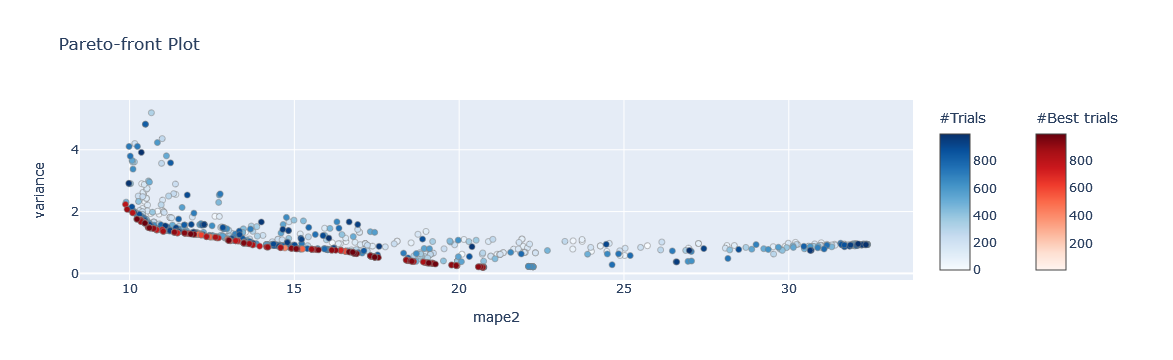

In [37]:
optuna.visualization.plot_pareto_front(study, target_names=["mape2", "variance"])

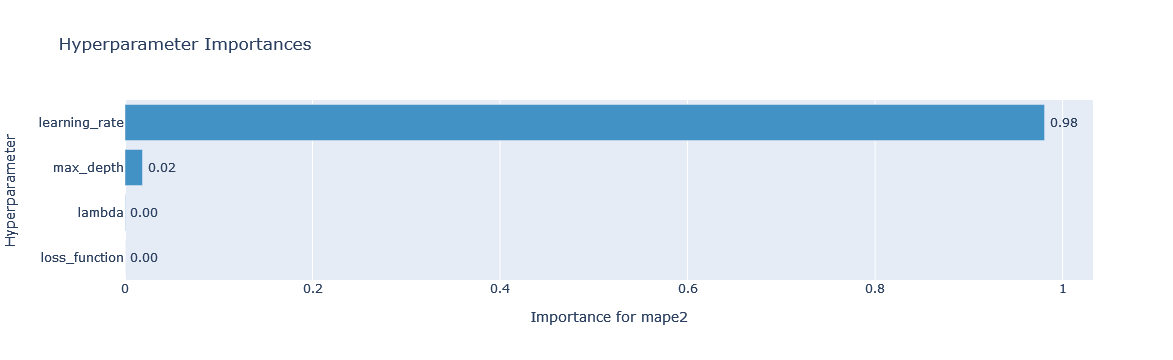

In [38]:
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name="mape2")

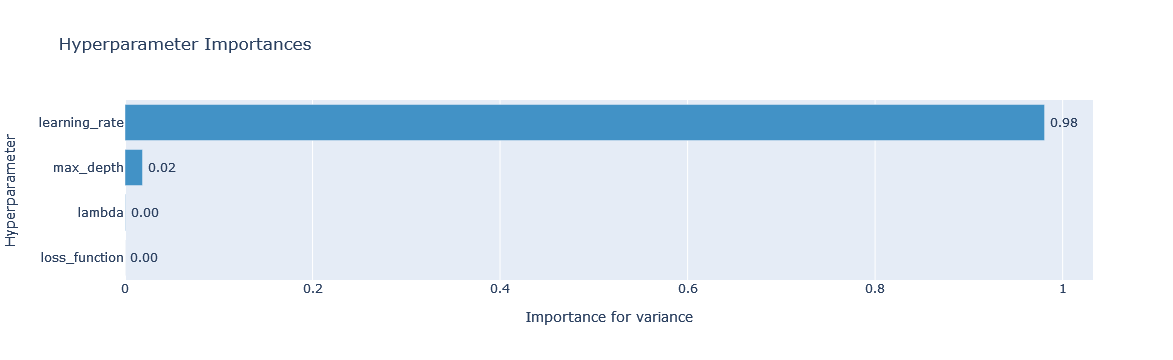

In [39]:
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name="variance")

## The Cell below contains code to execute the selected hyperparameters in CatBoostRegressor Algorithm. As before it produces both the training and the test set MAPE to measure the variance.

## The Cell below contains code to execute the selected hyperparameters for the best test MAPE error.

In [53]:
param={'one_hot_max_size':256,
       'iterations': 1000000,
       'learning_rate': 0.00950287952607806,
       'use_best_model': True, 
       #'od_type': 'Iter'
       #'od_wait': 10000, 
       'max_depth': 6,
       'l2_leaf_reg': 10.308229668923286,
       'loss_function':'RMSE'}
model=CatBoostRegressor(**param)
print(param)
model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
variance = mape2-mape1
print("The MAPE for train is", mape1)
print("The MAPE for test is", mape2)
print("The VARIANCE is ",variance)

{'one_hot_max_size': 256, 'iterations': 1000000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'max_depth': 6, 'l2_leaf_reg': 10.308229668923286, 'loss_function': 'RMSE'}
The MAPE for train is 2.9191550487266302
The MAPE for test is 8.925187980786633
The VARIANCE is  6.006032932060004


## The Cell below contains code to execute the selected hyperparameters for the best variance

In [50]:
param={'one_hot_max_size':256,
       'iterations': 2000000,
       'learning_rate': 0.0006131619695681747,
       'use_best_model': True, 
       #'od_type': 'Iter'
       #'od_wait': 10000, 
       'max_depth': 2,
       'l2_leaf_reg': 16.370235800666045,
       'loss_function':'RMSE'}
model=CatBoostRegressor(**param)
print(param)
model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
variance = mape2-mape1
print("The MAPE for train is", mape1)
print("The MAPE for test is", mape2)
print("The VARIANCE is ",variance)

{'one_hot_max_size': 256, 'iterations': 2000000, 'learning_rate': 0.0006131619695681747, 'use_best_model': True, 'max_depth': 2, 'l2_leaf_reg': 16.370235800666045, 'loss_function': 'RMSE'}
The MAPE for train is 4.563988227599087
The MAPE for test is 9.263431962530627
The VARIANCE is  4.699443734931539


## The Cell below contains code to execute the selected hyperparameters for the best of both according to the pareto feature.

In [52]:
param={'one_hot_max_size':256,
       'iterations': 2500000,
       'learning_rate': 0.00950287952607806,
       'use_best_model': True, 
       #'od_type': 'Iter'
       #'od_wait': 10000, 
       'max_depth': 4,
       'l2_leaf_reg': 16.619447739289708,
       'loss_function':'RMSE'}
model=CatBoostRegressor(**param)
print(param)
model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
variance = mape2-mape1
print("The MAPE for train is", mape1)
print("The MAPE for test is", mape2)
print("The VARIANCE is ",variance) 

{'one_hot_max_size': 256, 'iterations': 2500000, 'learning_rate': 0.00950287952607806, 'use_best_model': True, 'max_depth': 4, 'l2_leaf_reg': 16.619447739289708, 'loss_function': 'RMSE'}
The MAPE for train is 3.6651942666071373
The MAPE for test is 9.08094357906308
The VARIANCE is  5.415749312455942


# I will add the cell for outputting the submission file here after I am done with the training and I am sure that the model can properly generalize with the lowest error possible.